# Description

It runs DBSCAN on the `umap` version of the data.

The notebook explores different values for `min_samples` and `eps` (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
np.random.seed(0)

In [6]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: umap

## Settings

In [7]:
INPUT_SUBSET = "umap"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
# parameters of the dimentionality reduction steps
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [11]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [12]:
data = pd.read_pickle(input_filepath)

In [13]:
data.shape

(3749, 50)

In [14]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,11.531590,10.773390,10.551500,5.689103,12.646474,8.795625,2.365859,-3.382425,1.458605,14.236823,...,2.214731,9.304909,3.359118,5.211676,1.265622,2.058685,1.291174,1.565621,7.317275,9.037535
100002_raw-Energy,11.554761,10.753816,10.548004,5.710800,12.674987,8.787647,2.379787,-3.339913,1.442655,14.196218,...,2.237087,9.270699,3.383440,5.185328,1.257113,2.057439,1.290686,1.557209,7.297037,9.009866
100003_raw-Protein,11.519615,10.786408,10.540249,5.687959,12.628188,8.789925,2.368370,-3.390937,1.464806,14.233623,...,2.216162,9.314158,3.350708,5.226166,1.267382,2.051692,1.305047,1.558942,7.307035,9.042575
100004_raw-Fat,11.515584,10.756584,10.570711,5.697041,12.661936,8.787330,2.396913,-3.351611,1.435632,14.221588,...,2.214707,9.273252,3.383349,5.220068,1.270067,2.065669,1.281447,1.578588,7.332527,9.005523
100005_raw-Carbohydrate,11.528723,10.762026,10.566773,5.698555,12.671127,8.791903,2.394764,-3.354370,1.442259,14.226301,...,2.216362,9.275563,3.383139,5.216354,1.269187,2.063429,1.280020,1.577227,7.335059,9.009464


In [15]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [16]:
k_values = np.arange(10, 150 + 1, 1)
k_values_to_explore = (10, 15, 20, 30, 40, 50, 75, 100, 125, 150)  # , 175, 200)

In [17]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [18]:
# min_max_range = (1.0, 3)

eps_range_per_k = {
    k: (0.75, 1.25)
    if k == 10
    else (0.85, 1.60)
    if k == 15
    else (1.0, 2.50)
    if k < 40
    else (1.25, 3.0)
    if k < 75
    else (1.25, 3.0)
    if k < 100
    else (1.50, 3.0)
    if k < 175
    else (1.75, 3.0)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

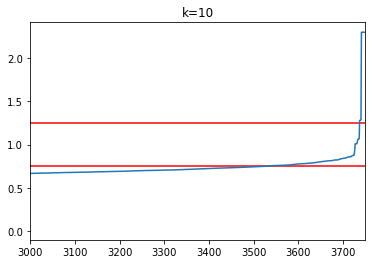

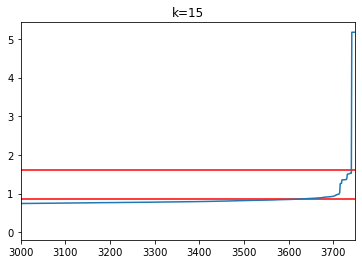

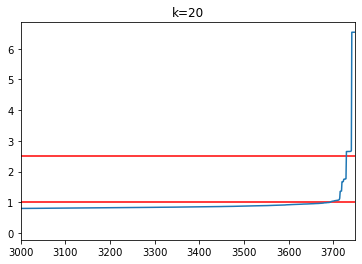

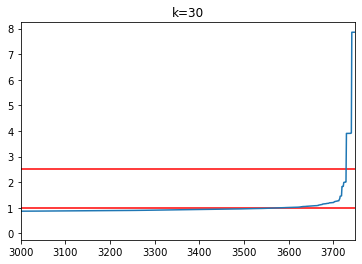

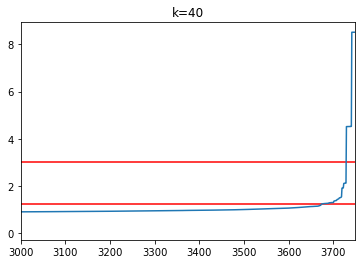

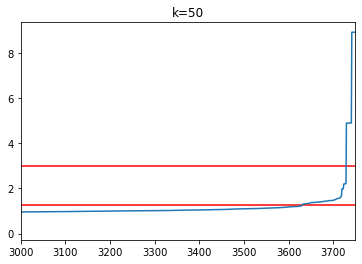

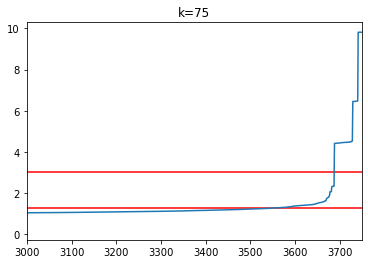

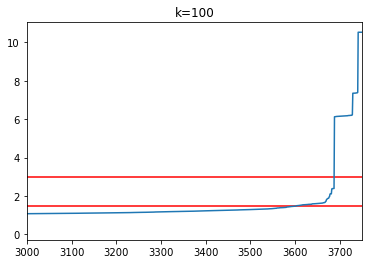

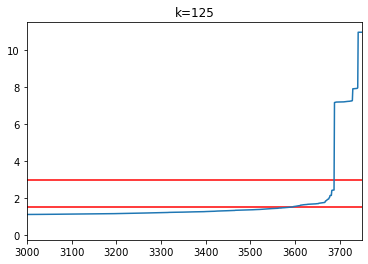

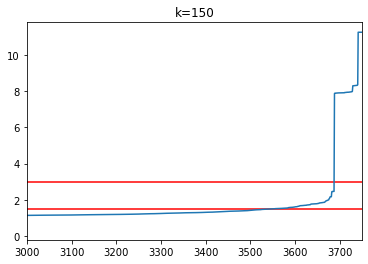

In [19]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

## Clustering

### Generate clusterers

In [20]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]),
 'EPS_RANGE_PER_K': {10: (0.75, 1.25),
  11: (1.0, 2.5),
  12: (1.0, 2.5),
  13: (1.0, 2.5),
  14: (1.0, 2.5),
  15: (0.85, 1.6),
  16: (1.0, 2.5),
  17: (1.0, 2.5),
  18: (1.0, 2.5),
  19: (1.0

In [21]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [22]:
display(len(CLUSTERERS))

4653

In [23]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=0.75, metric='precomputed', min_samples=10, n_jobs=2))

('DBSCAN #1',
 DBSCAN(eps=0.765625, metric='precomputed', min_samples=10, n_jobs=2))

In [24]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [25]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [26]:
data_dist.shape

(3749, 3749)

In [27]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     2.1742653846740723
std       2.128391742706299
min                     0.0
25%      1.4129530191421509
50%       1.622597336769104
75%      2.1182587146759033
max      15.023402214050293
dtype: object

In [28]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/4653 [00:00<?, ?it/s]

  0%|          | 2/4653 [00:00<06:41, 11.58it/s]

  0%|          | 4/4653 [00:00<06:47, 11.41it/s]

  0%|          | 6/4653 [00:00<06:53, 11.24it/s]

  0%|          | 8/4653 [00:00<06:59, 11.07it/s]

  0%|          | 10/4653 [00:00<07:06, 10.88it/s]

  0%|          | 11/4653 [00:01<07:19, 10.56it/s]

  0%|          | 13/4653 [00:01<07:24, 10.44it/s]

  0%|          | 14/4653 [00:01<07:32, 10.26it/s]

  0%|          | 16/4653 [00:01<07:35, 10.18it/s]

  0%|          | 17/4653 [00:01<07:39, 10.10it/s]

  0%|          | 18/4653 [00:01<07:42, 10.02it/s]

  0%|          | 19/4653 [00:01<07:45,  9.95it/s]

  0%|          | 20/4653 [00:01<07:50,  9.84it/s]

  0%|          | 21/4653 [00:02<07:57,  9.70it/s]

  0%|          | 22/4653 [00:02<08:00,  9.64it/s]

  0%|          | 23/4653 [00:02<08:03,  9.57it/s]

  1%|          | 24/4653 [00:02<08:07,  9.50it/s]

  1%|          | 25/4653 [00:02<08:11,  9.42it/s]

  1%|          | 26/4653 [00:02<08:16,  9.32it/s]

  1%|          | 27/4653 [00:02<08:21,  9.23it/s]

  1%|          | 28/4653 [00:02<08:25,  9.14it/s]

  1%|          | 29/4653 [00:02<08:32,  9.03it/s]

  1%|          | 30/4653 [00:03<08:43,  8.83it/s]

  1%|          | 31/4653 [00:03<08:50,  8.72it/s]

  1%|          | 32/4653 [00:03<08:58,  8.59it/s]

  1%|          | 33/4653 [00:03<09:03,  8.49it/s]

  1%|          | 34/4653 [00:03<08:39,  8.89it/s]

  1%|          | 35/4653 [00:03<08:26,  9.12it/s]

  1%|          | 36/4653 [00:03<08:21,  9.20it/s]

  1%|          | 37/4653 [00:03<08:22,  9.18it/s]

  1%|          | 38/4653 [00:03<08:29,  9.06it/s]

  1%|          | 39/4653 [00:04<08:43,  8.82it/s]

  1%|          | 40/4653 [00:04<08:57,  8.58it/s]

  1%|          | 41/4653 [00:04<10:37,  7.23it/s]

  1%|          | 42/4653 [00:04<10:39,  7.21it/s]

  1%|          | 43/4653 [00:04<10:45,  7.14it/s]

  1%|          | 44/4653 [00:04<11:06,  6.92it/s]

  1%|          | 45/4653 [00:04<11:28,  6.69it/s]

  1%|          | 46/4653 [00:05<11:48,  6.50it/s]

  1%|          | 47/4653 [00:05<12:02,  6.38it/s]

  1%|          | 48/4653 [00:05<12:12,  6.29it/s]

  1%|          | 49/4653 [00:05<12:16,  6.25it/s]

  1%|          | 50/4653 [00:05<12:40,  6.05it/s]

  1%|          | 51/4653 [00:05<13:00,  5.90it/s]

  1%|          | 52/4653 [00:06<13:12,  5.80it/s]

  1%|          | 53/4653 [00:06<13:20,  5.75it/s]

  1%|          | 54/4653 [00:06<13:22,  5.73it/s]

  1%|          | 55/4653 [00:06<13:23,  5.72it/s]

  1%|          | 56/4653 [00:06<13:24,  5.72it/s]

  1%|          | 57/4653 [00:07<13:28,  5.69it/s]

  1%|          | 58/4653 [00:07<13:26,  5.70it/s]

  1%|▏         | 59/4653 [00:07<13:26,  5.69it/s]

  1%|▏         | 60/4653 [00:07<13:26,  5.69it/s]

  1%|▏         | 61/4653 [00:07<13:24,  5.71it/s]

  1%|▏         | 62/4653 [00:07<13:24,  5.71it/s]

  1%|▏         | 63/4653 [00:08<13:28,  5.68it/s]

  1%|▏         | 64/4653 [00:08<13:25,  5.70it/s]

  1%|▏         | 65/4653 [00:08<13:27,  5.68it/s]

  1%|▏         | 66/4653 [00:08<13:26,  5.68it/s]

  1%|▏         | 67/4653 [00:08<11:44,  6.51it/s]

  1%|▏         | 68/4653 [00:08<10:35,  7.21it/s]

  1%|▏         | 69/4653 [00:08<09:51,  7.74it/s]

  2%|▏         | 70/4653 [00:09<09:29,  8.05it/s]

  2%|▏         | 71/4653 [00:09<09:16,  8.24it/s]

  2%|▏         | 72/4653 [00:09<09:12,  8.29it/s]

  2%|▏         | 73/4653 [00:09<09:18,  8.20it/s]

  2%|▏         | 74/4653 [00:09<09:28,  8.06it/s]

  2%|▏         | 75/4653 [00:09<09:42,  7.85it/s]

  2%|▏         | 76/4653 [00:09<10:01,  7.61it/s]

  2%|▏         | 77/4653 [00:09<10:31,  7.25it/s]

  2%|▏         | 78/4653 [00:10<11:00,  6.92it/s]

  2%|▏         | 79/4653 [00:10<11:22,  6.70it/s]

  2%|▏         | 80/4653 [00:10<11:39,  6.54it/s]

  2%|▏         | 81/4653 [00:10<11:49,  6.44it/s]

  2%|▏         | 82/4653 [00:10<11:58,  6.36it/s]

  2%|▏         | 83/4653 [00:10<12:24,  6.13it/s]

  2%|▏         | 84/4653 [00:11<12:46,  5.96it/s]

  2%|▏         | 85/4653 [00:11<14:07,  5.39it/s]

  2%|▏         | 86/4653 [00:11<13:54,  5.47it/s]

  2%|▏         | 87/4653 [00:11<13:43,  5.54it/s]

  2%|▏         | 88/4653 [00:11<13:35,  5.60it/s]

  2%|▏         | 89/4653 [00:12<13:34,  5.60it/s]

  2%|▏         | 90/4653 [00:12<13:28,  5.64it/s]

  2%|▏         | 91/4653 [00:12<13:26,  5.65it/s]

  2%|▏         | 92/4653 [00:12<13:22,  5.68it/s]

  2%|▏         | 93/4653 [00:12<13:19,  5.70it/s]

  2%|▏         | 94/4653 [00:12<13:18,  5.71it/s]

  2%|▏         | 95/4653 [00:13<13:22,  5.68it/s]

  2%|▏         | 96/4653 [00:13<13:19,  5.70it/s]

  2%|▏         | 97/4653 [00:13<13:22,  5.68it/s]

  2%|▏         | 98/4653 [00:13<13:20,  5.69it/s]

  2%|▏         | 99/4653 [00:13<13:20,  5.69it/s]

  2%|▏         | 100/4653 [00:13<11:37,  6.53it/s]

  2%|▏         | 101/4653 [00:13<10:31,  7.20it/s]

  2%|▏         | 102/4653 [00:14<09:50,  7.71it/s]

  2%|▏         | 103/4653 [00:14<09:23,  8.08it/s]

  2%|▏         | 104/4653 [00:14<09:11,  8.25it/s]

  2%|▏         | 105/4653 [00:14<09:08,  8.29it/s]

  2%|▏         | 106/4653 [00:14<09:10,  8.26it/s]

  2%|▏         | 107/4653 [00:14<09:20,  8.10it/s]

  2%|▏         | 108/4653 [00:14<09:35,  7.90it/s]

  2%|▏         | 109/4653 [00:14<09:55,  7.64it/s]

  2%|▏         | 110/4653 [00:15<10:29,  7.22it/s]

  2%|▏         | 111/4653 [00:15<10:54,  6.94it/s]

  2%|▏         | 112/4653 [00:15<11:16,  6.72it/s]

  2%|▏         | 113/4653 [00:15<11:32,  6.55it/s]

  2%|▏         | 114/4653 [00:15<11:44,  6.44it/s]

  2%|▏         | 115/4653 [00:15<11:52,  6.37it/s]

  2%|▏         | 116/4653 [00:16<12:26,  6.08it/s]

  3%|▎         | 117/4653 [00:16<12:40,  5.96it/s]

  3%|▎         | 118/4653 [00:16<12:55,  5.85it/s]

  3%|▎         | 119/4653 [00:16<13:02,  5.79it/s]

  3%|▎         | 120/4653 [00:16<13:07,  5.76it/s]

  3%|▎         | 121/4653 [00:16<13:12,  5.72it/s]

  3%|▎         | 122/4653 [00:17<13:15,  5.70it/s]

  3%|▎         | 123/4653 [00:17<13:14,  5.70it/s]

  3%|▎         | 124/4653 [00:17<13:12,  5.71it/s]

  3%|▎         | 125/4653 [00:17<13:12,  5.72it/s]

  3%|▎         | 126/4653 [00:17<13:10,  5.73it/s]

  3%|▎         | 127/4653 [00:18<13:16,  5.69it/s]

  3%|▎         | 128/4653 [00:18<14:18,  5.27it/s]

  3%|▎         | 129/4653 [00:18<14:06,  5.34it/s]

  3%|▎         | 130/4653 [00:18<13:45,  5.48it/s]

  3%|▎         | 131/4653 [00:18<13:32,  5.56it/s]

  3%|▎         | 132/4653 [00:18<13:22,  5.63it/s]

  3%|▎         | 133/4653 [00:19<11:39,  6.46it/s]

  3%|▎         | 134/4653 [00:19<10:28,  7.19it/s]

  3%|▎         | 135/4653 [00:19<09:41,  7.77it/s]

  3%|▎         | 136/4653 [00:19<09:15,  8.13it/s]

  3%|▎         | 137/4653 [00:19<09:02,  8.33it/s]

  3%|▎         | 138/4653 [00:19<08:57,  8.40it/s]

  3%|▎         | 139/4653 [00:19<09:01,  8.34it/s]

  3%|▎         | 140/4653 [00:19<09:10,  8.19it/s]

  3%|▎         | 141/4653 [00:20<09:27,  7.94it/s]

  3%|▎         | 142/4653 [00:20<09:48,  7.67it/s]

  3%|▎         | 143/4653 [00:20<10:17,  7.30it/s]

  3%|▎         | 144/4653 [00:20<10:45,  6.99it/s]

  3%|▎         | 145/4653 [00:20<11:04,  6.78it/s]

  3%|▎         | 146/4653 [00:20<11:23,  6.59it/s]

  3%|▎         | 147/4653 [00:20<11:33,  6.49it/s]

  3%|▎         | 148/4653 [00:21<11:47,  6.36it/s]

  3%|▎         | 149/4653 [00:21<12:12,  6.15it/s]

  3%|▎         | 150/4653 [00:21<12:31,  5.99it/s]

  3%|▎         | 151/4653 [00:21<12:38,  5.94it/s]

  3%|▎         | 152/4653 [00:21<12:42,  5.90it/s]

  3%|▎         | 153/4653 [00:21<12:45,  5.88it/s]

  3%|▎         | 154/4653 [00:22<12:52,  5.83it/s]

  3%|▎         | 155/4653 [00:22<12:52,  5.83it/s]

  3%|▎         | 156/4653 [00:22<12:57,  5.78it/s]

  3%|▎         | 157/4653 [00:22<12:56,  5.79it/s]

  3%|▎         | 158/4653 [00:22<12:55,  5.79it/s]

  3%|▎         | 159/4653 [00:22<12:53,  5.81it/s]

  3%|▎         | 160/4653 [00:23<12:57,  5.78it/s]

  3%|▎         | 161/4653 [00:23<12:57,  5.78it/s]

  3%|▎         | 162/4653 [00:23<12:56,  5.78it/s]

  4%|▎         | 163/4653 [00:23<12:53,  5.81it/s]

  4%|▎         | 164/4653 [00:23<12:53,  5.80it/s]

  4%|▎         | 165/4653 [00:24<12:56,  5.78it/s]

  4%|▎         | 167/4653 [00:24<11:03,  6.76it/s]

  4%|▎         | 169/4653 [00:24<09:50,  7.59it/s]

  4%|▎         | 171/4653 [00:24<09:01,  8.28it/s]

  4%|▎         | 173/4653 [00:24<08:30,  8.78it/s]

  4%|▎         | 174/4653 [00:24<08:12,  9.09it/s]

  4%|▍         | 175/4653 [00:24<08:02,  9.28it/s]

  4%|▍         | 176/4653 [00:25<08:01,  9.29it/s]

  4%|▍         | 177/4653 [00:25<07:58,  9.35it/s]

  4%|▍         | 178/4653 [00:25<07:59,  9.34it/s]

  4%|▍         | 179/4653 [00:25<08:05,  9.21it/s]

  4%|▍         | 180/4653 [00:25<08:09,  9.13it/s]

  4%|▍         | 181/4653 [00:25<08:14,  9.04it/s]

  4%|▍         | 182/4653 [00:25<08:22,  8.89it/s]

  4%|▍         | 183/4653 [00:25<09:27,  7.88it/s]

  4%|▍         | 184/4653 [00:26<09:29,  7.85it/s]

  4%|▍         | 185/4653 [00:26<09:24,  7.91it/s]

  4%|▍         | 186/4653 [00:26<09:22,  7.94it/s]

  4%|▍         | 187/4653 [00:26<09:29,  7.85it/s]

  4%|▍         | 188/4653 [00:26<09:36,  7.75it/s]

  4%|▍         | 189/4653 [00:26<09:44,  7.64it/s]

  4%|▍         | 190/4653 [00:26<09:54,  7.50it/s]

  4%|▍         | 191/4653 [00:26<10:03,  7.40it/s]

  4%|▍         | 192/4653 [00:27<10:29,  7.08it/s]

  4%|▍         | 193/4653 [00:27<10:48,  6.88it/s]

  4%|▍         | 194/4653 [00:27<11:02,  6.73it/s]

  4%|▍         | 195/4653 [00:27<11:15,  6.60it/s]

  4%|▍         | 196/4653 [00:27<11:24,  6.51it/s]

  4%|▍         | 197/4653 [00:27<11:32,  6.44it/s]

  4%|▍         | 198/4653 [00:28<11:42,  6.35it/s]

  4%|▍         | 200/4653 [00:28<10:23,  7.14it/s]

  4%|▍         | 201/4653 [00:28<09:39,  7.68it/s]

  4%|▍         | 202/4653 [00:28<09:12,  8.06it/s]

  4%|▍         | 203/4653 [00:28<08:56,  8.29it/s]

  4%|▍         | 204/4653 [00:28<08:54,  8.33it/s]

  4%|▍         | 205/4653 [00:28<08:54,  8.32it/s]

  4%|▍         | 206/4653 [00:28<09:04,  8.17it/s]

  4%|▍         | 207/4653 [00:29<09:24,  7.88it/s]

  4%|▍         | 208/4653 [00:29<09:39,  7.66it/s]

  4%|▍         | 209/4653 [00:29<10:12,  7.26it/s]

  5%|▍         | 210/4653 [00:29<10:40,  6.94it/s]

  5%|▍         | 211/4653 [00:29<11:00,  6.73it/s]

  5%|▍         | 212/4653 [00:29<11:17,  6.56it/s]

  5%|▍         | 213/4653 [00:30<11:32,  6.42it/s]

  5%|▍         | 214/4653 [00:30<11:35,  6.38it/s]

  5%|▍         | 215/4653 [00:30<12:03,  6.14it/s]

  5%|▍         | 216/4653 [00:30<12:21,  5.98it/s]

  5%|▍         | 217/4653 [00:30<12:33,  5.89it/s]

  5%|▍         | 218/4653 [00:30<12:38,  5.85it/s]

  5%|▍         | 219/4653 [00:31<12:48,  5.77it/s]

  5%|▍         | 220/4653 [00:31<12:50,  5.76it/s]

  5%|▍         | 221/4653 [00:31<12:52,  5.74it/s]

  5%|▍         | 222/4653 [00:31<12:51,  5.74it/s]

  5%|▍         | 223/4653 [00:31<12:49,  5.75it/s]

  5%|▍         | 224/4653 [00:31<12:50,  5.75it/s]

  5%|▍         | 225/4653 [00:32<12:54,  5.72it/s]

  5%|▍         | 226/4653 [00:32<12:51,  5.74it/s]

  5%|▍         | 227/4653 [00:32<13:59,  5.27it/s]

  5%|▍         | 228/4653 [00:32<13:38,  5.41it/s]

  5%|▍         | 229/4653 [00:32<13:24,  5.50it/s]

  5%|▍         | 230/4653 [00:33<13:15,  5.56it/s]

  5%|▍         | 231/4653 [00:33<13:09,  5.60it/s]

  5%|▌         | 233/4653 [00:33<11:24,  6.46it/s]

  5%|▌         | 234/4653 [00:33<10:18,  7.15it/s]

  5%|▌         | 235/4653 [00:33<09:36,  7.67it/s]

  5%|▌         | 236/4653 [00:33<09:12,  8.00it/s]

  5%|▌         | 237/4653 [00:33<09:01,  8.15it/s]

  5%|▌         | 238/4653 [00:34<08:59,  8.18it/s]

  5%|▌         | 239/4653 [00:34<09:11,  8.00it/s]

  5%|▌         | 240/4653 [00:34<09:23,  7.84it/s]

  5%|▌         | 241/4653 [00:34<09:38,  7.63it/s]

  5%|▌         | 242/4653 [00:34<10:07,  7.26it/s]

  5%|▌         | 243/4653 [00:34<10:32,  6.97it/s]

  5%|▌         | 244/4653 [00:34<10:53,  6.74it/s]

  5%|▌         | 245/4653 [00:35<11:09,  6.58it/s]

  5%|▌         | 246/4653 [00:35<11:27,  6.41it/s]

  5%|▌         | 247/4653 [00:35<11:32,  6.36it/s]

  5%|▌         | 248/4653 [00:35<12:03,  6.09it/s]

  5%|▌         | 249/4653 [00:35<12:18,  5.96it/s]

  5%|▌         | 250/4653 [00:35<12:29,  5.87it/s]

  5%|▌         | 251/4653 [00:36<12:39,  5.79it/s]

  5%|▌         | 252/4653 [00:36<12:45,  5.75it/s]

  5%|▌         | 253/4653 [00:36<12:47,  5.73it/s]

  5%|▌         | 254/4653 [00:36<12:47,  5.73it/s]

  5%|▌         | 255/4653 [00:36<12:46,  5.74it/s]

  6%|▌         | 256/4653 [00:36<12:45,  5.75it/s]

  6%|▌         | 257/4653 [00:37<12:48,  5.72it/s]

  6%|▌         | 258/4653 [00:37<12:47,  5.73it/s]

  6%|▌         | 259/4653 [00:37<12:47,  5.73it/s]

  6%|▌         | 260/4653 [00:37<12:45,  5.74it/s]

  6%|▌         | 261/4653 [00:37<12:43,  5.75it/s]

  6%|▌         | 262/4653 [00:37<12:42,  5.76it/s]

  6%|▌         | 263/4653 [00:38<12:46,  5.73it/s]

  6%|▌         | 264/4653 [00:38<12:45,  5.73it/s]

  6%|▌         | 266/4653 [00:38<11:07,  6.57it/s]

  6%|▌         | 267/4653 [00:38<10:04,  7.26it/s]

  6%|▌         | 268/4653 [00:38<09:25,  7.76it/s]

  6%|▌         | 269/4653 [00:38<09:02,  8.09it/s]

  6%|▌         | 270/4653 [00:38<08:53,  8.22it/s]

  6%|▌         | 271/4653 [00:39<09:53,  7.39it/s]

  6%|▌         | 272/4653 [00:39<09:49,  7.43it/s]

  6%|▌         | 273/4653 [00:39<09:52,  7.40it/s]

  6%|▌         | 274/4653 [00:39<09:59,  7.31it/s]

  6%|▌         | 275/4653 [00:39<10:20,  7.05it/s]

  6%|▌         | 276/4653 [00:39<10:41,  6.82it/s]

  6%|▌         | 277/4653 [00:40<10:58,  6.64it/s]

  6%|▌         | 278/4653 [00:40<11:15,  6.47it/s]

  6%|▌         | 279/4653 [00:40<11:24,  6.39it/s]

  6%|▌         | 280/4653 [00:40<11:33,  6.31it/s]

  6%|▌         | 281/4653 [00:40<11:57,  6.09it/s]

  6%|▌         | 282/4653 [00:40<12:13,  5.96it/s]

  6%|▌         | 283/4653 [00:41<12:25,  5.87it/s]

  6%|▌         | 284/4653 [00:41<12:36,  5.77it/s]

  6%|▌         | 285/4653 [00:41<12:40,  5.75it/s]

  6%|▌         | 286/4653 [00:41<12:44,  5.71it/s]

  6%|▌         | 287/4653 [00:41<12:41,  5.73it/s]

  6%|▌         | 288/4653 [00:41<12:42,  5.73it/s]

  6%|▌         | 289/4653 [00:42<12:45,  5.70it/s]

  6%|▌         | 290/4653 [00:42<12:45,  5.70it/s]

  6%|▋         | 291/4653 [00:42<12:43,  5.72it/s]

  6%|▋         | 292/4653 [00:42<12:42,  5.72it/s]

  6%|▋         | 293/4653 [00:42<12:41,  5.73it/s]

  6%|▋         | 294/4653 [00:42<12:39,  5.74it/s]

  6%|▋         | 295/4653 [00:43<12:43,  5.70it/s]

  6%|▋         | 296/4653 [00:43<12:42,  5.71it/s]

  6%|▋         | 297/4653 [00:43<12:45,  5.69it/s]

  6%|▋         | 299/4653 [00:43<11:05,  6.54it/s]

  6%|▋         | 300/4653 [00:43<10:02,  7.23it/s]

  6%|▋         | 301/4653 [00:43<09:21,  7.74it/s]

  6%|▋         | 302/4653 [00:44<08:59,  8.07it/s]

  7%|▋         | 303/4653 [00:44<08:55,  8.12it/s]

  7%|▋         | 304/4653 [00:44<08:54,  8.14it/s]

  7%|▋         | 305/4653 [00:44<09:00,  8.04it/s]

  7%|▋         | 306/4653 [00:44<09:15,  7.83it/s]

  7%|▋         | 307/4653 [00:44<09:31,  7.61it/s]

  7%|▋         | 308/4653 [00:44<09:57,  7.28it/s]

  7%|▋         | 309/4653 [00:44<10:21,  6.99it/s]

  7%|▋         | 310/4653 [00:45<10:47,  6.71it/s]

  7%|▋         | 311/4653 [00:45<11:03,  6.55it/s]

  7%|▋         | 312/4653 [00:45<11:15,  6.42it/s]

  7%|▋         | 313/4653 [00:45<11:22,  6.36it/s]

  7%|▋         | 314/4653 [00:45<11:47,  6.13it/s]

  7%|▋         | 315/4653 [00:45<12:04,  5.99it/s]

  7%|▋         | 316/4653 [00:46<12:20,  5.86it/s]

  7%|▋         | 317/4653 [00:46<12:25,  5.81it/s]

  7%|▋         | 318/4653 [00:46<13:37,  5.30it/s]

  7%|▋         | 319/4653 [00:46<13:21,  5.40it/s]

  7%|▋         | 320/4653 [00:46<13:07,  5.50it/s]

  7%|▋         | 321/4653 [00:47<12:59,  5.56it/s]

  7%|▋         | 322/4653 [00:47<12:54,  5.59it/s]

  7%|▋         | 323/4653 [00:47<12:50,  5.62it/s]

  7%|▋         | 324/4653 [00:47<12:46,  5.65it/s]

  7%|▋         | 325/4653 [00:47<12:40,  5.69it/s]

  7%|▋         | 326/4653 [00:47<12:35,  5.73it/s]

  7%|▋         | 327/4653 [00:48<12:36,  5.72it/s]

  7%|▋         | 328/4653 [00:48<12:34,  5.74it/s]

  7%|▋         | 329/4653 [00:48<12:33,  5.74it/s]

  7%|▋         | 330/4653 [00:48<12:32,  5.75it/s]

  7%|▋         | 332/4653 [00:48<10:53,  6.61it/s]

  7%|▋         | 333/4653 [00:48<09:52,  7.30it/s]

  7%|▋         | 334/4653 [00:49<09:14,  7.79it/s]

  7%|▋         | 335/4653 [00:49<08:57,  8.04it/s]

  7%|▋         | 336/4653 [00:49<08:48,  8.18it/s]

  7%|▋         | 337/4653 [00:49<08:47,  8.19it/s]

  7%|▋         | 338/4653 [00:49<08:56,  8.04it/s]

  7%|▋         | 339/4653 [00:49<09:08,  7.87it/s]

  7%|▋         | 340/4653 [00:49<09:24,  7.64it/s]

  7%|▋         | 341/4653 [00:49<09:51,  7.29it/s]

  7%|▋         | 342/4653 [00:50<10:19,  6.96it/s]

  7%|▋         | 343/4653 [00:50<10:40,  6.73it/s]

  7%|▋         | 344/4653 [00:50<10:56,  6.57it/s]

  7%|▋         | 345/4653 [00:50<11:09,  6.43it/s]

  7%|▋         | 346/4653 [00:50<11:15,  6.37it/s]

  7%|▋         | 347/4653 [00:50<11:38,  6.16it/s]

  7%|▋         | 348/4653 [00:51<11:58,  5.99it/s]

  8%|▊         | 349/4653 [00:51<12:10,  5.89it/s]

  8%|▊         | 350/4653 [00:51<12:18,  5.83it/s]

  8%|▊         | 351/4653 [00:51<12:21,  5.80it/s]

  8%|▊         | 352/4653 [00:51<12:23,  5.78it/s]

  8%|▊         | 353/4653 [00:52<12:22,  5.79it/s]

  8%|▊         | 354/4653 [00:52<12:27,  5.75it/s]

  8%|▊         | 355/4653 [00:52<12:26,  5.75it/s]

  8%|▊         | 356/4653 [00:52<12:27,  5.75it/s]

  8%|▊         | 357/4653 [00:52<12:26,  5.75it/s]

  8%|▊         | 358/4653 [00:52<12:26,  5.75it/s]

  8%|▊         | 359/4653 [00:53<12:24,  5.77it/s]

  8%|▊         | 360/4653 [00:53<12:29,  5.73it/s]

  8%|▊         | 361/4653 [00:53<12:27,  5.74it/s]

  8%|▊         | 362/4653 [00:53<12:28,  5.74it/s]

  8%|▊         | 363/4653 [00:53<12:28,  5.74it/s]

  8%|▊         | 365/4653 [00:53<10:50,  6.60it/s]

  8%|▊         | 366/4653 [00:54<09:48,  7.28it/s]

  8%|▊         | 367/4653 [00:54<09:15,  7.72it/s]

  8%|▊         | 368/4653 [00:54<08:53,  8.03it/s]

  8%|▊         | 369/4653 [00:54<08:43,  8.18it/s]

  8%|▊         | 370/4653 [00:54<09:41,  7.37it/s]

  8%|▊         | 371/4653 [00:54<09:37,  7.41it/s]

  8%|▊         | 372/4653 [00:54<09:35,  7.44it/s]

  8%|▊         | 373/4653 [00:54<09:39,  7.39it/s]

  8%|▊         | 374/4653 [00:55<09:59,  7.14it/s]

  8%|▊         | 375/4653 [00:55<10:24,  6.85it/s]

  8%|▊         | 376/4653 [00:55<10:40,  6.67it/s]

  8%|▊         | 377/4653 [00:55<10:55,  6.52it/s]

  8%|▊         | 378/4653 [00:55<11:04,  6.43it/s]

  8%|▊         | 379/4653 [00:55<11:11,  6.37it/s]

  8%|▊         | 380/4653 [00:56<11:36,  6.14it/s]

  8%|▊         | 381/4653 [00:56<11:54,  5.98it/s]

  8%|▊         | 382/4653 [00:56<12:03,  5.91it/s]

  8%|▊         | 383/4653 [00:56<12:12,  5.83it/s]

  8%|▊         | 384/4653 [00:56<12:17,  5.79it/s]

  8%|▊         | 385/4653 [00:56<12:16,  5.79it/s]

  8%|▊         | 386/4653 [00:57<12:20,  5.76it/s]

  8%|▊         | 387/4653 [00:57<12:22,  5.74it/s]

  8%|▊         | 388/4653 [00:57<12:21,  5.75it/s]

  8%|▊         | 389/4653 [00:57<12:21,  5.75it/s]

  8%|▊         | 390/4653 [00:57<12:18,  5.78it/s]

  8%|▊         | 391/4653 [00:58<12:17,  5.78it/s]

  8%|▊         | 392/4653 [00:58<12:21,  5.75it/s]

  8%|▊         | 393/4653 [00:58<12:20,  5.75it/s]

  8%|▊         | 394/4653 [00:58<12:20,  5.75it/s]

  8%|▊         | 395/4653 [00:58<12:20,  5.75it/s]

  9%|▊         | 396/4653 [00:58<12:21,  5.74it/s]

  9%|▊         | 398/4653 [00:59<10:44,  6.60it/s]

  9%|▊         | 399/4653 [00:59<09:48,  7.23it/s]

  9%|▊         | 400/4653 [00:59<09:11,  7.72it/s]

  9%|▊         | 401/4653 [00:59<08:49,  8.03it/s]

  9%|▊         | 402/4653 [00:59<08:42,  8.14it/s]

  9%|▊         | 403/4653 [00:59<08:41,  8.15it/s]

  9%|▊         | 404/4653 [00:59<08:47,  8.06it/s]

  9%|▊         | 405/4653 [00:59<08:59,  7.88it/s]

  9%|▊         | 406/4653 [01:00<09:13,  7.67it/s]

  9%|▊         | 407/4653 [01:00<09:46,  7.24it/s]

  9%|▉         | 408/4653 [01:00<10:06,  7.00it/s]

  9%|▉         | 409/4653 [01:00<10:29,  6.74it/s]

  9%|▉         | 410/4653 [01:00<10:45,  6.57it/s]

  9%|▉         | 411/4653 [01:00<10:56,  6.47it/s]

  9%|▉         | 412/4653 [01:01<11:03,  6.39it/s]

  9%|▉         | 413/4653 [01:01<11:30,  6.14it/s]

  9%|▉         | 414/4653 [01:01<11:47,  5.99it/s]

  9%|▉         | 415/4653 [01:01<11:58,  5.90it/s]

  9%|▉         | 416/4653 [01:01<12:05,  5.84it/s]

  9%|▉         | 417/4653 [01:01<12:07,  5.83it/s]

  9%|▉         | 418/4653 [01:02<12:10,  5.80it/s]

  9%|▉         | 419/4653 [01:02<13:15,  5.32it/s]

  9%|▉         | 420/4653 [01:02<13:03,  5.40it/s]

  9%|▉         | 421/4653 [01:02<12:49,  5.50it/s]

  9%|▉         | 422/4653 [01:02<12:37,  5.59it/s]

  9%|▉         | 423/4653 [01:02<12:27,  5.66it/s]

  9%|▉         | 424/4653 [01:03<12:22,  5.70it/s]

  9%|▉         | 425/4653 [01:03<12:23,  5.69it/s]

  9%|▉         | 426/4653 [01:03<12:18,  5.72it/s]

  9%|▉         | 427/4653 [01:03<12:17,  5.73it/s]

  9%|▉         | 428/4653 [01:03<12:13,  5.76it/s]

  9%|▉         | 429/4653 [01:04<12:14,  5.75it/s]

  9%|▉         | 431/4653 [01:04<10:39,  6.60it/s]

  9%|▉         | 432/4653 [01:04<09:38,  7.29it/s]

  9%|▉         | 433/4653 [01:04<09:01,  7.80it/s]

  9%|▉         | 434/4653 [01:04<08:41,  8.09it/s]

  9%|▉         | 435/4653 [01:04<08:32,  8.23it/s]

  9%|▉         | 436/4653 [01:04<08:30,  8.26it/s]

  9%|▉         | 437/4653 [01:04<08:36,  8.16it/s]

  9%|▉         | 438/4653 [01:05<08:49,  7.97it/s]

  9%|▉         | 439/4653 [01:05<09:08,  7.69it/s]

  9%|▉         | 440/4653 [01:05<09:37,  7.29it/s]

  9%|▉         | 441/4653 [01:05<10:02,  7.00it/s]

  9%|▉         | 442/4653 [01:05<10:23,  6.75it/s]

 10%|▉         | 443/4653 [01:05<10:36,  6.61it/s]

 10%|▉         | 444/4653 [01:05<10:47,  6.50it/s]

 10%|▉         | 445/4653 [01:06<10:55,  6.42it/s]

 10%|▉         | 446/4653 [01:06<11:25,  6.13it/s]

 10%|▉         | 447/4653 [01:06<11:40,  6.00it/s]

 10%|▉         | 448/4653 [01:06<11:55,  5.88it/s]

 10%|▉         | 449/4653 [01:06<11:59,  5.84it/s]

 10%|▉         | 450/4653 [01:07<12:03,  5.81it/s]

 10%|▉         | 451/4653 [01:07<12:08,  5.77it/s]

 10%|▉         | 452/4653 [01:07<12:10,  5.75it/s]

 10%|▉         | 453/4653 [01:07<12:10,  5.75it/s]

 10%|▉         | 454/4653 [01:07<12:12,  5.73it/s]

 10%|▉         | 455/4653 [01:07<12:08,  5.77it/s]

 10%|▉         | 456/4653 [01:08<12:07,  5.77it/s]

 10%|▉         | 457/4653 [01:08<12:08,  5.76it/s]

 10%|▉         | 458/4653 [01:08<12:09,  5.75it/s]

 10%|▉         | 459/4653 [01:08<12:09,  5.75it/s]

 10%|▉         | 460/4653 [01:08<12:09,  5.75it/s]

 10%|▉         | 461/4653 [01:08<12:09,  5.74it/s]

 10%|▉         | 462/4653 [01:09<12:07,  5.76it/s]

 10%|▉         | 464/4653 [01:09<10:34,  6.60it/s]

 10%|▉         | 465/4653 [01:09<09:34,  7.29it/s]

 10%|█         | 466/4653 [01:09<08:55,  7.81it/s]

 10%|█         | 467/4653 [01:09<08:37,  8.08it/s]

 10%|█         | 468/4653 [01:09<08:28,  8.24it/s]

 10%|█         | 469/4653 [01:09<08:28,  8.23it/s]

 10%|█         | 470/4653 [01:10<09:32,  7.30it/s]

 10%|█         | 471/4653 [01:10<09:34,  7.28it/s]

 10%|█         | 472/4653 [01:10<09:39,  7.22it/s]

 10%|█         | 473/4653 [01:10<09:56,  7.01it/s]

 10%|█         | 474/4653 [01:10<10:15,  6.79it/s]

 10%|█         | 475/4653 [01:10<10:30,  6.62it/s]

 10%|█         | 476/4653 [01:10<10:42,  6.50it/s]

 10%|█         | 477/4653 [01:11<10:51,  6.41it/s]

 10%|█         | 478/4653 [01:11<11:03,  6.29it/s]

 10%|█         | 479/4653 [01:11<11:26,  6.08it/s]

 10%|█         | 480/4653 [01:11<11:42,  5.94it/s]

 10%|█         | 481/4653 [01:11<11:51,  5.86it/s]

 10%|█         | 482/4653 [01:11<11:58,  5.81it/s]

 10%|█         | 483/4653 [01:12<12:00,  5.79it/s]

 10%|█         | 484/4653 [01:12<12:06,  5.74it/s]

 10%|█         | 485/4653 [01:12<12:05,  5.75it/s]

 10%|█         | 486/4653 [01:12<12:07,  5.73it/s]

 10%|█         | 487/4653 [01:12<12:05,  5.74it/s]

 10%|█         | 488/4653 [01:13<12:02,  5.76it/s]

 11%|█         | 489/4653 [01:13<12:00,  5.78it/s]

 11%|█         | 490/4653 [01:13<12:01,  5.77it/s]

 11%|█         | 491/4653 [01:13<12:01,  5.77it/s]

 11%|█         | 492/4653 [01:13<12:03,  5.75it/s]

 11%|█         | 493/4653 [01:13<12:00,  5.78it/s]

 11%|█         | 494/4653 [01:14<11:58,  5.79it/s]

 11%|█         | 495/4653 [01:14<12:03,  5.75it/s]

 11%|█         | 497/4653 [01:14<10:27,  6.62it/s]

 11%|█         | 498/4653 [01:14<09:26,  7.33it/s]

 11%|█         | 499/4653 [01:14<08:54,  7.78it/s]

 11%|█         | 500/4653 [01:14<08:33,  8.09it/s]

 11%|█         | 501/4653 [01:14<08:23,  8.25it/s]

 11%|█         | 502/4653 [01:15<08:22,  8.26it/s]

 11%|█         | 503/4653 [01:15<08:30,  8.14it/s]

 11%|█         | 504/4653 [01:15<08:47,  7.87it/s]

 11%|█         | 505/4653 [01:15<09:02,  7.65it/s]

 11%|█         | 506/4653 [01:15<09:28,  7.30it/s]

 11%|█         | 507/4653 [01:15<09:54,  6.98it/s]

 11%|█         | 508/4653 [01:15<10:11,  6.77it/s]

 11%|█         | 509/4653 [01:16<10:26,  6.62it/s]

 11%|█         | 510/4653 [01:16<10:36,  6.51it/s]

 11%|█         | 511/4653 [01:16<10:47,  6.40it/s]

 11%|█         | 512/4653 [01:16<11:12,  6.16it/s]

 11%|█         | 513/4653 [01:16<11:32,  5.98it/s]

 11%|█         | 514/4653 [01:16<12:40,  5.44it/s]

 11%|█         | 515/4653 [01:17<12:33,  5.49it/s]

 11%|█         | 516/4653 [01:17<12:30,  5.51it/s]

 11%|█         | 517/4653 [01:17<12:23,  5.56it/s]

 11%|█         | 518/4653 [01:17<12:17,  5.61it/s]

 11%|█         | 519/4653 [01:17<12:13,  5.64it/s]

 11%|█         | 520/4653 [01:17<12:06,  5.69it/s]

 11%|█         | 521/4653 [01:18<12:02,  5.72it/s]

 11%|█         | 522/4653 [01:18<12:05,  5.70it/s]

 11%|█         | 523/4653 [01:18<12:00,  5.73it/s]

 11%|█▏        | 524/4653 [01:18<12:01,  5.72it/s]

 11%|█▏        | 525/4653 [01:18<11:58,  5.74it/s]

 11%|█▏        | 526/4653 [01:19<11:57,  5.75it/s]

 11%|█▏        | 527/4653 [01:19<11:55,  5.77it/s]

 11%|█▏        | 528/4653 [01:19<11:59,  5.73it/s]

 11%|█▏        | 530/4653 [01:19<10:23,  6.62it/s]

 11%|█▏        | 531/4653 [01:19<09:25,  7.29it/s]

 11%|█▏        | 532/4653 [01:19<08:48,  7.80it/s]

 11%|█▏        | 533/4653 [01:19<08:26,  8.13it/s]

 11%|█▏        | 534/4653 [01:20<08:19,  8.25it/s]

 11%|█▏        | 535/4653 [01:20<08:18,  8.27it/s]

 12%|█▏        | 536/4653 [01:20<08:29,  8.09it/s]

 12%|█▏        | 537/4653 [01:20<08:43,  7.86it/s]

 12%|█▏        | 538/4653 [01:20<08:59,  7.63it/s]

 12%|█▏        | 539/4653 [01:20<09:26,  7.26it/s]

 12%|█▏        | 540/4653 [01:20<09:50,  6.96it/s]

 12%|█▏        | 541/4653 [01:21<10:11,  6.73it/s]

 12%|█▏        | 542/4653 [01:21<10:27,  6.55it/s]

 12%|█▏        | 543/4653 [01:21<10:44,  6.37it/s]

 12%|█▏        | 544/4653 [01:21<10:51,  6.31it/s]

 12%|█▏        | 545/4653 [01:21<11:16,  6.07it/s]

 12%|█▏        | 546/4653 [01:21<11:30,  5.95it/s]

 12%|█▏        | 547/4653 [01:22<11:41,  5.86it/s]

 12%|█▏        | 548/4653 [01:22<11:47,  5.80it/s]

 12%|█▏        | 549/4653 [01:22<11:54,  5.75it/s]

 12%|█▏        | 550/4653 [01:22<11:56,  5.73it/s]

 12%|█▏        | 551/4653 [01:22<11:59,  5.70it/s]

 12%|█▏        | 552/4653 [01:22<11:59,  5.70it/s]

 12%|█▏        | 553/4653 [01:23<11:58,  5.71it/s]

 12%|█▏        | 554/4653 [01:23<12:00,  5.69it/s]

 12%|█▏        | 555/4653 [01:23<12:01,  5.68it/s]

 12%|█▏        | 556/4653 [01:23<11:58,  5.70it/s]

 12%|█▏        | 557/4653 [01:23<11:59,  5.69it/s]

 12%|█▏        | 558/4653 [01:23<11:57,  5.71it/s]

 12%|█▏        | 559/4653 [01:24<11:57,  5.71it/s]

 12%|█▏        | 560/4653 [01:24<12:00,  5.68it/s]

 12%|█▏        | 561/4653 [01:24<12:00,  5.68it/s]

 12%|█▏        | 562/4653 [01:24<11:16,  6.05it/s]

 12%|█▏        | 563/4653 [01:24<10:02,  6.79it/s]

 12%|█▏        | 564/4653 [01:24<09:10,  7.43it/s]

 12%|█▏        | 565/4653 [01:24<08:37,  7.90it/s]

 12%|█▏        | 566/4653 [01:25<08:20,  8.17it/s]

 12%|█▏        | 567/4653 [01:25<08:15,  8.25it/s]

 12%|█▏        | 568/4653 [01:25<08:21,  8.15it/s]

 12%|█▏        | 569/4653 [01:25<08:30,  8.00it/s]

 12%|█▏        | 570/4653 [01:25<08:44,  7.78it/s]

 12%|█▏        | 571/4653 [01:25<09:04,  7.50it/s]

 12%|█▏        | 572/4653 [01:25<09:30,  7.16it/s]

 12%|█▏        | 573/4653 [01:26<09:53,  6.88it/s]

 12%|█▏        | 574/4653 [01:26<10:13,  6.65it/s]

 12%|█▏        | 575/4653 [01:26<10:34,  6.42it/s]

 12%|█▏        | 576/4653 [01:26<10:44,  6.33it/s]

 12%|█▏        | 577/4653 [01:26<10:53,  6.23it/s]

 12%|█▏        | 578/4653 [01:26<11:17,  6.02it/s]

 12%|█▏        | 579/4653 [01:27<11:32,  5.88it/s]

 12%|█▏        | 580/4653 [01:27<11:42,  5.80it/s]

 12%|█▏        | 581/4653 [01:27<11:53,  5.70it/s]

 13%|█▎        | 582/4653 [01:27<11:57,  5.67it/s]

 13%|█▎        | 583/4653 [01:27<12:02,  5.63it/s]

 13%|█▎        | 584/4653 [01:27<12:04,  5.61it/s]

 13%|█▎        | 585/4653 [01:28<12:03,  5.62it/s]

 13%|█▎        | 586/4653 [01:28<12:05,  5.61it/s]

 13%|█▎        | 587/4653 [01:28<12:03,  5.62it/s]

 13%|█▎        | 588/4653 [01:28<12:05,  5.61it/s]

 13%|█▎        | 589/4653 [01:28<12:03,  5.62it/s]

 13%|█▎        | 590/4653 [01:29<12:01,  5.63it/s]

 13%|█▎        | 591/4653 [01:29<12:00,  5.64it/s]

 13%|█▎        | 592/4653 [01:29<12:04,  5.60it/s]

 13%|█▎        | 593/4653 [01:29<12:04,  5.60it/s]

 13%|█▎        | 594/4653 [01:29<12:06,  5.59it/s]

 13%|█▎        | 596/4653 [01:29<10:28,  6.45it/s]

 13%|█▎        | 597/4653 [01:30<09:28,  7.14it/s]

 13%|█▎        | 598/4653 [01:30<08:52,  7.61it/s]

 13%|█▎        | 599/4653 [01:30<08:31,  7.93it/s]

 13%|█▎        | 600/4653 [01:30<08:25,  8.01it/s]

 13%|█▎        | 601/4653 [01:30<08:18,  8.13it/s]

 13%|█▎        | 602/4653 [01:30<08:24,  8.03it/s]

 13%|█▎        | 603/4653 [01:30<08:41,  7.77it/s]

 13%|█▎        | 604/4653 [01:30<08:57,  7.53it/s]

 13%|█▎        | 605/4653 [01:31<09:24,  7.17it/s]

 13%|█▎        | 606/4653 [01:31<09:48,  6.88it/s]

 13%|█▎        | 607/4653 [01:31<10:12,  6.60it/s]

 13%|█▎        | 608/4653 [01:31<10:27,  6.44it/s]

 13%|█▎        | 609/4653 [01:31<10:40,  6.31it/s]

 13%|█▎        | 610/4653 [01:31<11:44,  5.74it/s]

 13%|█▎        | 611/4653 [01:32<11:55,  5.65it/s]

 13%|█▎        | 612/4653 [01:32<12:00,  5.61it/s]

 13%|█▎        | 613/4653 [01:32<12:02,  5.59it/s]

 13%|█▎        | 614/4653 [01:32<12:02,  5.59it/s]

 13%|█▎        | 615/4653 [01:32<12:04,  5.57it/s]

 13%|█▎        | 616/4653 [01:33<12:02,  5.59it/s]

 13%|█▎        | 617/4653 [01:33<12:01,  5.59it/s]

 13%|█▎        | 618/4653 [01:33<12:04,  5.57it/s]

 13%|█▎        | 619/4653 [01:33<11:59,  5.61it/s]

 13%|█▎        | 620/4653 [01:33<11:59,  5.61it/s]

 13%|█▎        | 621/4653 [01:33<11:56,  5.63it/s]

 13%|█▎        | 622/4653 [01:34<11:54,  5.64it/s]

 13%|█▎        | 623/4653 [01:34<11:52,  5.65it/s]

 13%|█▎        | 624/4653 [01:34<11:54,  5.64it/s]

 13%|█▎        | 625/4653 [01:34<11:54,  5.64it/s]

 13%|█▎        | 626/4653 [01:34<11:57,  5.61it/s]

 13%|█▎        | 627/4653 [01:34<11:57,  5.61it/s]

 14%|█▎        | 629/4653 [01:35<10:21,  6.47it/s]

 14%|█▎        | 630/4653 [01:35<09:23,  7.14it/s]

 14%|█▎        | 631/4653 [01:35<08:49,  7.59it/s]

 14%|█▎        | 632/4653 [01:35<08:28,  7.91it/s]

 14%|█▎        | 633/4653 [01:35<08:19,  8.05it/s]

 14%|█▎        | 634/4653 [01:35<08:21,  8.01it/s]

 14%|█▎        | 635/4653 [01:35<08:28,  7.91it/s]

 14%|█▎        | 636/4653 [01:36<08:39,  7.73it/s]

 14%|█▎        | 637/4653 [01:36<08:53,  7.53it/s]

 14%|█▎        | 638/4653 [01:36<09:22,  7.14it/s]

 14%|█▎        | 639/4653 [01:36<09:44,  6.87it/s]

 14%|█▍        | 640/4653 [01:36<10:03,  6.65it/s]

 14%|█▍        | 641/4653 [01:36<10:21,  6.46it/s]

 14%|█▍        | 642/4653 [01:36<10:30,  6.36it/s]

 14%|█▍        | 643/4653 [01:37<10:37,  6.29it/s]

 14%|█▍        | 644/4653 [01:37<11:02,  6.05it/s]

 14%|█▍        | 645/4653 [01:37<11:20,  5.89it/s]

 14%|█▍        | 646/4653 [01:37<11:32,  5.79it/s]

 14%|█▍        | 647/4653 [01:37<11:40,  5.72it/s]

 14%|█▍        | 648/4653 [01:38<11:46,  5.67it/s]

 14%|█▍        | 649/4653 [01:38<11:47,  5.66it/s]

 14%|█▍        | 650/4653 [01:38<11:53,  5.61it/s]

 14%|█▍        | 651/4653 [01:38<11:51,  5.62it/s]

 14%|█▍        | 652/4653 [01:38<11:52,  5.62it/s]

 14%|█▍        | 653/4653 [01:38<11:50,  5.63it/s]

 14%|█▍        | 654/4653 [01:39<11:50,  5.63it/s]

 14%|█▍        | 655/4653 [01:39<11:48,  5.64it/s]

 14%|█▍        | 656/4653 [01:39<11:50,  5.62it/s]

 14%|█▍        | 657/4653 [01:39<11:48,  5.64it/s]

 14%|█▍        | 658/4653 [01:39<11:49,  5.63it/s]

 14%|█▍        | 659/4653 [01:39<11:48,  5.64it/s]

 14%|█▍        | 660/4653 [01:40<12:45,  5.22it/s]

 14%|█▍        | 661/4653 [01:40<10:55,  6.09it/s]

 14%|█▍        | 662/4653 [01:40<09:43,  6.84it/s]

 14%|█▍        | 663/4653 [01:40<08:54,  7.47it/s]

 14%|█▍        | 664/4653 [01:40<08:25,  7.89it/s]

 14%|█▍        | 665/4653 [01:40<08:12,  8.10it/s]

 14%|█▍        | 666/4653 [01:40<08:07,  8.17it/s]

 14%|█▍        | 667/4653 [01:40<08:08,  8.16it/s]

 14%|█▍        | 668/4653 [01:41<08:17,  8.01it/s]

 14%|█▍        | 669/4653 [01:41<08:29,  7.81it/s]

 14%|█▍        | 670/4653 [01:41<08:51,  7.50it/s]

 14%|█▍        | 671/4653 [01:41<09:15,  7.17it/s]

 14%|█▍        | 672/4653 [01:41<09:39,  6.87it/s]

 14%|█▍        | 673/4653 [01:41<09:59,  6.63it/s]

 14%|█▍        | 674/4653 [01:42<10:13,  6.49it/s]

 15%|█▍        | 675/4653 [01:42<10:23,  6.38it/s]

 15%|█▍        | 676/4653 [01:42<10:33,  6.28it/s]

 15%|█▍        | 677/4653 [01:42<10:56,  6.05it/s]

 15%|█▍        | 678/4653 [01:42<11:14,  5.89it/s]

 15%|█▍        | 679/4653 [01:42<11:25,  5.80it/s]

 15%|█▍        | 680/4653 [01:43<11:31,  5.75it/s]

 15%|█▍        | 681/4653 [01:43<11:35,  5.71it/s]

 15%|█▍        | 682/4653 [01:43<11:42,  5.65it/s]

 15%|█▍        | 683/4653 [01:43<11:42,  5.65it/s]

 15%|█▍        | 684/4653 [01:43<11:45,  5.63it/s]

 15%|█▍        | 685/4653 [01:43<11:42,  5.65it/s]

 15%|█▍        | 686/4653 [01:44<11:41,  5.65it/s]

 15%|█▍        | 687/4653 [01:44<11:40,  5.66it/s]

 15%|█▍        | 688/4653 [01:44<11:42,  5.64it/s]

 15%|█▍        | 689/4653 [01:44<11:40,  5.66it/s]

 15%|█▍        | 690/4653 [01:44<11:43,  5.64it/s]

 15%|█▍        | 691/4653 [01:45<11:41,  5.65it/s]

 15%|█▍        | 692/4653 [01:45<11:41,  5.64it/s]

 15%|█▍        | 693/4653 [01:45<11:46,  5.61it/s]

 15%|█▍        | 695/4653 [01:45<10:12,  6.47it/s]

 15%|█▍        | 696/4653 [01:45<09:14,  7.14it/s]

 15%|█▍        | 697/4653 [01:45<08:37,  7.65it/s]

 15%|█▌        | 698/4653 [01:45<08:17,  7.95it/s]

 15%|█▌        | 699/4653 [01:46<08:11,  8.04it/s]

 15%|█▌        | 700/4653 [01:46<08:11,  8.04it/s]

 15%|█▌        | 701/4653 [01:46<08:16,  7.97it/s]

 15%|█▌        | 702/4653 [01:46<08:30,  7.73it/s]

 15%|█▌        | 703/4653 [01:46<08:45,  7.52it/s]

 15%|█▌        | 704/4653 [01:46<09:12,  7.14it/s]

 15%|█▌        | 705/4653 [01:46<09:39,  6.82it/s]

 15%|█▌        | 706/4653 [01:47<09:57,  6.60it/s]

 15%|█▌        | 707/4653 [01:47<10:11,  6.45it/s]

 15%|█▌        | 708/4653 [01:47<10:25,  6.31it/s]

 15%|█▌        | 709/4653 [01:47<10:34,  6.21it/s]

 15%|█▌        | 710/4653 [01:47<10:58,  5.99it/s]

 15%|█▌        | 711/4653 [01:47<12:10,  5.40it/s]

 15%|█▌        | 712/4653 [01:48<12:09,  5.41it/s]

 15%|█▌        | 713/4653 [01:48<12:01,  5.46it/s]

 15%|█▌        | 714/4653 [01:48<11:58,  5.48it/s]

 15%|█▌        | 715/4653 [01:48<11:53,  5.52it/s]

 15%|█▌        | 716/4653 [01:48<11:53,  5.52it/s]

 15%|█▌        | 717/4653 [01:49<11:49,  5.55it/s]

 15%|█▌        | 718/4653 [01:49<11:46,  5.57it/s]

 15%|█▌        | 719/4653 [01:49<11:48,  5.55it/s]

 15%|█▌        | 720/4653 [01:49<11:46,  5.57it/s]

 15%|█▌        | 721/4653 [01:49<11:46,  5.57it/s]

 16%|█▌        | 722/4653 [01:49<11:44,  5.58it/s]

 16%|█▌        | 723/4653 [01:50<11:42,  5.59it/s]

 16%|█▌        | 724/4653 [01:50<11:41,  5.60it/s]

 16%|█▌        | 725/4653 [01:50<11:43,  5.58it/s]

 16%|█▌        | 726/4653 [01:50<11:41,  5.60it/s]

 16%|█▌        | 728/4653 [01:50<10:07,  6.46it/s]

 16%|█▌        | 729/4653 [01:50<09:08,  7.16it/s]

 16%|█▌        | 730/4653 [01:51<08:32,  7.65it/s]

 16%|█▌        | 731/4653 [01:51<08:13,  7.94it/s]

 16%|█▌        | 732/4653 [01:51<08:05,  8.08it/s]

 16%|█▌        | 733/4653 [01:51<08:09,  8.01it/s]

 16%|█▌        | 734/4653 [01:51<08:16,  7.90it/s]

 16%|█▌        | 735/4653 [01:51<08:25,  7.75it/s]

 16%|█▌        | 736/4653 [01:51<08:42,  7.50it/s]

 16%|█▌        | 737/4653 [01:51<09:07,  7.15it/s]

 16%|█▌        | 738/4653 [01:52<09:32,  6.84it/s]

 16%|█▌        | 739/4653 [01:52<09:50,  6.63it/s]

 16%|█▌        | 740/4653 [01:52<10:08,  6.43it/s]

 16%|█▌        | 741/4653 [01:52<10:17,  6.34it/s]

 16%|█▌        | 742/4653 [01:52<10:27,  6.24it/s]

 16%|█▌        | 743/4653 [01:52<10:50,  6.01it/s]

 16%|█▌        | 744/4653 [01:53<11:06,  5.87it/s]

 16%|█▌        | 745/4653 [01:53<11:14,  5.79it/s]

 16%|█▌        | 746/4653 [01:53<11:23,  5.72it/s]

 16%|█▌        | 747/4653 [01:53<11:26,  5.69it/s]

 16%|█▌        | 748/4653 [01:53<11:31,  5.65it/s]

 16%|█▌        | 749/4653 [01:54<11:31,  5.65it/s]

 16%|█▌        | 750/4653 [01:54<11:31,  5.65it/s]

 16%|█▌        | 751/4653 [01:54<11:33,  5.63it/s]

 16%|█▌        | 752/4653 [01:54<11:30,  5.65it/s]

 16%|█▌        | 753/4653 [01:54<11:30,  5.65it/s]

 16%|█▌        | 754/4653 [01:54<11:30,  5.65it/s]

 16%|█▌        | 755/4653 [01:55<11:27,  5.67it/s]

 16%|█▌        | 756/4653 [01:55<11:26,  5.67it/s]

 16%|█▋        | 757/4653 [01:55<11:31,  5.64it/s]

 16%|█▋        | 758/4653 [01:55<11:28,  5.66it/s]

 16%|█▋        | 759/4653 [01:55<11:28,  5.65it/s]

 16%|█▋        | 761/4653 [01:56<09:54,  6.54it/s]

 16%|█▋        | 762/4653 [01:56<08:56,  7.25it/s]

 16%|█▋        | 763/4653 [01:56<08:22,  7.75it/s]

 16%|█▋        | 764/4653 [01:56<08:02,  8.06it/s]

 16%|█▋        | 765/4653 [01:56<08:49,  7.35it/s]

 16%|█▋        | 766/4653 [01:56<08:38,  7.49it/s]

 16%|█▋        | 767/4653 [01:56<08:35,  7.54it/s]

 17%|█▋        | 768/4653 [01:56<08:39,  7.48it/s]

 17%|█▋        | 769/4653 [01:57<08:46,  7.38it/s]

 17%|█▋        | 770/4653 [01:57<09:07,  7.10it/s]

 17%|█▋        | 771/4653 [01:57<09:25,  6.86it/s]

 17%|█▋        | 772/4653 [01:57<09:45,  6.63it/s]

 17%|█▋        | 773/4653 [01:57<09:57,  6.49it/s]

 17%|█▋        | 774/4653 [01:57<10:08,  6.38it/s]

 17%|█▋        | 775/4653 [01:58<10:11,  6.34it/s]

 17%|█▋        | 776/4653 [01:58<10:33,  6.12it/s]

 17%|█▋        | 777/4653 [01:58<10:47,  5.99it/s]

 17%|█▋        | 778/4653 [01:58<11:01,  5.86it/s]

 17%|█▋        | 779/4653 [01:58<11:09,  5.79it/s]

 17%|█▋        | 780/4653 [01:58<11:15,  5.73it/s]

 17%|█▋        | 781/4653 [01:59<11:16,  5.72it/s]

 17%|█▋        | 782/4653 [01:59<11:18,  5.70it/s]

 17%|█▋        | 783/4653 [01:59<11:20,  5.69it/s]

 17%|█▋        | 784/4653 [01:59<11:22,  5.67it/s]

 17%|█▋        | 785/4653 [01:59<11:20,  5.69it/s]

 17%|█▋        | 786/4653 [01:59<11:20,  5.69it/s]

 17%|█▋        | 787/4653 [02:00<11:18,  5.70it/s]

 17%|█▋        | 788/4653 [02:00<11:17,  5.70it/s]

 17%|█▋        | 789/4653 [02:00<11:20,  5.68it/s]

 17%|█▋        | 790/4653 [02:00<11:19,  5.68it/s]

 17%|█▋        | 791/4653 [02:00<11:12,  5.74it/s]

 17%|█▋        | 792/4653 [02:00<11:14,  5.73it/s]

 17%|█▋        | 794/4653 [02:01<09:43,  6.62it/s]

 17%|█▋        | 795/4653 [02:01<08:47,  7.31it/s]

 17%|█▋        | 796/4653 [02:01<08:15,  7.78it/s]

 17%|█▋        | 797/4653 [02:01<07:59,  8.04it/s]

 17%|█▋        | 798/4653 [02:01<07:52,  8.16it/s]

 17%|█▋        | 799/4653 [02:01<07:52,  8.15it/s]

 17%|█▋        | 800/4653 [02:01<08:02,  7.99it/s]

 17%|█▋        | 801/4653 [02:02<08:12,  7.83it/s]

 17%|█▋        | 802/4653 [02:02<08:25,  7.62it/s]

 17%|█▋        | 803/4653 [02:02<08:49,  7.27it/s]

 17%|█▋        | 804/4653 [02:02<09:16,  6.91it/s]

 17%|█▋        | 805/4653 [02:02<09:35,  6.69it/s]

 17%|█▋        | 806/4653 [02:02<09:49,  6.52it/s]

 17%|█▋        | 807/4653 [02:02<10:00,  6.41it/s]

 17%|█▋        | 808/4653 [02:03<10:06,  6.34it/s]

 17%|█▋        | 809/4653 [02:03<10:29,  6.10it/s]

 17%|█▋        | 810/4653 [02:03<10:50,  5.91it/s]

 17%|█▋        | 811/4653 [02:03<11:00,  5.82it/s]

 17%|█▋        | 812/4653 [02:03<11:08,  5.75it/s]

 17%|█▋        | 813/4653 [02:04<12:05,  5.29it/s]

 17%|█▋        | 814/4653 [02:04<11:54,  5.37it/s]

 18%|█▊        | 815/4653 [02:04<11:43,  5.46it/s]

 18%|█▊        | 816/4653 [02:04<11:36,  5.51it/s]

 18%|█▊        | 817/4653 [02:04<11:31,  5.55it/s]

 18%|█▊        | 818/4653 [02:04<11:27,  5.57it/s]

 18%|█▊        | 819/4653 [02:05<11:20,  5.63it/s]

 18%|█▊        | 820/4653 [02:05<11:16,  5.67it/s]

 18%|█▊        | 821/4653 [02:05<11:19,  5.64it/s]

 18%|█▊        | 822/4653 [02:05<11:18,  5.65it/s]

 18%|█▊        | 823/4653 [02:05<11:19,  5.64it/s]

 18%|█▊        | 824/4653 [02:06<11:18,  5.64it/s]

 18%|█▊        | 825/4653 [02:06<11:18,  5.65it/s]

 18%|█▊        | 827/4653 [02:06<09:44,  6.55it/s]

 18%|█▊        | 828/4653 [02:06<08:51,  7.20it/s]

 18%|█▊        | 829/4653 [02:06<08:15,  7.71it/s]

 18%|█▊        | 830/4653 [02:06<07:55,  8.03it/s]

 18%|█▊        | 831/4653 [02:06<07:48,  8.15it/s]

 18%|█▊        | 832/4653 [02:06<07:49,  8.13it/s]

 18%|█▊        | 833/4653 [02:07<07:56,  8.02it/s]

 18%|█▊        | 834/4653 [02:07<08:07,  7.84it/s]

 18%|█▊        | 835/4653 [02:07<08:21,  7.62it/s]

 18%|█▊        | 836/4653 [02:07<08:51,  7.19it/s]

 18%|█▊        | 837/4653 [02:07<09:13,  6.90it/s]

 18%|█▊        | 838/4653 [02:07<09:31,  6.67it/s]

 18%|█▊        | 839/4653 [02:07<09:45,  6.52it/s]

 18%|█▊        | 840/4653 [02:08<09:54,  6.41it/s]

 18%|█▊        | 841/4653 [02:08<10:01,  6.33it/s]

 18%|█▊        | 842/4653 [02:08<10:28,  6.07it/s]

 18%|█▊        | 843/4653 [02:08<10:42,  5.93it/s]

 18%|█▊        | 844/4653 [02:08<10:54,  5.82it/s]

 18%|█▊        | 845/4653 [02:09<11:01,  5.76it/s]

 18%|█▊        | 846/4653 [02:09<11:05,  5.72it/s]

 18%|█▊        | 847/4653 [02:09<11:07,  5.71it/s]

 18%|█▊        | 848/4653 [02:09<11:11,  5.67it/s]

 18%|█▊        | 849/4653 [02:09<11:11,  5.67it/s]

 18%|█▊        | 850/4653 [02:09<11:12,  5.65it/s]

 18%|█▊        | 851/4653 [02:10<11:09,  5.68it/s]

 18%|█▊        | 852/4653 [02:10<11:08,  5.69it/s]

 18%|█▊        | 853/4653 [02:10<11:08,  5.69it/s]

 18%|█▊        | 854/4653 [02:10<11:09,  5.68it/s]

 18%|█▊        | 855/4653 [02:10<11:08,  5.69it/s]

 18%|█▊        | 856/4653 [02:10<11:08,  5.68it/s]

 18%|█▊        | 857/4653 [02:11<11:08,  5.68it/s]

 18%|█▊        | 858/4653 [02:11<11:07,  5.68it/s]

 18%|█▊        | 860/4653 [02:11<09:37,  6.56it/s]

 19%|█▊        | 861/4653 [02:11<08:42,  7.25it/s]

 19%|█▊        | 862/4653 [02:11<08:08,  7.76it/s]

 19%|█▊        | 863/4653 [02:11<07:51,  8.05it/s]

 19%|█▊        | 864/4653 [02:11<07:44,  8.16it/s]

 19%|█▊        | 865/4653 [02:12<07:44,  8.16it/s]

 19%|█▊        | 866/4653 [02:12<07:50,  8.05it/s]

 19%|█▊        | 867/4653 [02:12<08:01,  7.86it/s]

 19%|█▊        | 868/4653 [02:12<09:11,  6.86it/s]

 19%|█▊        | 869/4653 [02:12<09:25,  6.69it/s]

 19%|█▊        | 870/4653 [02:12<09:34,  6.58it/s]

 19%|█▊        | 871/4653 [02:13<09:44,  6.47it/s]

 19%|█▊        | 872/4653 [02:13<09:52,  6.38it/s]

 19%|█▉        | 873/4653 [02:13<09:58,  6.32it/s]

 19%|█▉        | 874/4653 [02:13<10:06,  6.23it/s]

 19%|█▉        | 875/4653 [02:13<10:25,  6.04it/s]

 19%|█▉        | 876/4653 [02:13<10:39,  5.91it/s]

 19%|█▉        | 877/4653 [02:14<10:48,  5.82it/s]

 19%|█▉        | 878/4653 [02:14<10:55,  5.76it/s]

 19%|█▉        | 879/4653 [02:14<10:58,  5.73it/s]

 19%|█▉        | 880/4653 [02:14<11:04,  5.68it/s]

 19%|█▉        | 881/4653 [02:14<11:04,  5.68it/s]

 19%|█▉        | 882/4653 [02:14<11:04,  5.67it/s]

 19%|█▉        | 883/4653 [02:15<11:04,  5.68it/s]

 19%|█▉        | 884/4653 [02:15<11:01,  5.69it/s]

 19%|█▉        | 885/4653 [02:15<11:00,  5.71it/s]

 19%|█▉        | 886/4653 [02:15<11:02,  5.69it/s]

 19%|█▉        | 887/4653 [02:15<11:00,  5.70it/s]

 19%|█▉        | 888/4653 [02:15<11:01,  5.69it/s]

 19%|█▉        | 889/4653 [02:16<10:59,  5.70it/s]

 19%|█▉        | 890/4653 [02:16<10:59,  5.71it/s]

 19%|█▉        | 891/4653 [02:16<11:03,  5.67it/s]

 19%|█▉        | 893/4653 [02:16<09:32,  6.56it/s]

 19%|█▉        | 894/4653 [02:16<08:37,  7.26it/s]

 19%|█▉        | 895/4653 [02:16<08:05,  7.74it/s]

 19%|█▉        | 896/4653 [02:17<07:46,  8.06it/s]

 19%|█▉        | 897/4653 [02:17<07:38,  8.19it/s]

 19%|█▉        | 898/4653 [02:17<07:38,  8.18it/s]

 19%|█▉        | 899/4653 [02:17<07:46,  8.05it/s]

 19%|█▉        | 900/4653 [02:17<08:02,  7.78it/s]

 19%|█▉        | 901/4653 [02:17<08:15,  7.57it/s]

 19%|█▉        | 902/4653 [02:17<08:41,  7.20it/s]

 19%|█▉        | 903/4653 [02:17<09:05,  6.87it/s]

 19%|█▉        | 904/4653 [02:18<09:22,  6.66it/s]

 19%|█▉        | 905/4653 [02:18<09:36,  6.50it/s]

 19%|█▉        | 906/4653 [02:18<09:47,  6.38it/s]

 19%|█▉        | 907/4653 [02:18<09:55,  6.29it/s]

 20%|█▉        | 908/4653 [02:18<10:17,  6.06it/s]

 20%|█▉        | 909/4653 [02:18<10:33,  5.91it/s]

 20%|█▉        | 910/4653 [02:19<10:43,  5.82it/s]

 20%|█▉        | 911/4653 [02:19<10:49,  5.76it/s]

 20%|█▉        | 912/4653 [02:19<10:57,  5.69it/s]

 20%|█▉        | 913/4653 [02:19<10:59,  5.67it/s]

 20%|█▉        | 914/4653 [02:19<11:00,  5.66it/s]

 20%|█▉        | 915/4653 [02:20<11:00,  5.66it/s]

 20%|█▉        | 916/4653 [02:20<11:00,  5.65it/s]

 20%|█▉        | 917/4653 [02:20<10:58,  5.67it/s]

 20%|█▉        | 918/4653 [02:20<11:02,  5.64it/s]

 20%|█▉        | 919/4653 [02:20<10:59,  5.66it/s]

 20%|█▉        | 920/4653 [02:20<10:59,  5.66it/s]

 20%|█▉        | 921/4653 [02:21<10:59,  5.66it/s]

 20%|█▉        | 922/4653 [02:21<10:57,  5.68it/s]

 20%|█▉        | 923/4653 [02:21<11:52,  5.24it/s]

 20%|█▉        | 924/4653 [02:21<11:39,  5.33it/s]

 20%|█▉        | 926/4653 [02:21<09:54,  6.27it/s]

 20%|█▉        | 927/4653 [02:21<08:51,  7.02it/s]

 20%|█▉        | 928/4653 [02:22<08:11,  7.58it/s]

 20%|█▉        | 929/4653 [02:22<07:48,  7.95it/s]

 20%|█▉        | 930/4653 [02:22<07:38,  8.12it/s]

 20%|██        | 931/4653 [02:22<07:36,  8.16it/s]

 20%|██        | 932/4653 [02:22<07:44,  8.01it/s]

 20%|██        | 933/4653 [02:22<07:54,  7.84it/s]

 20%|██        | 934/4653 [02:22<08:07,  7.63it/s]

 20%|██        | 935/4653 [02:23<08:33,  7.24it/s]

 20%|██        | 936/4653 [02:23<08:54,  6.96it/s]

 20%|██        | 937/4653 [02:23<09:11,  6.74it/s]

 20%|██        | 938/4653 [02:23<09:26,  6.56it/s]

 20%|██        | 939/4653 [02:23<09:39,  6.40it/s]

 20%|██        | 940/4653 [02:23<09:46,  6.33it/s]

 20%|██        | 941/4653 [02:23<10:11,  6.07it/s]

 20%|██        | 942/4653 [02:24<10:26,  5.92it/s]

 20%|██        | 943/4653 [02:24<10:34,  5.84it/s]

 20%|██        | 944/4653 [02:24<10:43,  5.76it/s]

 20%|██        | 945/4653 [02:24<10:48,  5.72it/s]

 20%|██        | 946/4653 [02:24<10:51,  5.69it/s]

 20%|██        | 947/4653 [02:25<10:54,  5.66it/s]

 20%|██        | 948/4653 [02:25<10:53,  5.67it/s]

 20%|██        | 949/4653 [02:25<10:53,  5.67it/s]

 20%|██        | 950/4653 [02:25<10:57,  5.63it/s]

 20%|██        | 951/4653 [02:25<10:55,  5.65it/s]

 20%|██        | 952/4653 [02:25<10:54,  5.65it/s]

 20%|██        | 953/4653 [02:26<10:53,  5.67it/s]

 21%|██        | 954/4653 [02:26<10:52,  5.67it/s]

 21%|██        | 955/4653 [02:26<10:51,  5.67it/s]

 21%|██        | 956/4653 [02:26<10:53,  5.66it/s]

 21%|██        | 957/4653 [02:26<10:52,  5.66it/s]

 21%|██        | 959/4653 [02:27<09:20,  6.59it/s]

 21%|██        | 960/4653 [02:27<08:25,  7.31it/s]

 21%|██        | 961/4653 [02:27<07:51,  7.83it/s]

 21%|██        | 962/4653 [02:27<07:33,  8.14it/s]

 21%|██        | 963/4653 [02:27<07:27,  8.24it/s]

 21%|██        | 964/4653 [02:27<07:30,  8.18it/s]

 21%|██        | 965/4653 [02:27<07:38,  8.05it/s]

 21%|██        | 966/4653 [02:27<07:49,  7.86it/s]

 21%|██        | 967/4653 [02:27<08:03,  7.62it/s]

 21%|██        | 968/4653 [02:28<08:27,  7.26it/s]

 21%|██        | 969/4653 [02:28<08:49,  6.96it/s]

 21%|██        | 970/4653 [02:28<09:07,  6.73it/s]

 21%|██        | 971/4653 [02:28<09:25,  6.51it/s]

 21%|██        | 972/4653 [02:28<09:34,  6.41it/s]

 21%|██        | 973/4653 [02:28<09:41,  6.32it/s]

 21%|██        | 974/4653 [02:29<10:03,  6.10it/s]

 21%|██        | 975/4653 [02:29<10:16,  5.96it/s]

 21%|██        | 976/4653 [02:29<10:25,  5.88it/s]

 21%|██        | 977/4653 [02:29<10:35,  5.79it/s]

 21%|██        | 978/4653 [02:29<10:39,  5.75it/s]

 21%|██        | 979/4653 [02:30<11:39,  5.25it/s]

 21%|██        | 980/4653 [02:30<11:24,  5.36it/s]

 21%|██        | 981/4653 [02:30<11:13,  5.46it/s]

 21%|██        | 982/4653 [02:30<11:06,  5.50it/s]

 21%|██        | 983/4653 [02:30<11:00,  5.56it/s]

 21%|██        | 984/4653 [02:30<10:55,  5.60it/s]

 21%|██        | 985/4653 [02:31<10:44,  5.69it/s]

 21%|██        | 986/4653 [02:31<10:39,  5.73it/s]

 21%|██        | 987/4653 [02:31<10:40,  5.73it/s]

 21%|██        | 988/4653 [02:31<10:46,  5.67it/s]

 21%|██▏       | 989/4653 [02:31<10:47,  5.66it/s]

 21%|██▏       | 990/4653 [02:31<10:48,  5.65it/s]

 21%|██▏       | 991/4653 [02:32<09:43,  6.27it/s]

 21%|██▏       | 992/4653 [02:32<09:04,  6.72it/s]

 21%|██▏       | 993/4653 [02:32<08:45,  6.96it/s]

 21%|██▏       | 994/4653 [02:32<08:39,  7.04it/s]

 21%|██▏       | 995/4653 [02:32<08:53,  6.85it/s]

 21%|██▏       | 996/4653 [02:32<09:06,  6.69it/s]

 21%|██▏       | 997/4653 [02:32<09:19,  6.53it/s]

 21%|██▏       | 998/4653 [02:33<09:29,  6.42it/s]

 21%|██▏       | 999/4653 [02:33<09:36,  6.34it/s]

 21%|██▏       | 1000/4653 [02:33<09:57,  6.11it/s]

 22%|██▏       | 1001/4653 [02:33<10:15,  5.94it/s]

 22%|██▏       | 1002/4653 [02:33<10:23,  5.85it/s]

 22%|██▏       | 1003/4653 [02:34<10:31,  5.78it/s]

 22%|██▏       | 1004/4653 [02:34<10:35,  5.74it/s]

 22%|██▏       | 1005/4653 [02:34<10:36,  5.73it/s]

 22%|██▏       | 1006/4653 [02:34<10:39,  5.70it/s]

 22%|██▏       | 1007/4653 [02:34<10:41,  5.68it/s]

 22%|██▏       | 1008/4653 [02:34<10:40,  5.69it/s]

 22%|██▏       | 1009/4653 [02:35<10:41,  5.68it/s]

 22%|██▏       | 1010/4653 [02:35<10:41,  5.68it/s]

 22%|██▏       | 1011/4653 [02:35<10:40,  5.69it/s]

 22%|██▏       | 1012/4653 [02:35<10:43,  5.66it/s]

 22%|██▏       | 1013/4653 [02:35<10:43,  5.66it/s]

 22%|██▏       | 1014/4653 [02:35<10:42,  5.67it/s]

 22%|██▏       | 1015/4653 [02:36<10:43,  5.65it/s]

 22%|██▏       | 1016/4653 [02:36<10:43,  5.65it/s]

 22%|██▏       | 1017/4653 [02:36<10:42,  5.66it/s]

 22%|██▏       | 1018/4653 [02:36<10:43,  5.65it/s]

 22%|██▏       | 1019/4653 [02:36<10:44,  5.64it/s]

 22%|██▏       | 1020/4653 [02:37<10:46,  5.62it/s]

 22%|██▏       | 1021/4653 [02:37<10:45,  5.62it/s]

 22%|██▏       | 1022/4653 [02:37<10:44,  5.63it/s]

 22%|██▏       | 1023/4653 [02:37<10:45,  5.62it/s]

 22%|██▏       | 1024/4653 [02:37<09:42,  6.23it/s]

 22%|██▏       | 1025/4653 [02:37<09:05,  6.65it/s]

 22%|██▏       | 1026/4653 [02:37<08:45,  6.91it/s]

 22%|██▏       | 1027/4653 [02:38<08:41,  6.96it/s]

 22%|██▏       | 1028/4653 [02:38<09:40,  6.24it/s]

 22%|██▏       | 1029/4653 [02:38<09:43,  6.21it/s]

 22%|██▏       | 1030/4653 [02:38<09:41,  6.23it/s]

 22%|██▏       | 1031/4653 [02:38<09:41,  6.23it/s]

 22%|██▏       | 1032/4653 [02:38<09:43,  6.21it/s]

 22%|██▏       | 1033/4653 [02:39<10:02,  6.01it/s]

 22%|██▏       | 1034/4653 [02:39<10:13,  5.90it/s]

 22%|██▏       | 1035/4653 [02:39<10:19,  5.84it/s]

 22%|██▏       | 1036/4653 [02:39<10:29,  5.74it/s]

 22%|██▏       | 1037/4653 [02:39<10:31,  5.73it/s]

 22%|██▏       | 1038/4653 [02:39<10:30,  5.73it/s]

 22%|██▏       | 1039/4653 [02:40<10:30,  5.73it/s]

 22%|██▏       | 1040/4653 [02:40<10:30,  5.73it/s]

 22%|██▏       | 1041/4653 [02:40<10:28,  5.75it/s]

 22%|██▏       | 1042/4653 [02:40<10:25,  5.77it/s]

 22%|██▏       | 1043/4653 [02:40<10:24,  5.78it/s]

 22%|██▏       | 1044/4653 [02:41<10:24,  5.78it/s]

 22%|██▏       | 1045/4653 [02:41<10:24,  5.78it/s]

 22%|██▏       | 1046/4653 [02:41<10:24,  5.78it/s]

 23%|██▎       | 1047/4653 [02:41<10:25,  5.76it/s]

 23%|██▎       | 1048/4653 [02:41<10:33,  5.69it/s]

 23%|██▎       | 1049/4653 [02:41<10:29,  5.72it/s]

 23%|██▎       | 1050/4653 [02:42<10:31,  5.70it/s]

 23%|██▎       | 1051/4653 [02:42<10:31,  5.70it/s]

 23%|██▎       | 1052/4653 [02:42<10:30,  5.71it/s]

 23%|██▎       | 1053/4653 [02:42<10:30,  5.71it/s]

 23%|██▎       | 1054/4653 [02:42<10:30,  5.71it/s]

 23%|██▎       | 1055/4653 [02:42<10:31,  5.70it/s]

 23%|██▎       | 1056/4653 [02:43<10:33,  5.68it/s]

 23%|██▎       | 1057/4653 [02:43<09:27,  6.33it/s]

 23%|██▎       | 1058/4653 [02:43<08:49,  6.79it/s]

 23%|██▎       | 1059/4653 [02:43<08:30,  7.05it/s]

 23%|██▎       | 1060/4653 [02:43<08:32,  7.02it/s]

 23%|██▎       | 1061/4653 [02:43<08:41,  6.89it/s]

 23%|██▎       | 1062/4653 [02:43<08:51,  6.76it/s]

 23%|██▎       | 1063/4653 [02:44<09:03,  6.60it/s]

 23%|██▎       | 1064/4653 [02:44<09:11,  6.51it/s]

 23%|██▎       | 1065/4653 [02:44<09:17,  6.44it/s]

 23%|██▎       | 1066/4653 [02:44<09:40,  6.18it/s]

 23%|██▎       | 1067/4653 [02:44<09:54,  6.03it/s]

 23%|██▎       | 1068/4653 [02:44<10:04,  5.93it/s]

 23%|██▎       | 1069/4653 [02:45<10:11,  5.86it/s]

 23%|██▎       | 1070/4653 [02:45<10:15,  5.82it/s]

 23%|██▎       | 1071/4653 [02:45<10:16,  5.81it/s]

 23%|██▎       | 1072/4653 [02:45<10:21,  5.77it/s]

 23%|██▎       | 1073/4653 [02:45<10:21,  5.76it/s]

 23%|██▎       | 1074/4653 [02:45<10:20,  5.77it/s]

 23%|██▎       | 1075/4653 [02:46<10:22,  5.75it/s]

 23%|██▎       | 1076/4653 [02:46<10:21,  5.76it/s]

 23%|██▎       | 1077/4653 [02:46<10:19,  5.77it/s]

 23%|██▎       | 1078/4653 [02:46<11:18,  5.27it/s]

 23%|██▎       | 1079/4653 [02:46<11:04,  5.38it/s]

 23%|██▎       | 1080/4653 [02:47<10:54,  5.46it/s]

 23%|██▎       | 1081/4653 [02:47<10:45,  5.53it/s]

 23%|██▎       | 1082/4653 [02:47<10:39,  5.58it/s]

 23%|██▎       | 1083/4653 [02:47<10:39,  5.58it/s]

 23%|██▎       | 1084/4653 [02:47<10:35,  5.61it/s]

 23%|██▎       | 1085/4653 [02:47<10:31,  5.65it/s]

 23%|██▎       | 1086/4653 [02:48<10:31,  5.65it/s]

 23%|██▎       | 1087/4653 [02:48<10:29,  5.66it/s]

 23%|██▎       | 1088/4653 [02:48<10:27,  5.68it/s]

 23%|██▎       | 1089/4653 [02:48<10:31,  5.64it/s]

 23%|██▎       | 1090/4653 [02:48<09:26,  6.29it/s]

 23%|██▎       | 1091/4653 [02:48<08:47,  6.75it/s]

 23%|██▎       | 1092/4653 [02:49<08:28,  7.00it/s]

 23%|██▎       | 1093/4653 [02:49<08:23,  7.08it/s]

 24%|██▎       | 1094/4653 [02:49<08:32,  6.95it/s]

 24%|██▎       | 1095/4653 [02:49<08:43,  6.79it/s]

 24%|██▎       | 1096/4653 [02:49<08:59,  6.59it/s]

 24%|██▎       | 1097/4653 [02:49<09:09,  6.47it/s]

 24%|██▎       | 1098/4653 [02:49<09:15,  6.40it/s]

 24%|██▎       | 1099/4653 [02:50<09:35,  6.17it/s]

 24%|██▎       | 1100/4653 [02:50<09:48,  6.03it/s]

 24%|██▎       | 1101/4653 [02:50<09:57,  5.94it/s]

 24%|██▎       | 1102/4653 [02:50<10:06,  5.86it/s]

 24%|██▎       | 1103/4653 [02:50<10:08,  5.84it/s]

 24%|██▎       | 1104/4653 [02:51<10:10,  5.81it/s]

 24%|██▎       | 1105/4653 [02:51<10:11,  5.80it/s]

 24%|██▍       | 1106/4653 [02:51<10:09,  5.82it/s]

 24%|██▍       | 1107/4653 [02:51<10:09,  5.82it/s]

 24%|██▍       | 1108/4653 [02:51<10:13,  5.78it/s]

 24%|██▍       | 1109/4653 [02:51<10:12,  5.78it/s]

 24%|██▍       | 1110/4653 [02:52<10:12,  5.78it/s]

 24%|██▍       | 1111/4653 [02:52<10:11,  5.80it/s]

 24%|██▍       | 1112/4653 [02:52<10:09,  5.81it/s]

 24%|██▍       | 1113/4653 [02:52<10:11,  5.79it/s]

 24%|██▍       | 1114/4653 [02:52<10:14,  5.76it/s]

 24%|██▍       | 1115/4653 [02:52<10:13,  5.77it/s]

 24%|██▍       | 1116/4653 [02:53<10:15,  5.75it/s]

 24%|██▍       | 1117/4653 [02:53<10:14,  5.76it/s]

 24%|██▍       | 1118/4653 [02:53<10:14,  5.75it/s]

 24%|██▍       | 1119/4653 [02:53<10:16,  5.73it/s]

 24%|██▍       | 1120/4653 [02:53<10:19,  5.71it/s]

 24%|██▍       | 1121/4653 [02:53<10:19,  5.70it/s]

 24%|██▍       | 1122/4653 [02:54<10:21,  5.68it/s]

 24%|██▍       | 1123/4653 [02:54<09:19,  6.31it/s]

 24%|██▍       | 1124/4653 [02:54<08:42,  6.75it/s]

 24%|██▍       | 1125/4653 [02:54<08:20,  7.05it/s]

 24%|██▍       | 1126/4653 [02:54<08:18,  7.07it/s]

 24%|██▍       | 1127/4653 [02:54<08:30,  6.90it/s]

 24%|██▍       | 1128/4653 [02:54<08:44,  6.73it/s]

 24%|██▍       | 1129/4653 [02:55<08:56,  6.57it/s]

 24%|██▍       | 1130/4653 [02:55<09:03,  6.48it/s]

 24%|██▍       | 1131/4653 [02:55<09:10,  6.40it/s]

 24%|██▍       | 1132/4653 [02:55<09:32,  6.15it/s]

 24%|██▍       | 1133/4653 [02:55<09:47,  5.99it/s]

 24%|██▍       | 1134/4653 [02:55<09:56,  5.90it/s]

 24%|██▍       | 1135/4653 [02:56<10:03,  5.83it/s]

 24%|██▍       | 1136/4653 [02:56<10:55,  5.36it/s]

 24%|██▍       | 1137/4653 [02:56<10:45,  5.45it/s]

 24%|██▍       | 1138/4653 [02:56<10:39,  5.50it/s]

 24%|██▍       | 1139/4653 [02:56<10:28,  5.59it/s]

 25%|██▍       | 1140/4653 [02:57<10:22,  5.64it/s]

 25%|██▍       | 1141/4653 [02:57<10:19,  5.67it/s]

 25%|██▍       | 1142/4653 [02:57<10:16,  5.70it/s]

 25%|██▍       | 1143/4653 [02:57<10:14,  5.72it/s]

 25%|██▍       | 1144/4653 [02:57<10:15,  5.70it/s]

 25%|██▍       | 1145/4653 [02:57<10:15,  5.70it/s]

 25%|██▍       | 1146/4653 [02:58<10:16,  5.69it/s]

 25%|██▍       | 1147/4653 [02:58<10:15,  5.70it/s]

 25%|██▍       | 1148/4653 [02:58<10:14,  5.71it/s]

 25%|██▍       | 1149/4653 [02:58<10:16,  5.68it/s]

 25%|██▍       | 1150/4653 [02:58<10:16,  5.69it/s]

 25%|██▍       | 1151/4653 [02:59<10:13,  5.71it/s]

 25%|██▍       | 1152/4653 [02:59<10:15,  5.69it/s]

 25%|██▍       | 1153/4653 [02:59<10:13,  5.70it/s]

 25%|██▍       | 1154/4653 [02:59<10:12,  5.72it/s]

 25%|██▍       | 1155/4653 [02:59<10:16,  5.67it/s]

 25%|██▍       | 1156/4653 [02:59<09:13,  6.31it/s]

 25%|██▍       | 1157/4653 [02:59<08:36,  6.77it/s]

 25%|██▍       | 1158/4653 [03:00<08:19,  7.00it/s]

 25%|██▍       | 1159/4653 [03:00<08:13,  7.07it/s]

 25%|██▍       | 1160/4653 [03:00<08:23,  6.94it/s]

 25%|██▍       | 1161/4653 [03:00<08:34,  6.79it/s]

 25%|██▍       | 1162/4653 [03:00<08:48,  6.60it/s]

 25%|██▍       | 1163/4653 [03:00<08:57,  6.49it/s]

 25%|██▌       | 1164/4653 [03:01<09:01,  6.44it/s]

 25%|██▌       | 1165/4653 [03:01<09:23,  6.19it/s]

 25%|██▌       | 1166/4653 [03:01<09:34,  6.07it/s]

 25%|██▌       | 1167/4653 [03:01<09:40,  6.01it/s]

 25%|██▌       | 1168/4653 [03:01<09:51,  5.89it/s]

 25%|██▌       | 1169/4653 [03:01<09:56,  5.84it/s]

 25%|██▌       | 1170/4653 [03:02<09:59,  5.81it/s]

 25%|██▌       | 1171/4653 [03:02<10:03,  5.77it/s]

 25%|██▌       | 1172/4653 [03:02<10:03,  5.77it/s]

 25%|██▌       | 1173/4653 [03:02<10:00,  5.80it/s]

 25%|██▌       | 1174/4653 [03:02<10:04,  5.76it/s]

 25%|██▌       | 1175/4653 [03:02<10:01,  5.78it/s]

 25%|██▌       | 1176/4653 [03:03<10:01,  5.78it/s]

 25%|██▌       | 1177/4653 [03:03<10:01,  5.78it/s]

 25%|██▌       | 1178/4653 [03:03<10:00,  5.79it/s]

 25%|██▌       | 1179/4653 [03:03<09:58,  5.80it/s]

 25%|██▌       | 1180/4653 [03:03<10:03,  5.76it/s]

 25%|██▌       | 1181/4653 [03:03<10:03,  5.75it/s]

 25%|██▌       | 1182/4653 [03:04<10:03,  5.75it/s]

 25%|██▌       | 1183/4653 [03:04<10:53,  5.31it/s]

 25%|██▌       | 1184/4653 [03:04<10:42,  5.40it/s]

 25%|██▌       | 1185/4653 [03:04<10:33,  5.48it/s]

 25%|██▌       | 1186/4653 [03:04<10:25,  5.54it/s]

 26%|██▌       | 1187/4653 [03:05<10:18,  5.60it/s]

 26%|██▌       | 1188/4653 [03:05<10:17,  5.61it/s]

 26%|██▌       | 1189/4653 [03:05<09:13,  6.26it/s]

 26%|██▌       | 1190/4653 [03:05<08:32,  6.75it/s]

 26%|██▌       | 1191/4653 [03:05<08:13,  7.02it/s]

 26%|██▌       | 1192/4653 [03:05<08:10,  7.06it/s]

 26%|██▌       | 1193/4653 [03:05<08:19,  6.93it/s]

 26%|██▌       | 1194/4653 [03:06<08:29,  6.79it/s]

 26%|██▌       | 1195/4653 [03:06<08:41,  6.63it/s]

 26%|██▌       | 1196/4653 [03:06<08:48,  6.54it/s]

 26%|██▌       | 1197/4653 [03:06<08:54,  6.46it/s]

 26%|██▌       | 1198/4653 [03:06<09:19,  6.18it/s]

 26%|██▌       | 1199/4653 [03:06<09:31,  6.05it/s]

 26%|██▌       | 1200/4653 [03:07<09:38,  5.97it/s]

 26%|██▌       | 1201/4653 [03:07<09:47,  5.87it/s]

 26%|██▌       | 1202/4653 [03:07<09:52,  5.83it/s]

 26%|██▌       | 1203/4653 [03:07<09:54,  5.80it/s]

 26%|██▌       | 1204/4653 [03:07<10:00,  5.75it/s]

 26%|██▌       | 1205/4653 [03:07<09:58,  5.76it/s]

 26%|██▌       | 1206/4653 [03:08<09:57,  5.77it/s]

 26%|██▌       | 1207/4653 [03:08<09:58,  5.76it/s]

 26%|██▌       | 1208/4653 [03:08<09:56,  5.78it/s]

 26%|██▌       | 1209/4653 [03:08<09:54,  5.79it/s]

 26%|██▌       | 1210/4653 [03:08<09:58,  5.75it/s]

 26%|██▌       | 1211/4653 [03:08<09:58,  5.75it/s]

 26%|██▌       | 1212/4653 [03:09<09:58,  5.75it/s]

 26%|██▌       | 1213/4653 [03:09<09:57,  5.76it/s]

 26%|██▌       | 1214/4653 [03:09<09:56,  5.77it/s]

 26%|██▌       | 1215/4653 [03:09<09:54,  5.78it/s]

 26%|██▌       | 1216/4653 [03:09<09:59,  5.74it/s]

 26%|██▌       | 1217/4653 [03:10<09:57,  5.75it/s]

 26%|██▌       | 1218/4653 [03:10<09:59,  5.73it/s]

 26%|██▌       | 1219/4653 [03:10<09:58,  5.74it/s]

 26%|██▌       | 1220/4653 [03:10<09:57,  5.75it/s]

 26%|██▌       | 1221/4653 [03:10<09:59,  5.72it/s]

 26%|██▋       | 1222/4653 [03:10<09:00,  6.35it/s]

 26%|██▋       | 1223/4653 [03:10<08:24,  6.80it/s]

 26%|██▋       | 1224/4653 [03:11<08:06,  7.05it/s]

 26%|██▋       | 1225/4653 [03:11<08:03,  7.09it/s]

 26%|██▋       | 1226/4653 [03:11<08:12,  6.96it/s]

 26%|██▋       | 1227/4653 [03:11<08:22,  6.82it/s]

 26%|██▋       | 1228/4653 [03:11<08:33,  6.67it/s]

 26%|██▋       | 1229/4653 [03:11<08:45,  6.52it/s]

 26%|██▋       | 1230/4653 [03:11<08:51,  6.44it/s]

 26%|██▋       | 1231/4653 [03:12<09:12,  6.19it/s]

 26%|██▋       | 1232/4653 [03:12<09:25,  6.05it/s]

 26%|██▋       | 1233/4653 [03:12<09:34,  5.95it/s]

 27%|██▋       | 1234/4653 [03:12<09:43,  5.86it/s]

 27%|██▋       | 1235/4653 [03:12<09:48,  5.81it/s]

 27%|██▋       | 1236/4653 [03:13<09:49,  5.80it/s]

 27%|██▋       | 1237/4653 [03:13<09:51,  5.78it/s]

 27%|██▋       | 1238/4653 [03:13<09:49,  5.80it/s]

 27%|██▋       | 1239/4653 [03:13<10:37,  5.35it/s]

 27%|██▋       | 1240/4653 [03:13<10:33,  5.39it/s]

 27%|██▋       | 1241/4653 [03:13<10:20,  5.50it/s]

 27%|██▋       | 1242/4653 [03:14<10:13,  5.56it/s]

 27%|██▋       | 1243/4653 [03:14<10:06,  5.62it/s]

 27%|██▋       | 1244/4653 [03:14<10:00,  5.68it/s]

 27%|██▋       | 1245/4653 [03:14<09:58,  5.70it/s]

 27%|██▋       | 1246/4653 [03:14<09:58,  5.69it/s]

 27%|██▋       | 1247/4653 [03:15<09:55,  5.72it/s]

 27%|██▋       | 1248/4653 [03:15<09:55,  5.72it/s]

 27%|██▋       | 1249/4653 [03:15<09:53,  5.73it/s]

 27%|██▋       | 1250/4653 [03:15<09:51,  5.75it/s]

 27%|██▋       | 1251/4653 [03:15<09:53,  5.74it/s]

 27%|██▋       | 1252/4653 [03:15<09:54,  5.72it/s]

 27%|██▋       | 1253/4653 [03:16<09:53,  5.72it/s]

 27%|██▋       | 1254/4653 [03:16<09:56,  5.69it/s]

 27%|██▋       | 1255/4653 [03:16<08:55,  6.34it/s]

 27%|██▋       | 1256/4653 [03:16<08:19,  6.79it/s]

 27%|██▋       | 1257/4653 [03:16<08:02,  7.04it/s]

 27%|██▋       | 1258/4653 [03:16<08:00,  7.06it/s]

 27%|██▋       | 1259/4653 [03:16<08:10,  6.92it/s]

 27%|██▋       | 1260/4653 [03:17<08:20,  6.77it/s]

 27%|██▋       | 1261/4653 [03:17<08:33,  6.61it/s]

 27%|██▋       | 1262/4653 [03:17<08:41,  6.50it/s]

 27%|██▋       | 1263/4653 [03:17<08:46,  6.44it/s]

 27%|██▋       | 1264/4653 [03:17<09:06,  6.20it/s]

 27%|██▋       | 1265/4653 [03:17<09:20,  6.05it/s]

 27%|██▋       | 1266/4653 [03:18<09:27,  5.97it/s]

 27%|██▋       | 1267/4653 [03:18<09:35,  5.88it/s]

 27%|██▋       | 1268/4653 [03:18<09:37,  5.86it/s]

 27%|██▋       | 1269/4653 [03:18<09:38,  5.85it/s]

 27%|██▋       | 1270/4653 [03:18<09:42,  5.81it/s]

 27%|██▋       | 1271/4653 [03:18<09:44,  5.79it/s]

 27%|██▋       | 1272/4653 [03:19<09:44,  5.78it/s]

 27%|██▋       | 1273/4653 [03:19<09:46,  5.76it/s]

 27%|██▋       | 1274/4653 [03:19<09:46,  5.76it/s]

 27%|██▋       | 1275/4653 [03:19<09:44,  5.78it/s]

 27%|██▋       | 1276/4653 [03:19<09:48,  5.74it/s]

 27%|██▋       | 1277/4653 [03:19<09:46,  5.76it/s]

 27%|██▋       | 1278/4653 [03:20<09:44,  5.77it/s]

 27%|██▋       | 1279/4653 [03:20<09:46,  5.75it/s]

 28%|██▊       | 1280/4653 [03:20<09:45,  5.76it/s]

 28%|██▊       | 1281/4653 [03:20<09:43,  5.78it/s]

 28%|██▊       | 1282/4653 [03:20<09:48,  5.73it/s]

 28%|██▊       | 1283/4653 [03:21<09:48,  5.73it/s]

 28%|██▊       | 1284/4653 [03:21<09:49,  5.71it/s]

 28%|██▊       | 1285/4653 [03:21<09:48,  5.72it/s]

 28%|██▊       | 1286/4653 [03:21<09:46,  5.74it/s]

 28%|██▊       | 1287/4653 [03:21<09:45,  5.75it/s]

 28%|██▊       | 1288/4653 [03:21<08:50,  6.35it/s]

 28%|██▊       | 1289/4653 [03:21<08:14,  6.80it/s]

 28%|██▊       | 1290/4653 [03:22<07:57,  7.04it/s]

 28%|██▊       | 1291/4653 [03:22<07:53,  7.10it/s]

 28%|██▊       | 1292/4653 [03:22<08:03,  6.95it/s]

 28%|██▊       | 1293/4653 [03:22<08:14,  6.80it/s]

 28%|██▊       | 1294/4653 [03:22<08:24,  6.65it/s]

 28%|██▊       | 1295/4653 [03:22<08:36,  6.50it/s]

 28%|██▊       | 1296/4653 [03:23<09:33,  5.85it/s]

 28%|██▊       | 1297/4653 [03:23<09:42,  5.77it/s]

 28%|██▊       | 1298/4653 [03:23<09:43,  5.75it/s]

 28%|██▊       | 1299/4653 [03:23<09:43,  5.74it/s]

 28%|██▊       | 1300/4653 [03:23<09:46,  5.72it/s]

 28%|██▊       | 1301/4653 [03:23<09:45,  5.72it/s]

 28%|██▊       | 1302/4653 [03:24<09:43,  5.74it/s]

 28%|██▊       | 1303/4653 [03:24<09:44,  5.74it/s]

 28%|██▊       | 1304/4653 [03:24<09:42,  5.75it/s]

 28%|██▊       | 1305/4653 [03:24<09:40,  5.77it/s]

 28%|██▊       | 1306/4653 [03:24<09:43,  5.74it/s]

 28%|██▊       | 1307/4653 [03:24<09:41,  5.75it/s]

 28%|██▊       | 1308/4653 [03:25<09:39,  5.77it/s]

 28%|██▊       | 1309/4653 [03:25<09:41,  5.75it/s]

 28%|██▊       | 1310/4653 [03:25<09:39,  5.77it/s]

 28%|██▊       | 1311/4653 [03:25<09:37,  5.79it/s]

 28%|██▊       | 1312/4653 [03:25<09:43,  5.73it/s]

 28%|██▊       | 1313/4653 [03:26<09:40,  5.75it/s]

 28%|██▊       | 1314/4653 [03:26<09:40,  5.75it/s]

 28%|██▊       | 1315/4653 [03:26<09:42,  5.73it/s]

 28%|██▊       | 1316/4653 [03:26<09:40,  5.74it/s]

 28%|██▊       | 1317/4653 [03:26<09:40,  5.75it/s]

 28%|██▊       | 1318/4653 [03:26<09:43,  5.71it/s]

 28%|██▊       | 1319/4653 [03:27<09:42,  5.72it/s]

 28%|██▊       | 1320/4653 [03:27<09:44,  5.71it/s]

 28%|██▊       | 1321/4653 [03:27<08:44,  6.35it/s]

 28%|██▊       | 1322/4653 [03:27<08:09,  6.81it/s]

 28%|██▊       | 1323/4653 [03:27<07:50,  7.08it/s]

 28%|██▊       | 1324/4653 [03:27<07:46,  7.13it/s]

 28%|██▊       | 1325/4653 [03:27<07:59,  6.94it/s]

 28%|██▊       | 1326/4653 [03:28<08:09,  6.80it/s]

 29%|██▊       | 1327/4653 [03:28<08:20,  6.64it/s]

 29%|██▊       | 1328/4653 [03:28<08:30,  6.52it/s]

 29%|██▊       | 1329/4653 [03:28<08:34,  6.47it/s]

 29%|██▊       | 1330/4653 [03:28<08:52,  6.24it/s]

 29%|██▊       | 1331/4653 [03:28<09:09,  6.05it/s]

 29%|██▊       | 1332/4653 [03:29<09:18,  5.95it/s]

 29%|██▊       | 1333/4653 [03:29<09:25,  5.87it/s]

 29%|██▊       | 1334/4653 [03:29<09:29,  5.83it/s]

 29%|██▊       | 1335/4653 [03:29<09:32,  5.79it/s]

 29%|██▊       | 1336/4653 [03:29<09:34,  5.78it/s]

 29%|██▊       | 1337/4653 [03:29<09:37,  5.74it/s]

 29%|██▉       | 1338/4653 [03:30<09:35,  5.76it/s]

 29%|██▉       | 1339/4653 [03:30<09:36,  5.75it/s]

 29%|██▉       | 1340/4653 [03:30<09:35,  5.75it/s]

 29%|██▉       | 1341/4653 [03:30<09:35,  5.76it/s]

 29%|██▉       | 1342/4653 [03:30<09:38,  5.73it/s]

 29%|██▉       | 1343/4653 [03:30<09:36,  5.74it/s]

 29%|██▉       | 1344/4653 [03:31<09:36,  5.74it/s]

 29%|██▉       | 1345/4653 [03:31<10:26,  5.28it/s]

 29%|██▉       | 1346/4653 [03:31<10:16,  5.37it/s]

 29%|██▉       | 1347/4653 [03:31<09:58,  5.53it/s]

 29%|██▉       | 1348/4653 [03:31<09:59,  5.52it/s]

 29%|██▉       | 1349/4653 [03:32<09:51,  5.59it/s]

 29%|██▉       | 1350/4653 [03:32<09:48,  5.61it/s]

 29%|██▉       | 1351/4653 [03:32<09:44,  5.65it/s]

 29%|██▉       | 1352/4653 [03:32<09:41,  5.68it/s]

 29%|██▉       | 1353/4653 [03:32<09:42,  5.66it/s]

 29%|██▉       | 1354/4653 [03:32<08:43,  6.30it/s]

 29%|██▉       | 1355/4653 [03:33<08:07,  6.77it/s]

 29%|██▉       | 1356/4653 [03:33<07:50,  7.00it/s]

 29%|██▉       | 1357/4653 [03:33<07:46,  7.07it/s]

 29%|██▉       | 1358/4653 [03:33<07:55,  6.92it/s]

 29%|██▉       | 1359/4653 [03:33<08:07,  6.76it/s]

 29%|██▉       | 1360/4653 [03:33<08:17,  6.62it/s]

 29%|██▉       | 1361/4653 [03:33<08:28,  6.48it/s]

 29%|██▉       | 1362/4653 [03:34<08:33,  6.40it/s]

 29%|██▉       | 1363/4653 [03:34<08:52,  6.18it/s]

 29%|██▉       | 1364/4653 [03:34<09:04,  6.04it/s]

 29%|██▉       | 1365/4653 [03:34<09:12,  5.95it/s]

 29%|██▉       | 1366/4653 [03:34<09:20,  5.87it/s]

 29%|██▉       | 1367/4653 [03:34<09:25,  5.81it/s]

 29%|██▉       | 1368/4653 [03:35<09:25,  5.81it/s]

 29%|██▉       | 1369/4653 [03:35<09:29,  5.77it/s]

 29%|██▉       | 1370/4653 [03:35<09:28,  5.77it/s]

 29%|██▉       | 1371/4653 [03:35<09:28,  5.78it/s]

 29%|██▉       | 1372/4653 [03:35<09:29,  5.76it/s]

 30%|██▉       | 1373/4653 [03:35<09:29,  5.76it/s]

 30%|██▉       | 1374/4653 [03:36<09:29,  5.76it/s]

 30%|██▉       | 1375/4653 [03:36<09:30,  5.75it/s]

 30%|██▉       | 1376/4653 [03:36<09:29,  5.76it/s]

 30%|██▉       | 1377/4653 [03:36<09:29,  5.75it/s]

 30%|██▉       | 1378/4653 [03:36<09:33,  5.71it/s]

 30%|██▉       | 1379/4653 [03:37<09:31,  5.73it/s]

 30%|██▉       | 1380/4653 [03:37<09:31,  5.73it/s]

 30%|██▉       | 1381/4653 [03:37<09:32,  5.71it/s]

 30%|██▉       | 1382/4653 [03:37<09:30,  5.73it/s]

 30%|██▉       | 1383/4653 [03:37<09:30,  5.73it/s]

 30%|██▉       | 1384/4653 [03:37<09:33,  5.70it/s]

 30%|██▉       | 1385/4653 [03:38<09:33,  5.70it/s]

 30%|██▉       | 1386/4653 [03:38<09:34,  5.69it/s]

 30%|██▉       | 1387/4653 [03:38<08:33,  6.36it/s]

 30%|██▉       | 1388/4653 [03:38<08:00,  6.79it/s]

 30%|██▉       | 1389/4653 [03:38<07:43,  7.04it/s]

 30%|██▉       | 1390/4653 [03:38<07:38,  7.11it/s]

 30%|██▉       | 1391/4653 [03:38<07:51,  6.91it/s]

 30%|██▉       | 1392/4653 [03:39<08:01,  6.77it/s]

 30%|██▉       | 1393/4653 [03:39<08:12,  6.62it/s]

 30%|██▉       | 1394/4653 [03:39<08:22,  6.49it/s]

 30%|██▉       | 1395/4653 [03:39<08:25,  6.44it/s]

 30%|███       | 1396/4653 [03:39<08:45,  6.20it/s]

 30%|███       | 1397/4653 [03:39<09:03,  6.00it/s]

 30%|███       | 1398/4653 [03:40<09:08,  5.93it/s]

 30%|███       | 1399/4653 [03:40<10:02,  5.40it/s]

 30%|███       | 1400/4653 [03:40<09:54,  5.47it/s]

 30%|███       | 1401/4653 [03:40<09:44,  5.56it/s]

 30%|███       | 1402/4653 [03:40<09:40,  5.60it/s]

 30%|███       | 1403/4653 [03:41<09:34,  5.65it/s]

 30%|███       | 1404/4653 [03:41<09:30,  5.69it/s]

 30%|███       | 1405/4653 [03:41<09:29,  5.71it/s]

 30%|███       | 1406/4653 [03:41<09:27,  5.72it/s]

 30%|███       | 1407/4653 [03:41<09:25,  5.74it/s]

 30%|███       | 1408/4653 [03:41<09:29,  5.69it/s]

 30%|███       | 1409/4653 [03:42<09:28,  5.71it/s]

 30%|███       | 1410/4653 [03:42<09:28,  5.70it/s]

 30%|███       | 1411/4653 [03:42<09:29,  5.69it/s]

 30%|███       | 1412/4653 [03:42<09:27,  5.71it/s]

 30%|███       | 1413/4653 [03:42<09:27,  5.71it/s]

 30%|███       | 1414/4653 [03:42<09:31,  5.67it/s]

 30%|███       | 1415/4653 [03:43<09:29,  5.69it/s]

 30%|███       | 1416/4653 [03:43<09:29,  5.69it/s]

 30%|███       | 1417/4653 [03:43<09:27,  5.70it/s]

 30%|███       | 1418/4653 [03:43<09:26,  5.71it/s]

 30%|███       | 1419/4653 [03:43<09:27,  5.70it/s]

 31%|███       | 1420/4653 [03:43<08:28,  6.36it/s]

 31%|███       | 1421/4653 [03:44<07:56,  6.78it/s]

 31%|███       | 1422/4653 [03:44<07:40,  7.01it/s]

 31%|███       | 1423/4653 [03:44<07:36,  7.08it/s]

 31%|███       | 1424/4653 [03:44<07:46,  6.93it/s]

 31%|███       | 1425/4653 [03:44<07:56,  6.77it/s]

 31%|███       | 1426/4653 [03:44<08:07,  6.62it/s]

 31%|███       | 1427/4653 [03:44<08:17,  6.48it/s]

 31%|███       | 1428/4653 [03:45<08:23,  6.40it/s]

 31%|███       | 1429/4653 [03:45<08:43,  6.16it/s]

 31%|███       | 1430/4653 [03:45<08:55,  6.02it/s]

 31%|███       | 1431/4653 [03:45<09:01,  5.95it/s]

 31%|███       | 1432/4653 [03:45<09:08,  5.87it/s]

 31%|███       | 1433/4653 [03:45<09:13,  5.82it/s]

 31%|███       | 1434/4653 [03:46<09:15,  5.80it/s]

 31%|███       | 1435/4653 [03:46<09:17,  5.77it/s]

 31%|███       | 1436/4653 [03:46<09:16,  5.78it/s]

 31%|███       | 1437/4653 [03:46<09:17,  5.77it/s]

 31%|███       | 1438/4653 [03:46<09:19,  5.75it/s]

 31%|███       | 1439/4653 [03:47<09:17,  5.76it/s]

 31%|███       | 1440/4653 [03:47<09:15,  5.78it/s]

 31%|███       | 1441/4653 [03:47<09:17,  5.77it/s]

 31%|███       | 1442/4653 [03:47<09:18,  5.75it/s]

 31%|███       | 1443/4653 [03:47<09:18,  5.75it/s]

 31%|███       | 1444/4653 [03:47<09:22,  5.71it/s]

 31%|███       | 1445/4653 [03:48<09:19,  5.73it/s]

 31%|███       | 1446/4653 [03:48<09:19,  5.74it/s]

 31%|███       | 1447/4653 [03:48<09:21,  5.71it/s]

 31%|███       | 1448/4653 [03:48<09:19,  5.72it/s]

 31%|███       | 1449/4653 [03:48<10:06,  5.28it/s]

 31%|███       | 1450/4653 [03:49<09:57,  5.36it/s]

 31%|███       | 1451/4653 [03:49<09:47,  5.45it/s]

 31%|███       | 1452/4653 [03:49<09:40,  5.52it/s]

 31%|███       | 1453/4653 [03:49<08:35,  6.21it/s]

 31%|███       | 1454/4653 [03:49<07:59,  6.68it/s]

 31%|███▏      | 1455/4653 [03:49<07:39,  6.96it/s]

 31%|███▏      | 1456/4653 [03:49<07:34,  7.03it/s]

 31%|███▏      | 1457/4653 [03:50<07:42,  6.92it/s]

 31%|███▏      | 1458/4653 [03:50<07:52,  6.76it/s]

 31%|███▏      | 1459/4653 [03:50<08:03,  6.61it/s]

 31%|███▏      | 1460/4653 [03:50<08:11,  6.49it/s]

 31%|███▏      | 1461/4653 [03:50<08:17,  6.42it/s]

 31%|███▏      | 1462/4653 [03:50<08:35,  6.19it/s]

 31%|███▏      | 1463/4653 [03:51<08:50,  6.01it/s]

 31%|███▏      | 1464/4653 [03:51<08:58,  5.92it/s]

 31%|███▏      | 1465/4653 [03:51<09:05,  5.85it/s]

 32%|███▏      | 1466/4653 [03:51<09:09,  5.80it/s]

 32%|███▏      | 1467/4653 [03:51<09:11,  5.78it/s]

 32%|███▏      | 1468/4653 [03:51<09:14,  5.75it/s]

 32%|███▏      | 1469/4653 [03:52<09:15,  5.74it/s]

 32%|███▏      | 1470/4653 [03:52<09:14,  5.74it/s]

 32%|███▏      | 1471/4653 [03:52<09:16,  5.72it/s]

 32%|███▏      | 1472/4653 [03:52<09:13,  5.75it/s]

 32%|███▏      | 1473/4653 [03:52<09:13,  5.75it/s]

 32%|███▏      | 1474/4653 [03:52<09:16,  5.71it/s]

 32%|███▏      | 1475/4653 [03:53<09:15,  5.72it/s]

 32%|███▏      | 1476/4653 [03:53<09:13,  5.74it/s]

 32%|███▏      | 1477/4653 [03:53<09:15,  5.71it/s]

 32%|███▏      | 1478/4653 [03:53<09:13,  5.74it/s]

 32%|███▏      | 1479/4653 [03:53<09:13,  5.74it/s]

 32%|███▏      | 1480/4653 [03:53<09:16,  5.70it/s]

 32%|███▏      | 1481/4653 [03:54<09:16,  5.70it/s]

 32%|███▏      | 1482/4653 [03:54<09:17,  5.69it/s]

 32%|███▏      | 1483/4653 [03:54<09:18,  5.68it/s]

 32%|███▏      | 1484/4653 [03:54<09:16,  5.69it/s]

 32%|███▏      | 1485/4653 [03:54<09:18,  5.68it/s]

 32%|███▏      | 1486/4653 [03:54<08:21,  6.32it/s]

 32%|███▏      | 1487/4653 [03:55<07:47,  6.77it/s]

 32%|███▏      | 1488/4653 [03:55<07:30,  7.03it/s]

 32%|███▏      | 1489/4653 [03:55<07:26,  7.09it/s]

 32%|███▏      | 1490/4653 [03:55<07:35,  6.94it/s]

 32%|███▏      | 1491/4653 [03:55<07:47,  6.76it/s]

 32%|███▏      | 1492/4653 [03:55<07:59,  6.59it/s]

 32%|███▏      | 1493/4653 [03:55<08:11,  6.43it/s]

 32%|███▏      | 1494/4653 [03:56<08:14,  6.38it/s]

 32%|███▏      | 1495/4653 [03:56<08:33,  6.15it/s]

 32%|███▏      | 1496/4653 [03:56<08:48,  5.97it/s]

 32%|███▏      | 1497/4653 [03:56<08:55,  5.89it/s]

 32%|███▏      | 1498/4653 [03:56<09:01,  5.82it/s]

 32%|███▏      | 1499/4653 [03:57<09:05,  5.78it/s]

 32%|███▏      | 1500/4653 [03:57<09:06,  5.77it/s]

 32%|███▏      | 1501/4653 [03:57<09:07,  5.76it/s]

 32%|███▏      | 1502/4653 [03:57<09:06,  5.77it/s]

 32%|███▏      | 1503/4653 [03:57<09:06,  5.76it/s]

 32%|███▏      | 1504/4653 [03:57<09:08,  5.74it/s]

 32%|███▏      | 1505/4653 [03:58<09:08,  5.74it/s]

 32%|███▏      | 1506/4653 [03:58<09:07,  5.75it/s]

 32%|███▏      | 1507/4653 [03:58<09:09,  5.73it/s]

 32%|███▏      | 1508/4653 [03:58<09:06,  5.76it/s]

 32%|███▏      | 1509/4653 [03:58<09:07,  5.75it/s]

 32%|███▏      | 1510/4653 [03:58<09:10,  5.71it/s]

 32%|███▏      | 1511/4653 [03:59<09:11,  5.70it/s]

 32%|███▏      | 1512/4653 [03:59<09:11,  5.69it/s]

 33%|███▎      | 1513/4653 [03:59<09:59,  5.24it/s]

 33%|███▎      | 1514/4653 [03:59<09:48,  5.33it/s]

 33%|███▎      | 1515/4653 [03:59<09:37,  5.44it/s]

 33%|███▎      | 1516/4653 [04:00<09:29,  5.51it/s]

 33%|███▎      | 1517/4653 [04:00<09:23,  5.56it/s]

 33%|███▎      | 1518/4653 [04:00<09:21,  5.58it/s]

 33%|███▎      | 1519/4653 [04:00<08:20,  6.27it/s]

 33%|███▎      | 1520/4653 [04:00<07:45,  6.73it/s]

 33%|███▎      | 1521/4653 [04:00<07:28,  6.99it/s]

 33%|███▎      | 1522/4653 [04:00<07:25,  7.03it/s]

 33%|███▎      | 1523/4653 [04:01<07:34,  6.88it/s]

 33%|███▎      | 1524/4653 [04:01<07:45,  6.73it/s]

 33%|███▎      | 1525/4653 [04:01<07:56,  6.56it/s]

 33%|███▎      | 1526/4653 [04:01<08:01,  6.49it/s]

 33%|███▎      | 1527/4653 [04:01<08:06,  6.43it/s]

 33%|███▎      | 1528/4653 [04:01<08:26,  6.17it/s]

 33%|███▎      | 1529/4653 [04:02<08:36,  6.05it/s]

 33%|███▎      | 1530/4653 [04:02<08:41,  5.99it/s]

 33%|███▎      | 1531/4653 [04:02<08:50,  5.88it/s]

 33%|███▎      | 1532/4653 [04:02<08:54,  5.84it/s]

 33%|███▎      | 1533/4653 [04:02<08:57,  5.80it/s]

 33%|███▎      | 1534/4653 [04:02<09:02,  5.75it/s]

 33%|███▎      | 1535/4653 [04:03<09:01,  5.76it/s]

 33%|███▎      | 1536/4653 [04:03<09:01,  5.75it/s]

 33%|███▎      | 1537/4653 [04:03<09:02,  5.75it/s]

 33%|███▎      | 1538/4653 [04:03<09:00,  5.76it/s]

 33%|███▎      | 1539/4653 [04:03<09:00,  5.76it/s]

 33%|███▎      | 1540/4653 [04:03<08:59,  5.77it/s]

 33%|███▎      | 1541/4653 [04:04<09:00,  5.76it/s]

 33%|███▎      | 1542/4653 [04:04<08:59,  5.76it/s]

 33%|███▎      | 1543/4653 [04:04<09:01,  5.74it/s]

 33%|███▎      | 1544/4653 [04:04<09:01,  5.75it/s]

 33%|███▎      | 1545/4653 [04:04<09:01,  5.73it/s]

 33%|███▎      | 1546/4653 [04:05<09:04,  5.71it/s]

 33%|███▎      | 1547/4653 [04:05<09:03,  5.71it/s]

 33%|███▎      | 1548/4653 [04:05<09:05,  5.70it/s]

 33%|███▎      | 1549/4653 [04:05<09:04,  5.70it/s]

 33%|███▎      | 1550/4653 [04:05<09:04,  5.70it/s]

 33%|███▎      | 1551/4653 [04:05<09:07,  5.67it/s]

 33%|███▎      | 1552/4653 [04:06<08:11,  6.31it/s]

 33%|███▎      | 1553/4653 [04:06<07:39,  6.75it/s]

 33%|███▎      | 1554/4653 [04:06<07:22,  7.00it/s]

 33%|███▎      | 1555/4653 [04:06<07:18,  7.07it/s]

 33%|███▎      | 1556/4653 [04:06<07:26,  6.94it/s]

 33%|███▎      | 1557/4653 [04:06<07:36,  6.78it/s]

 33%|███▎      | 1558/4653 [04:06<07:45,  6.64it/s]

 34%|███▎      | 1559/4653 [04:07<07:56,  6.50it/s]

 34%|███▎      | 1560/4653 [04:07<08:01,  6.42it/s]

 34%|███▎      | 1561/4653 [04:07<08:20,  6.18it/s]

 34%|███▎      | 1562/4653 [04:07<08:33,  6.02it/s]

 34%|███▎      | 1563/4653 [04:07<08:40,  5.94it/s]

 34%|███▎      | 1564/4653 [04:07<08:46,  5.87it/s]

 34%|███▎      | 1565/4653 [04:08<08:50,  5.82it/s]

 34%|███▎      | 1566/4653 [04:08<08:52,  5.80it/s]

 34%|███▎      | 1567/4653 [04:08<08:54,  5.78it/s]

 34%|███▎      | 1568/4653 [04:08<08:54,  5.78it/s]

 34%|███▎      | 1569/4653 [04:08<08:53,  5.78it/s]

 34%|███▎      | 1570/4653 [04:08<08:54,  5.77it/s]

 34%|███▍      | 1571/4653 [04:09<08:53,  5.78it/s]

 34%|███▍      | 1572/4653 [04:09<09:38,  5.33it/s]

 34%|███▍      | 1573/4653 [04:09<09:31,  5.39it/s]

 34%|███▍      | 1574/4653 [04:09<09:18,  5.51it/s]

 34%|███▍      | 1575/4653 [04:09<09:09,  5.60it/s]

 34%|███▍      | 1576/4653 [04:10<09:07,  5.62it/s]

 34%|███▍      | 1577/4653 [04:10<09:02,  5.67it/s]

 34%|███▍      | 1578/4653 [04:10<09:00,  5.69it/s]

 34%|███▍      | 1579/4653 [04:10<09:00,  5.69it/s]

 34%|███▍      | 1580/4653 [04:10<08:58,  5.70it/s]

 34%|███▍      | 1581/4653 [04:10<08:59,  5.70it/s]

 34%|███▍      | 1582/4653 [04:11<08:59,  5.69it/s]

 34%|███▍      | 1583/4653 [04:11<08:57,  5.71it/s]

 34%|███▍      | 1584/4653 [04:11<08:58,  5.70it/s]

 34%|███▍      | 1585/4653 [04:11<08:01,  6.37it/s]

 34%|███▍      | 1586/4653 [04:11<07:29,  6.83it/s]

 34%|███▍      | 1587/4653 [04:11<07:13,  7.07it/s]

 34%|███▍      | 1588/4653 [04:11<07:11,  7.11it/s]

 34%|███▍      | 1589/4653 [04:12<07:20,  6.95it/s]

 34%|███▍      | 1590/4653 [04:12<07:31,  6.79it/s]

 34%|███▍      | 1591/4653 [04:12<07:42,  6.62it/s]

 34%|███▍      | 1592/4653 [04:12<07:50,  6.50it/s]

 34%|███▍      | 1593/4653 [04:12<07:56,  6.43it/s]

 34%|███▍      | 1594/4653 [04:12<08:13,  6.20it/s]

 34%|███▍      | 1595/4653 [04:13<08:26,  6.04it/s]

 34%|███▍      | 1596/4653 [04:13<08:34,  5.94it/s]

 34%|███▍      | 1597/4653 [04:13<08:41,  5.86it/s]

 34%|███▍      | 1598/4653 [04:13<08:43,  5.84it/s]

 34%|███▍      | 1599/4653 [04:13<08:45,  5.81it/s]

 34%|███▍      | 1600/4653 [04:13<08:47,  5.79it/s]

 34%|███▍      | 1601/4653 [04:14<08:48,  5.78it/s]

 34%|███▍      | 1602/4653 [04:14<08:46,  5.79it/s]

 34%|███▍      | 1603/4653 [04:14<08:48,  5.77it/s]

 34%|███▍      | 1604/4653 [04:14<08:48,  5.77it/s]

 34%|███▍      | 1605/4653 [04:14<08:48,  5.77it/s]

 35%|███▍      | 1606/4653 [04:15<08:51,  5.73it/s]

 35%|███▍      | 1607/4653 [04:15<08:51,  5.73it/s]

 35%|███▍      | 1608/4653 [04:15<08:49,  5.76it/s]

 35%|███▍      | 1609/4653 [04:15<08:50,  5.74it/s]

 35%|███▍      | 1610/4653 [04:15<08:50,  5.74it/s]

 35%|███▍      | 1611/4653 [04:15<08:50,  5.74it/s]

 35%|███▍      | 1612/4653 [04:16<08:54,  5.69it/s]

 35%|███▍      | 1613/4653 [04:16<08:53,  5.70it/s]

 35%|███▍      | 1614/4653 [04:16<08:52,  5.70it/s]

 35%|███▍      | 1615/4653 [04:16<08:54,  5.69it/s]

 35%|███▍      | 1616/4653 [04:16<08:53,  5.70it/s]

 35%|███▍      | 1617/4653 [04:16<08:53,  5.70it/s]

 35%|███▍      | 1618/4653 [04:17<07:59,  6.33it/s]

 35%|███▍      | 1619/4653 [04:17<07:28,  6.77it/s]

 35%|███▍      | 1620/4653 [04:17<07:11,  7.03it/s]

 35%|███▍      | 1621/4653 [04:17<07:07,  7.09it/s]

 35%|███▍      | 1622/4653 [04:17<07:16,  6.95it/s]

 35%|███▍      | 1623/4653 [04:17<07:26,  6.78it/s]

 35%|███▍      | 1624/4653 [04:17<07:35,  6.65it/s]

 35%|███▍      | 1625/4653 [04:18<07:47,  6.48it/s]

 35%|███▍      | 1626/4653 [04:18<08:35,  5.88it/s]

 35%|███▍      | 1627/4653 [04:18<08:44,  5.77it/s]

 35%|███▍      | 1628/4653 [04:18<08:45,  5.76it/s]

 35%|███▌      | 1629/4653 [04:18<08:45,  5.75it/s]

 35%|███▌      | 1630/4653 [04:18<08:48,  5.72it/s]

 35%|███▌      | 1631/4653 [04:19<08:48,  5.72it/s]

 35%|███▌      | 1632/4653 [04:19<08:47,  5.73it/s]

 35%|███▌      | 1633/4653 [04:19<08:47,  5.73it/s]

 35%|███▌      | 1634/4653 [04:19<08:45,  5.75it/s]

 35%|███▌      | 1635/4653 [04:19<08:43,  5.76it/s]

 35%|███▌      | 1636/4653 [04:20<08:46,  5.73it/s]

 35%|███▌      | 1637/4653 [04:20<08:45,  5.74it/s]

 35%|███▌      | 1638/4653 [04:20<08:44,  5.74it/s]

 35%|███▌      | 1639/4653 [04:20<08:45,  5.74it/s]

 35%|███▌      | 1640/4653 [04:20<08:43,  5.76it/s]

 35%|███▌      | 1641/4653 [04:20<08:43,  5.76it/s]

 35%|███▌      | 1642/4653 [04:21<08:46,  5.71it/s]

 35%|███▌      | 1643/4653 [04:21<08:46,  5.72it/s]

 35%|███▌      | 1644/4653 [04:21<08:45,  5.72it/s]

 35%|███▌      | 1645/4653 [04:21<08:47,  5.71it/s]

 35%|███▌      | 1646/4653 [04:21<08:45,  5.72it/s]

 35%|███▌      | 1647/4653 [04:21<08:45,  5.72it/s]

 35%|███▌      | 1648/4653 [04:22<08:47,  5.69it/s]

 35%|███▌      | 1649/4653 [04:22<08:45,  5.72it/s]

 35%|███▌      | 1650/4653 [04:22<08:45,  5.71it/s]

 35%|███▌      | 1651/4653 [04:22<07:50,  6.38it/s]

 36%|███▌      | 1652/4653 [04:22<07:19,  6.83it/s]

 36%|███▌      | 1653/4653 [04:22<07:04,  7.07it/s]

 36%|███▌      | 1654/4653 [04:22<07:02,  7.10it/s]

 36%|███▌      | 1655/4653 [04:23<07:11,  6.94it/s]

 36%|███▌      | 1656/4653 [04:23<07:22,  6.78it/s]

 36%|███▌      | 1657/4653 [04:23<07:31,  6.64it/s]

 36%|███▌      | 1658/4653 [04:23<07:39,  6.52it/s]

 36%|███▌      | 1659/4653 [04:23<07:43,  6.46it/s]

 36%|███▌      | 1660/4653 [04:23<08:00,  6.23it/s]

 36%|███▌      | 1661/4653 [04:24<08:14,  6.05it/s]

 36%|███▌      | 1662/4653 [04:24<08:20,  5.98it/s]

 36%|███▌      | 1663/4653 [04:24<08:25,  5.92it/s]

 36%|███▌      | 1664/4653 [04:24<08:30,  5.85it/s]

 36%|███▌      | 1665/4653 [04:24<08:33,  5.82it/s]

 36%|███▌      | 1666/4653 [04:24<08:35,  5.79it/s]

 36%|███▌      | 1667/4653 [04:25<08:36,  5.78it/s]

 36%|███▌      | 1668/4653 [04:25<08:34,  5.80it/s]

 36%|███▌      | 1669/4653 [04:25<08:34,  5.80it/s]

 36%|███▌      | 1670/4653 [04:25<08:33,  5.81it/s]

 36%|███▌      | 1671/4653 [04:25<08:32,  5.82it/s]

 36%|███▌      | 1672/4653 [04:26<08:35,  5.79it/s]

 36%|███▌      | 1673/4653 [04:26<08:36,  5.77it/s]

 36%|███▌      | 1674/4653 [04:26<08:36,  5.77it/s]

 36%|███▌      | 1675/4653 [04:26<08:37,  5.75it/s]

 36%|███▌      | 1676/4653 [04:26<09:21,  5.30it/s]

 36%|███▌      | 1677/4653 [04:26<09:11,  5.40it/s]

 36%|███▌      | 1678/4653 [04:27<09:03,  5.47it/s]

 36%|███▌      | 1679/4653 [04:27<08:56,  5.55it/s]

 36%|███▌      | 1680/4653 [04:27<08:51,  5.60it/s]

 36%|███▌      | 1681/4653 [04:27<08:48,  5.63it/s]

 36%|███▌      | 1682/4653 [04:27<08:44,  5.67it/s]

 36%|███▌      | 1683/4653 [04:27<08:43,  5.67it/s]

 36%|███▌      | 1684/4653 [04:28<07:49,  6.32it/s]

 36%|███▌      | 1685/4653 [04:28<07:17,  6.78it/s]

 36%|███▌      | 1686/4653 [04:28<07:01,  7.04it/s]

 36%|███▋      | 1687/4653 [04:28<06:57,  7.10it/s]

 36%|███▋      | 1688/4653 [04:28<07:06,  6.96it/s]

 36%|███▋      | 1689/4653 [04:28<07:15,  6.80it/s]

 36%|███▋      | 1690/4653 [04:28<07:23,  6.68it/s]

 36%|███▋      | 1691/4653 [04:29<07:33,  6.53it/s]

 36%|███▋      | 1692/4653 [04:29<07:39,  6.44it/s]

 36%|███▋      | 1693/4653 [04:29<07:56,  6.21it/s]

 36%|███▋      | 1694/4653 [04:29<08:08,  6.06it/s]

 36%|███▋      | 1695/4653 [04:29<08:15,  5.97it/s]

 36%|███▋      | 1696/4653 [04:29<08:19,  5.92it/s]

 36%|███▋      | 1697/4653 [04:30<08:26,  5.84it/s]

 36%|███▋      | 1698/4653 [04:30<08:28,  5.82it/s]

 37%|███▋      | 1699/4653 [04:30<08:28,  5.81it/s]

 37%|███▋      | 1700/4653 [04:30<08:29,  5.79it/s]

 37%|███▋      | 1701/4653 [04:30<08:31,  5.77it/s]

 37%|███▋      | 1702/4653 [04:31<08:33,  5.75it/s]

 37%|███▋      | 1703/4653 [04:31<08:33,  5.74it/s]

 37%|███▋      | 1704/4653 [04:31<08:31,  5.76it/s]

 37%|███▋      | 1705/4653 [04:31<08:31,  5.76it/s]

 37%|███▋      | 1706/4653 [04:31<08:30,  5.77it/s]

 37%|███▋      | 1707/4653 [04:31<08:30,  5.77it/s]

 37%|███▋      | 1708/4653 [04:32<08:36,  5.70it/s]

 37%|███▋      | 1709/4653 [04:32<08:35,  5.71it/s]

 37%|███▋      | 1710/4653 [04:32<08:29,  5.77it/s]

 37%|███▋      | 1711/4653 [04:32<08:24,  5.83it/s]

 37%|███▋      | 1712/4653 [04:32<08:29,  5.77it/s]

 37%|███▋      | 1713/4653 [04:32<08:31,  5.75it/s]

 37%|███▋      | 1714/4653 [04:33<08:36,  5.69it/s]

 37%|███▋      | 1715/4653 [04:33<08:36,  5.69it/s]

 37%|███▋      | 1716/4653 [04:33<08:36,  5.68it/s]

 37%|███▋      | 1717/4653 [04:33<07:43,  6.34it/s]

 37%|███▋      | 1718/4653 [04:33<07:12,  6.78it/s]

 37%|███▋      | 1719/4653 [04:33<06:56,  7.04it/s]

 37%|███▋      | 1720/4653 [04:33<06:50,  7.14it/s]

 37%|███▋      | 1721/4653 [04:34<07:02,  6.94it/s]

 37%|███▋      | 1722/4653 [04:34<07:12,  6.78it/s]

 37%|███▋      | 1723/4653 [04:34<07:20,  6.64it/s]

 37%|███▋      | 1724/4653 [04:34<07:29,  6.51it/s]

 37%|███▋      | 1725/4653 [04:34<07:34,  6.44it/s]

 37%|███▋      | 1726/4653 [04:34<07:51,  6.21it/s]

 37%|███▋      | 1727/4653 [04:35<08:06,  6.02it/s]

 37%|███▋      | 1728/4653 [04:35<08:12,  5.94it/s]

 37%|███▋      | 1729/4653 [04:35<08:18,  5.87it/s]

 37%|███▋      | 1730/4653 [04:35<08:22,  5.82it/s]

 37%|███▋      | 1731/4653 [04:35<08:23,  5.80it/s]

 37%|███▋      | 1732/4653 [04:35<08:24,  5.79it/s]

 37%|███▋      | 1733/4653 [04:36<08:27,  5.75it/s]

 37%|███▋      | 1734/4653 [04:36<08:28,  5.74it/s]

 37%|███▋      | 1735/4653 [04:36<08:29,  5.73it/s]

 37%|███▋      | 1736/4653 [04:36<08:29,  5.73it/s]

 37%|███▋      | 1737/4653 [04:36<08:27,  5.75it/s]

 37%|███▋      | 1738/4653 [04:37<08:27,  5.75it/s]

 37%|███▋      | 1739/4653 [04:37<08:28,  5.73it/s]

 37%|███▋      | 1740/4653 [04:37<09:11,  5.28it/s]

 37%|███▋      | 1741/4653 [04:37<09:04,  5.35it/s]

 37%|███▋      | 1742/4653 [04:37<08:53,  5.46it/s]

 37%|███▋      | 1743/4653 [04:37<08:45,  5.54it/s]

 37%|███▋      | 1744/4653 [04:38<08:43,  5.55it/s]

 38%|███▊      | 1745/4653 [04:38<08:38,  5.61it/s]

 38%|███▊      | 1746/4653 [04:38<08:34,  5.65it/s]

 38%|███▊      | 1747/4653 [04:38<08:33,  5.66it/s]

 38%|███▊      | 1748/4653 [04:38<08:32,  5.67it/s]

 38%|███▊      | 1749/4653 [04:39<08:30,  5.69it/s]

 38%|███▊      | 1750/4653 [04:39<07:38,  6.34it/s]

 38%|███▊      | 1751/4653 [04:39<07:09,  6.76it/s]

 38%|███▊      | 1752/4653 [04:39<06:53,  7.02it/s]

 38%|███▊      | 1753/4653 [04:39<06:47,  7.11it/s]

 38%|███▊      | 1754/4653 [04:39<06:59,  6.92it/s]

 38%|███▊      | 1755/4653 [04:39<07:08,  6.77it/s]

 38%|███▊      | 1756/4653 [04:39<07:15,  6.65it/s]

 38%|███▊      | 1757/4653 [04:40<07:27,  6.47it/s]

 38%|███▊      | 1758/4653 [04:40<07:33,  6.39it/s]

 38%|███▊      | 1759/4653 [04:40<07:50,  6.16it/s]

 38%|███▊      | 1760/4653 [04:40<08:00,  6.02it/s]

 38%|███▊      | 1761/4653 [04:40<08:09,  5.91it/s]

 38%|███▊      | 1762/4653 [04:41<08:13,  5.85it/s]

 38%|███▊      | 1763/4653 [04:41<08:18,  5.80it/s]

 38%|███▊      | 1764/4653 [04:41<08:18,  5.80it/s]

 38%|███▊      | 1765/4653 [04:41<08:19,  5.79it/s]

 38%|███▊      | 1766/4653 [04:41<08:21,  5.76it/s]

 38%|███▊      | 1767/4653 [04:41<08:20,  5.77it/s]

 38%|███▊      | 1768/4653 [04:42<08:21,  5.76it/s]

 38%|███▊      | 1769/4653 [04:42<08:22,  5.74it/s]

 38%|███▊      | 1770/4653 [04:42<08:20,  5.76it/s]

 38%|███▊      | 1771/4653 [04:42<08:21,  5.74it/s]

 38%|███▊      | 1772/4653 [04:42<08:21,  5.75it/s]

 38%|███▊      | 1773/4653 [04:42<08:21,  5.74it/s]

 38%|███▊      | 1774/4653 [04:43<08:24,  5.71it/s]

 38%|███▊      | 1775/4653 [04:43<08:23,  5.71it/s]

 38%|███▊      | 1776/4653 [04:43<08:23,  5.72it/s]

 38%|███▊      | 1777/4653 [04:43<08:23,  5.71it/s]

 38%|███▊      | 1778/4653 [04:43<08:23,  5.70it/s]

 38%|███▊      | 1779/4653 [04:43<08:23,  5.71it/s]

 38%|███▊      | 1780/4653 [04:44<08:27,  5.66it/s]

 38%|███▊      | 1781/4653 [04:44<08:26,  5.67it/s]

 38%|███▊      | 1782/4653 [04:44<08:25,  5.68it/s]

 38%|███▊      | 1783/4653 [04:44<07:33,  6.33it/s]

 38%|███▊      | 1784/4653 [04:44<07:04,  6.76it/s]

 38%|███▊      | 1785/4653 [04:44<06:48,  7.02it/s]

 38%|███▊      | 1786/4653 [04:45<06:43,  7.10it/s]

 38%|███▊      | 1787/4653 [04:45<06:55,  6.90it/s]

 38%|███▊      | 1788/4653 [04:45<07:04,  6.75it/s]

 38%|███▊      | 1789/4653 [04:45<07:12,  6.61it/s]

 38%|███▊      | 1790/4653 [04:45<07:20,  6.50it/s]

 38%|███▊      | 1791/4653 [04:45<07:26,  6.41it/s]

 39%|███▊      | 1792/4653 [04:45<07:42,  6.19it/s]

 39%|███▊      | 1793/4653 [04:46<07:57,  6.00it/s]

 39%|███▊      | 1794/4653 [04:46<08:03,  5.91it/s]

 39%|███▊      | 1795/4653 [04:46<08:08,  5.86it/s]

 39%|███▊      | 1796/4653 [04:46<08:11,  5.81it/s]

 39%|███▊      | 1797/4653 [04:46<08:13,  5.79it/s]

 39%|███▊      | 1798/4653 [04:47<08:13,  5.79it/s]

 39%|███▊      | 1799/4653 [04:47<08:57,  5.31it/s]

 39%|███▊      | 1800/4653 [04:47<08:48,  5.40it/s]

 39%|███▊      | 1801/4653 [04:47<08:39,  5.49it/s]

 39%|███▊      | 1802/4653 [04:47<08:30,  5.58it/s]

 39%|███▊      | 1803/4653 [04:47<08:25,  5.64it/s]

 39%|███▉      | 1804/4653 [04:48<08:24,  5.64it/s]

 39%|███▉      | 1805/4653 [04:48<08:22,  5.67it/s]

 39%|███▉      | 1806/4653 [04:48<08:21,  5.68it/s]

 39%|███▉      | 1807/4653 [04:48<08:21,  5.67it/s]

 39%|███▉      | 1808/4653 [04:48<08:20,  5.69it/s]

 39%|███▉      | 1809/4653 [04:49<08:19,  5.70it/s]

 39%|███▉      | 1810/4653 [04:49<08:22,  5.66it/s]

 39%|███▉      | 1811/4653 [04:49<08:22,  5.66it/s]

 39%|███▉      | 1812/4653 [04:49<08:20,  5.68it/s]

 39%|███▉      | 1813/4653 [04:49<08:20,  5.67it/s]

 39%|███▉      | 1814/4653 [04:49<08:19,  5.68it/s]

 39%|███▉      | 1815/4653 [04:50<08:18,  5.69it/s]

 39%|███▉      | 1816/4653 [04:50<07:28,  6.33it/s]

 39%|███▉      | 1817/4653 [04:50<06:58,  6.77it/s]

 39%|███▉      | 1818/4653 [04:50<06:42,  7.04it/s]

 39%|███▉      | 1819/4653 [04:50<06:37,  7.13it/s]

 39%|███▉      | 1820/4653 [04:50<06:46,  6.97it/s]

 39%|███▉      | 1821/4653 [04:50<06:57,  6.79it/s]

 39%|███▉      | 1822/4653 [04:51<07:05,  6.65it/s]

 39%|███▉      | 1823/4653 [04:51<07:14,  6.51it/s]

 39%|███▉      | 1824/4653 [04:51<07:19,  6.44it/s]

 39%|███▉      | 1825/4653 [04:51<07:34,  6.22it/s]

 39%|███▉      | 1826/4653 [04:51<07:47,  6.05it/s]

 39%|███▉      | 1827/4653 [04:51<07:55,  5.94it/s]

 39%|███▉      | 1828/4653 [04:52<08:02,  5.86it/s]

 39%|███▉      | 1829/4653 [04:52<08:07,  5.79it/s]

 39%|███▉      | 1830/4653 [04:52<08:07,  5.79it/s]

 39%|███▉      | 1831/4653 [04:52<08:08,  5.78it/s]

 39%|███▉      | 1832/4653 [04:52<08:09,  5.76it/s]

 39%|███▉      | 1833/4653 [04:52<08:09,  5.76it/s]

 39%|███▉      | 1834/4653 [04:53<08:09,  5.76it/s]

 39%|███▉      | 1835/4653 [04:53<08:11,  5.74it/s]

 39%|███▉      | 1836/4653 [04:53<08:09,  5.75it/s]

 39%|███▉      | 1837/4653 [04:53<08:11,  5.73it/s]

 40%|███▉      | 1838/4653 [04:53<08:09,  5.75it/s]

 40%|███▉      | 1839/4653 [04:53<08:08,  5.76it/s]

 40%|███▉      | 1840/4653 [04:54<08:10,  5.73it/s]

 40%|███▉      | 1841/4653 [04:54<08:10,  5.74it/s]

 40%|███▉      | 1842/4653 [04:54<08:09,  5.74it/s]

 40%|███▉      | 1843/4653 [04:54<08:10,  5.73it/s]

 40%|███▉      | 1844/4653 [04:54<08:09,  5.73it/s]

 40%|███▉      | 1845/4653 [04:55<08:09,  5.74it/s]

 40%|███▉      | 1846/4653 [04:55<08:12,  5.70it/s]

 40%|███▉      | 1847/4653 [04:55<08:12,  5.70it/s]

 40%|███▉      | 1848/4653 [04:55<08:11,  5.71it/s]

 40%|███▉      | 1849/4653 [04:55<07:20,  6.37it/s]

 40%|███▉      | 1850/4653 [04:55<06:51,  6.81it/s]

 40%|███▉      | 1851/4653 [04:55<06:35,  7.08it/s]

 40%|███▉      | 1852/4653 [04:56<07:11,  6.50it/s]

 40%|███▉      | 1853/4653 [04:56<07:12,  6.47it/s]

 40%|███▉      | 1854/4653 [04:56<07:12,  6.47it/s]

 40%|███▉      | 1855/4653 [04:56<07:15,  6.42it/s]

 40%|███▉      | 1856/4653 [04:56<07:20,  6.35it/s]

 40%|███▉      | 1857/4653 [04:56<07:22,  6.32it/s]

 40%|███▉      | 1858/4653 [04:57<07:37,  6.12it/s]

 40%|███▉      | 1859/4653 [04:57<07:47,  5.97it/s]

 40%|███▉      | 1860/4653 [04:57<07:52,  5.91it/s]

 40%|███▉      | 1861/4653 [04:57<07:55,  5.87it/s]

 40%|████      | 1862/4653 [04:57<07:59,  5.82it/s]

 40%|████      | 1863/4653 [04:57<07:59,  5.81it/s]

 40%|████      | 1864/4653 [04:58<08:00,  5.81it/s]

 40%|████      | 1865/4653 [04:58<08:01,  5.79it/s]

 40%|████      | 1866/4653 [04:58<08:01,  5.79it/s]

 40%|████      | 1867/4653 [04:58<08:02,  5.77it/s]

 40%|████      | 1868/4653 [04:58<08:03,  5.76it/s]

 40%|████      | 1869/4653 [04:58<08:02,  5.77it/s]

 40%|████      | 1870/4653 [04:59<08:04,  5.74it/s]

 40%|████      | 1871/4653 [04:59<08:03,  5.76it/s]

 40%|████      | 1872/4653 [04:59<08:02,  5.76it/s]

 40%|████      | 1873/4653 [04:59<08:03,  5.74it/s]

 40%|████      | 1874/4653 [04:59<08:03,  5.75it/s]

 40%|████      | 1875/4653 [05:00<08:02,  5.75it/s]

 40%|████      | 1876/4653 [05:00<08:07,  5.69it/s]

 40%|████      | 1877/4653 [05:00<08:07,  5.70it/s]

 40%|████      | 1878/4653 [05:00<08:05,  5.71it/s]

 40%|████      | 1879/4653 [05:00<08:06,  5.70it/s]

 40%|████      | 1880/4653 [05:00<08:06,  5.70it/s]

 40%|████      | 1881/4653 [05:01<08:05,  5.71it/s]

 40%|████      | 1882/4653 [05:01<07:16,  6.35it/s]

 40%|████      | 1883/4653 [05:01<06:47,  6.79it/s]

 40%|████      | 1884/4653 [05:01<06:33,  7.04it/s]

 41%|████      | 1885/4653 [05:01<06:29,  7.11it/s]

 41%|████      | 1886/4653 [05:01<06:39,  6.93it/s]

 41%|████      | 1887/4653 [05:01<06:47,  6.78it/s]

 41%|████      | 1888/4653 [05:02<06:55,  6.65it/s]

 41%|████      | 1889/4653 [05:02<07:06,  6.48it/s]

 41%|████      | 1890/4653 [05:02<07:10,  6.42it/s]

 41%|████      | 1891/4653 [05:02<07:26,  6.19it/s]

 41%|████      | 1892/4653 [05:02<07:37,  6.03it/s]

 41%|████      | 1893/4653 [05:02<07:41,  5.98it/s]

 41%|████      | 1894/4653 [05:03<07:40,  5.99it/s]

 41%|████      | 1895/4653 [05:03<07:50,  5.86it/s]

 41%|████      | 1896/4653 [05:03<07:53,  5.82it/s]

 41%|████      | 1897/4653 [05:03<07:55,  5.80it/s]

 41%|████      | 1898/4653 [05:03<07:57,  5.77it/s]

 41%|████      | 1899/4653 [05:03<07:57,  5.77it/s]

 41%|████      | 1900/4653 [05:04<07:56,  5.78it/s]

 41%|████      | 1901/4653 [05:04<07:59,  5.74it/s]

 41%|████      | 1902/4653 [05:04<07:58,  5.75it/s]

 41%|████      | 1903/4653 [05:04<07:58,  5.75it/s]

 41%|████      | 1904/4653 [05:04<08:00,  5.73it/s]

 41%|████      | 1905/4653 [05:04<07:59,  5.74it/s]

 41%|████      | 1906/4653 [05:05<08:00,  5.72it/s]

 41%|████      | 1907/4653 [05:05<08:01,  5.71it/s]

 41%|████      | 1908/4653 [05:05<08:01,  5.71it/s]

 41%|████      | 1909/4653 [05:05<08:01,  5.70it/s]

 41%|████      | 1910/4653 [05:05<08:00,  5.71it/s]

 41%|████      | 1911/4653 [05:06<08:41,  5.26it/s]

 41%|████      | 1912/4653 [05:06<08:35,  5.32it/s]

 41%|████      | 1913/4653 [05:06<08:25,  5.43it/s]

 41%|████      | 1914/4653 [05:06<08:17,  5.50it/s]

 41%|████      | 1915/4653 [05:06<07:23,  6.17it/s]

 41%|████      | 1916/4653 [05:06<06:52,  6.63it/s]

 41%|████      | 1917/4653 [05:06<06:34,  6.93it/s]

 41%|████      | 1918/4653 [05:07<06:28,  7.04it/s]

 41%|████      | 1919/4653 [05:07<06:37,  6.88it/s]

 41%|████▏     | 1920/4653 [05:07<06:45,  6.75it/s]

 41%|████▏     | 1921/4653 [05:07<06:51,  6.64it/s]

 41%|████▏     | 1922/4653 [05:07<06:58,  6.52it/s]

 41%|████▏     | 1923/4653 [05:07<07:04,  6.44it/s]

 41%|████▏     | 1924/4653 [05:08<07:20,  6.20it/s]

 41%|████▏     | 1925/4653 [05:08<07:35,  5.99it/s]

 41%|████▏     | 1926/4653 [05:08<07:40,  5.93it/s]

 41%|████▏     | 1927/4653 [05:08<07:44,  5.86it/s]

 41%|████▏     | 1928/4653 [05:08<07:47,  5.82it/s]

 41%|████▏     | 1929/4653 [05:08<07:49,  5.80it/s]

 41%|████▏     | 1930/4653 [05:09<07:49,  5.80it/s]

 42%|████▏     | 1931/4653 [05:09<07:52,  5.76it/s]

 42%|████▏     | 1932/4653 [05:09<07:52,  5.76it/s]

 42%|████▏     | 1933/4653 [05:09<07:50,  5.78it/s]

 42%|████▏     | 1934/4653 [05:09<07:51,  5.76it/s]

 42%|████▏     | 1935/4653 [05:09<07:51,  5.77it/s]

 42%|████▏     | 1936/4653 [05:10<07:51,  5.76it/s]

 42%|████▏     | 1937/4653 [05:10<07:52,  5.75it/s]

 42%|████▏     | 1938/4653 [05:10<07:51,  5.76it/s]

 42%|████▏     | 1939/4653 [05:10<07:52,  5.74it/s]

 42%|████▏     | 1940/4653 [05:10<07:52,  5.74it/s]

 42%|████▏     | 1941/4653 [05:11<07:52,  5.74it/s]

 42%|████▏     | 1942/4653 [05:11<07:55,  5.70it/s]

 42%|████▏     | 1943/4653 [05:11<07:55,  5.70it/s]

 42%|████▏     | 1944/4653 [05:11<07:54,  5.71it/s]

 42%|████▏     | 1945/4653 [05:11<07:55,  5.70it/s]

 42%|████▏     | 1946/4653 [05:11<07:53,  5.71it/s]

 42%|████▏     | 1947/4653 [05:12<07:54,  5.71it/s]

 42%|████▏     | 1948/4653 [05:12<07:07,  6.33it/s]

 42%|████▏     | 1949/4653 [05:12<06:37,  6.81it/s]

 42%|████▏     | 1950/4653 [05:12<06:24,  7.03it/s]

 42%|████▏     | 1951/4653 [05:12<06:18,  7.14it/s]

 42%|████▏     | 1952/4653 [05:12<06:27,  6.98it/s]

 42%|████▏     | 1953/4653 [05:12<06:35,  6.82it/s]

 42%|████▏     | 1954/4653 [05:13<06:42,  6.70it/s]

 42%|████▏     | 1955/4653 [05:13<06:53,  6.53it/s]

 42%|████▏     | 1956/4653 [05:13<06:57,  6.46it/s]

 42%|████▏     | 1957/4653 [05:13<07:13,  6.21it/s]

 42%|████▏     | 1958/4653 [05:13<07:25,  6.05it/s]

 42%|████▏     | 1959/4653 [05:13<07:33,  5.94it/s]

 42%|████▏     | 1960/4653 [05:14<07:38,  5.88it/s]

 42%|████▏     | 1961/4653 [05:14<08:28,  5.30it/s]

 42%|████▏     | 1962/4653 [05:14<08:16,  5.42it/s]

 42%|████▏     | 1963/4653 [05:14<08:07,  5.52it/s]

 42%|████▏     | 1964/4653 [05:14<08:02,  5.58it/s]

 42%|████▏     | 1965/4653 [05:15<07:56,  5.64it/s]

 42%|████▏     | 1966/4653 [05:15<07:55,  5.65it/s]

 42%|████▏     | 1967/4653 [05:15<07:52,  5.68it/s]

 42%|████▏     | 1968/4653 [05:15<07:49,  5.72it/s]

 42%|████▏     | 1969/4653 [05:15<07:48,  5.72it/s]

 42%|████▏     | 1970/4653 [05:15<07:47,  5.73it/s]

 42%|████▏     | 1971/4653 [05:16<07:47,  5.74it/s]

 42%|████▏     | 1972/4653 [05:16<07:50,  5.70it/s]

 42%|████▏     | 1973/4653 [05:16<07:49,  5.71it/s]

 42%|████▏     | 1974/4653 [05:16<07:48,  5.72it/s]

 42%|████▏     | 1975/4653 [05:16<07:48,  5.71it/s]

 42%|████▏     | 1976/4653 [05:16<07:47,  5.72it/s]

 42%|████▏     | 1977/4653 [05:17<07:47,  5.73it/s]

 43%|████▎     | 1978/4653 [05:17<07:50,  5.68it/s]

 43%|████▎     | 1979/4653 [05:17<07:50,  5.68it/s]

 43%|████▎     | 1980/4653 [05:17<07:48,  5.70it/s]

 43%|████▎     | 1981/4653 [05:17<07:00,  6.36it/s]

 43%|████▎     | 1982/4653 [05:17<06:31,  6.83it/s]

 43%|████▎     | 1983/4653 [05:18<06:18,  7.05it/s]

 43%|████▎     | 1984/4653 [05:18<06:14,  7.14it/s]

 43%|████▎     | 1985/4653 [05:18<06:24,  6.93it/s]

 43%|████▎     | 1986/4653 [05:18<06:33,  6.77it/s]

 43%|████▎     | 1987/4653 [05:18<06:41,  6.63it/s]

 43%|████▎     | 1988/4653 [05:18<06:50,  6.50it/s]

 43%|████▎     | 1989/4653 [05:18<06:54,  6.43it/s]

 43%|████▎     | 1990/4653 [05:19<07:09,  6.20it/s]

 43%|████▎     | 1991/4653 [05:19<07:23,  6.01it/s]

 43%|████▎     | 1992/4653 [05:19<07:29,  5.92it/s]

 43%|████▎     | 1993/4653 [05:19<07:33,  5.86it/s]

 43%|████▎     | 1994/4653 [05:19<07:37,  5.81it/s]

 43%|████▎     | 1995/4653 [05:19<07:37,  5.81it/s]

 43%|████▎     | 1996/4653 [05:20<07:38,  5.80it/s]

 43%|████▎     | 1997/4653 [05:20<07:41,  5.76it/s]

 43%|████▎     | 1998/4653 [05:20<07:39,  5.77it/s]

 43%|████▎     | 1999/4653 [05:20<07:39,  5.77it/s]

 43%|████▎     | 2000/4653 [05:20<07:39,  5.77it/s]

 43%|████▎     | 2001/4653 [05:21<07:38,  5.78it/s]

 43%|████▎     | 2002/4653 [05:21<07:39,  5.77it/s]

 43%|████▎     | 2003/4653 [05:21<07:40,  5.76it/s]

 43%|████▎     | 2004/4653 [05:21<07:39,  5.77it/s]

 43%|████▎     | 2005/4653 [05:21<07:39,  5.77it/s]

 43%|████▎     | 2006/4653 [05:21<07:39,  5.76it/s]

 43%|████▎     | 2007/4653 [05:22<07:39,  5.75it/s]

 43%|████▎     | 2008/4653 [05:22<07:42,  5.72it/s]

 43%|████▎     | 2009/4653 [05:22<07:42,  5.72it/s]

 43%|████▎     | 2010/4653 [05:22<07:40,  5.73it/s]

 43%|████▎     | 2011/4653 [05:22<07:41,  5.72it/s]

 43%|████▎     | 2012/4653 [05:22<07:41,  5.72it/s]

 43%|████▎     | 2013/4653 [05:23<07:41,  5.73it/s]

 43%|████▎     | 2014/4653 [05:23<06:53,  6.38it/s]

 43%|████▎     | 2015/4653 [05:23<06:25,  6.85it/s]

 43%|████▎     | 2016/4653 [05:23<06:50,  6.42it/s]

 43%|████▎     | 2017/4653 [05:23<06:38,  6.62it/s]

 43%|████▎     | 2018/4653 [05:23<06:38,  6.60it/s]

 43%|████▎     | 2019/4653 [05:23<06:41,  6.56it/s]

 43%|████▎     | 2020/4653 [05:24<06:45,  6.49it/s]

 43%|████▎     | 2021/4653 [05:24<06:52,  6.38it/s]

 43%|████▎     | 2022/4653 [05:24<06:54,  6.35it/s]

 43%|████▎     | 2023/4653 [05:24<07:08,  6.14it/s]

 43%|████▎     | 2024/4653 [05:24<07:19,  5.98it/s]

 44%|████▎     | 2025/4653 [05:24<07:24,  5.92it/s]

 44%|████▎     | 2026/4653 [05:25<07:27,  5.88it/s]

 44%|████▎     | 2027/4653 [05:25<07:33,  5.79it/s]

 44%|████▎     | 2028/4653 [05:25<07:33,  5.78it/s]

 44%|████▎     | 2029/4653 [05:25<07:32,  5.79it/s]

 44%|████▎     | 2030/4653 [05:25<07:33,  5.78it/s]

 44%|████▎     | 2031/4653 [05:26<07:32,  5.79it/s]

 44%|████▎     | 2032/4653 [05:26<07:32,  5.80it/s]

 44%|████▎     | 2033/4653 [05:26<07:34,  5.77it/s]

 44%|████▎     | 2034/4653 [05:26<07:32,  5.79it/s]

 44%|████▎     | 2035/4653 [05:26<07:32,  5.79it/s]

 44%|████▍     | 2036/4653 [05:26<07:32,  5.78it/s]

 44%|████▍     | 2037/4653 [05:27<07:31,  5.79it/s]

 44%|████▍     | 2038/4653 [05:27<07:34,  5.76it/s]

 44%|████▍     | 2039/4653 [05:27<07:35,  5.74it/s]

 44%|████▍     | 2040/4653 [05:27<07:35,  5.74it/s]

 44%|████▍     | 2041/4653 [05:27<07:36,  5.72it/s]

 44%|████▍     | 2042/4653 [05:27<07:36,  5.72it/s]

 44%|████▍     | 2043/4653 [05:28<07:35,  5.73it/s]

 44%|████▍     | 2044/4653 [05:28<07:38,  5.69it/s]

 44%|████▍     | 2045/4653 [05:28<07:39,  5.68it/s]

 44%|████▍     | 2046/4653 [05:28<07:38,  5.68it/s]

 44%|████▍     | 2047/4653 [05:28<06:49,  6.36it/s]

 44%|████▍     | 2048/4653 [05:28<06:21,  6.83it/s]

 44%|████▍     | 2049/4653 [05:29<06:08,  7.07it/s]

 44%|████▍     | 2050/4653 [05:29<06:03,  7.16it/s]

 44%|████▍     | 2051/4653 [05:29<06:14,  6.95it/s]

 44%|████▍     | 2052/4653 [05:29<06:23,  6.78it/s]

 44%|████▍     | 2053/4653 [05:29<06:31,  6.64it/s]

 44%|████▍     | 2054/4653 [05:29<06:38,  6.51it/s]

 44%|████▍     | 2055/4653 [05:29<06:43,  6.43it/s]

 44%|████▍     | 2056/4653 [05:30<06:58,  6.20it/s]

 44%|████▍     | 2057/4653 [05:30<07:10,  6.02it/s]

 44%|████▍     | 2058/4653 [05:30<07:18,  5.92it/s]

 44%|████▍     | 2059/4653 [05:30<07:20,  5.89it/s]

 44%|████▍     | 2060/4653 [05:30<07:24,  5.83it/s]

 44%|████▍     | 2061/4653 [05:30<07:25,  5.82it/s]

 44%|████▍     | 2062/4653 [05:31<07:24,  5.82it/s]

 44%|████▍     | 2063/4653 [05:31<07:28,  5.77it/s]

 44%|████▍     | 2064/4653 [05:31<07:28,  5.77it/s]

 44%|████▍     | 2065/4653 [05:31<07:26,  5.79it/s]

 44%|████▍     | 2066/4653 [05:31<07:27,  5.78it/s]

 44%|████▍     | 2067/4653 [05:32<07:25,  5.80it/s]

 44%|████▍     | 2068/4653 [05:32<07:25,  5.81it/s]

 44%|████▍     | 2069/4653 [05:32<07:29,  5.75it/s]

 44%|████▍     | 2070/4653 [05:32<07:29,  5.75it/s]

 45%|████▍     | 2071/4653 [05:32<07:28,  5.76it/s]

 45%|████▍     | 2072/4653 [05:32<07:29,  5.75it/s]

 45%|████▍     | 2073/4653 [05:33<08:11,  5.25it/s]

 45%|████▍     | 2074/4653 [05:33<07:56,  5.41it/s]

 45%|████▍     | 2075/4653 [05:33<07:42,  5.57it/s]

 45%|████▍     | 2076/4653 [05:33<07:37,  5.63it/s]

 45%|████▍     | 2077/4653 [05:33<07:36,  5.64it/s]

 45%|████▍     | 2078/4653 [05:33<07:35,  5.66it/s]

 45%|████▍     | 2079/4653 [05:34<07:35,  5.66it/s]

 45%|████▍     | 2080/4653 [05:34<06:46,  6.33it/s]

 45%|████▍     | 2081/4653 [05:34<06:18,  6.80it/s]

 45%|████▍     | 2082/4653 [05:34<06:06,  7.02it/s]

 45%|████▍     | 2083/4653 [05:34<06:02,  7.09it/s]

 45%|████▍     | 2084/4653 [05:34<06:11,  6.92it/s]

 45%|████▍     | 2085/4653 [05:34<06:19,  6.77it/s]

 45%|████▍     | 2086/4653 [05:35<06:27,  6.62it/s]

 45%|████▍     | 2087/4653 [05:35<06:36,  6.48it/s]

 45%|████▍     | 2088/4653 [05:35<06:40,  6.41it/s]

 45%|████▍     | 2089/4653 [05:35<06:55,  6.17it/s]

 45%|████▍     | 2090/4653 [05:35<07:06,  6.01it/s]

 45%|████▍     | 2091/4653 [05:35<07:12,  5.92it/s]

 45%|████▍     | 2092/4653 [05:36<07:16,  5.86it/s]

 45%|████▍     | 2093/4653 [05:36<07:22,  5.78it/s]

 45%|████▌     | 2094/4653 [05:36<07:23,  5.78it/s]

 45%|████▌     | 2095/4653 [05:36<07:23,  5.76it/s]

 45%|████▌     | 2096/4653 [05:36<07:25,  5.75it/s]

 45%|████▌     | 2097/4653 [05:37<07:23,  5.77it/s]

 45%|████▌     | 2098/4653 [05:37<07:22,  5.77it/s]

 45%|████▌     | 2099/4653 [05:37<07:26,  5.72it/s]

 45%|████▌     | 2100/4653 [05:37<07:25,  5.73it/s]

 45%|████▌     | 2101/4653 [05:37<07:25,  5.73it/s]

 45%|████▌     | 2102/4653 [05:37<07:25,  5.72it/s]

 45%|████▌     | 2103/4653 [05:38<07:25,  5.73it/s]

 45%|████▌     | 2104/4653 [05:38<07:24,  5.73it/s]

 45%|████▌     | 2105/4653 [05:38<07:27,  5.70it/s]

 45%|████▌     | 2106/4653 [05:38<07:26,  5.71it/s]

 45%|████▌     | 2107/4653 [05:38<07:25,  5.72it/s]

 45%|████▌     | 2108/4653 [05:38<07:25,  5.71it/s]

 45%|████▌     | 2109/4653 [05:39<07:25,  5.71it/s]

 45%|████▌     | 2110/4653 [05:39<07:27,  5.68it/s]

 45%|████▌     | 2111/4653 [05:39<07:27,  5.68it/s]

 45%|████▌     | 2112/4653 [05:39<07:27,  5.68it/s]

 45%|████▌     | 2113/4653 [05:39<06:39,  6.36it/s]

 45%|████▌     | 2114/4653 [05:39<06:13,  6.79it/s]

 45%|████▌     | 2115/4653 [05:40<06:01,  7.01it/s]

 45%|████▌     | 2116/4653 [05:40<05:57,  7.10it/s]

 45%|████▌     | 2117/4653 [05:40<06:06,  6.92it/s]

 46%|████▌     | 2118/4653 [05:40<06:14,  6.77it/s]

 46%|████▌     | 2119/4653 [05:40<06:22,  6.62it/s]

 46%|████▌     | 2120/4653 [05:40<06:29,  6.51it/s]

 46%|████▌     | 2121/4653 [05:40<06:34,  6.41it/s]

 46%|████▌     | 2122/4653 [05:41<06:49,  6.18it/s]

 46%|████▌     | 2123/4653 [05:41<07:00,  6.01it/s]

 46%|████▌     | 2124/4653 [05:41<07:07,  5.92it/s]

 46%|████▌     | 2125/4653 [05:41<07:50,  5.37it/s]

 46%|████▌     | 2126/4653 [05:41<07:43,  5.45it/s]

 46%|████▌     | 2127/4653 [05:42<07:34,  5.56it/s]

 46%|████▌     | 2128/4653 [05:42<07:27,  5.64it/s]

 46%|████▌     | 2129/4653 [05:42<07:27,  5.64it/s]

 46%|████▌     | 2130/4653 [05:42<07:24,  5.67it/s]

 46%|████▌     | 2131/4653 [05:42<07:20,  5.72it/s]

 46%|████▌     | 2132/4653 [05:42<07:19,  5.74it/s]

 46%|████▌     | 2133/4653 [05:43<07:16,  5.77it/s]

 46%|████▌     | 2134/4653 [05:43<07:15,  5.79it/s]

 46%|████▌     | 2135/4653 [05:43<07:17,  5.75it/s]

 46%|████▌     | 2136/4653 [05:43<07:16,  5.76it/s]

 46%|████▌     | 2137/4653 [05:43<07:17,  5.75it/s]

 46%|████▌     | 2138/4653 [05:43<07:17,  5.74it/s]

 46%|████▌     | 2139/4653 [05:44<07:17,  5.74it/s]

 46%|████▌     | 2140/4653 [05:44<07:19,  5.72it/s]

 46%|████▌     | 2141/4653 [05:44<07:20,  5.70it/s]

 46%|████▌     | 2142/4653 [05:44<07:20,  5.71it/s]

 46%|████▌     | 2143/4653 [05:44<07:20,  5.70it/s]

 46%|████▌     | 2144/4653 [05:45<07:22,  5.67it/s]

 46%|████▌     | 2145/4653 [05:45<07:22,  5.67it/s]

 46%|████▌     | 2146/4653 [05:45<06:35,  6.34it/s]

 46%|████▌     | 2147/4653 [05:45<06:08,  6.80it/s]

 46%|████▌     | 2148/4653 [05:45<05:56,  7.02it/s]

 46%|████▌     | 2149/4653 [05:45<05:52,  7.11it/s]

 46%|████▌     | 2150/4653 [05:45<06:00,  6.95it/s]

 46%|████▌     | 2151/4653 [05:46<06:09,  6.77it/s]

 46%|████▌     | 2152/4653 [05:46<06:16,  6.64it/s]

 46%|████▋     | 2153/4653 [05:46<06:24,  6.50it/s]

 46%|████▋     | 2154/4653 [05:46<06:29,  6.41it/s]

 46%|████▋     | 2155/4653 [05:46<06:46,  6.15it/s]

 46%|████▋     | 2156/4653 [05:46<06:55,  6.00it/s]

 46%|████▋     | 2157/4653 [05:47<07:01,  5.93it/s]

 46%|████▋     | 2158/4653 [05:47<07:05,  5.86it/s]

 46%|████▋     | 2159/4653 [05:47<07:10,  5.79it/s]

 46%|████▋     | 2160/4653 [05:47<07:13,  5.75it/s]

 46%|████▋     | 2161/4653 [05:47<07:13,  5.75it/s]

 46%|████▋     | 2162/4653 [05:47<07:14,  5.74it/s]

 46%|████▋     | 2163/4653 [05:48<07:12,  5.76it/s]

 47%|████▋     | 2164/4653 [05:48<07:10,  5.78it/s]

 47%|████▋     | 2165/4653 [05:48<07:14,  5.73it/s]

 47%|████▋     | 2166/4653 [05:48<07:13,  5.73it/s]

 47%|████▋     | 2167/4653 [05:48<07:13,  5.73it/s]

 47%|████▋     | 2168/4653 [05:48<07:13,  5.73it/s]

 47%|████▋     | 2169/4653 [05:49<07:13,  5.73it/s]

 47%|████▋     | 2170/4653 [05:49<07:13,  5.73it/s]

 47%|████▋     | 2171/4653 [05:49<07:15,  5.71it/s]

 47%|████▋     | 2172/4653 [05:49<07:13,  5.72it/s]

 47%|████▋     | 2173/4653 [05:49<07:12,  5.73it/s]

 47%|████▋     | 2174/4653 [05:49<07:13,  5.72it/s]

 47%|████▋     | 2175/4653 [05:50<07:14,  5.71it/s]

 47%|████▋     | 2176/4653 [05:50<07:14,  5.70it/s]

 47%|████▋     | 2177/4653 [05:50<07:15,  5.68it/s]

 47%|████▋     | 2178/4653 [05:50<07:56,  5.20it/s]

 47%|████▋     | 2179/4653 [05:50<06:57,  5.92it/s]

 47%|████▋     | 2180/4653 [05:50<06:22,  6.46it/s]

 47%|████▋     | 2181/4653 [05:51<06:05,  6.77it/s]

 47%|████▋     | 2182/4653 [05:51<05:56,  6.93it/s]

 47%|████▋     | 2183/4653 [05:51<06:04,  6.78it/s]

 47%|████▋     | 2184/4653 [05:51<06:09,  6.68it/s]

 47%|████▋     | 2185/4653 [05:51<06:15,  6.57it/s]

 47%|████▋     | 2186/4653 [05:51<06:21,  6.47it/s]

 47%|████▋     | 2187/4653 [05:52<06:25,  6.40it/s]

 47%|████▋     | 2188/4653 [05:52<06:37,  6.20it/s]

 47%|████▋     | 2189/4653 [05:52<06:50,  6.00it/s]

 47%|████▋     | 2190/4653 [05:52<06:56,  5.92it/s]

 47%|████▋     | 2191/4653 [05:52<07:00,  5.86it/s]

 47%|████▋     | 2192/4653 [05:52<07:03,  5.81it/s]

 47%|████▋     | 2193/4653 [05:53<07:03,  5.81it/s]

 47%|████▋     | 2194/4653 [05:53<07:04,  5.80it/s]

 47%|████▋     | 2195/4653 [05:53<07:07,  5.76it/s]

 47%|████▋     | 2196/4653 [05:53<07:07,  5.75it/s]

 47%|████▋     | 2197/4653 [05:53<07:06,  5.76it/s]

 47%|████▋     | 2198/4653 [05:53<07:06,  5.76it/s]

 47%|████▋     | 2199/4653 [05:54<07:05,  5.77it/s]

 47%|████▋     | 2200/4653 [05:54<07:04,  5.78it/s]

 47%|████▋     | 2201/4653 [05:54<07:07,  5.74it/s]

 47%|████▋     | 2202/4653 [05:54<07:05,  5.75it/s]

 47%|████▋     | 2203/4653 [05:54<07:06,  5.75it/s]

 47%|████▋     | 2204/4653 [05:55<07:07,  5.73it/s]

 47%|████▋     | 2205/4653 [05:55<07:05,  5.75it/s]

 47%|████▋     | 2206/4653 [05:55<07:08,  5.72it/s]

 47%|████▋     | 2207/4653 [05:55<07:09,  5.70it/s]

 47%|████▋     | 2208/4653 [05:55<07:09,  5.69it/s]

 47%|████▋     | 2209/4653 [05:55<07:10,  5.68it/s]

 47%|████▋     | 2210/4653 [05:56<07:10,  5.68it/s]

 48%|████▊     | 2211/4653 [05:56<07:10,  5.68it/s]

 48%|████▊     | 2212/4653 [05:56<06:24,  6.34it/s]

 48%|████▊     | 2213/4653 [05:56<05:58,  6.80it/s]

 48%|████▊     | 2214/4653 [05:56<05:48,  7.01it/s]

 48%|████▊     | 2215/4653 [05:56<05:43,  7.09it/s]

 48%|████▊     | 2216/4653 [05:56<05:51,  6.93it/s]

 48%|████▊     | 2217/4653 [05:57<06:00,  6.75it/s]

 48%|████▊     | 2218/4653 [05:57<06:08,  6.61it/s]

 48%|████▊     | 2219/4653 [05:57<06:14,  6.50it/s]

 48%|████▊     | 2220/4653 [05:57<06:19,  6.41it/s]

 48%|████▊     | 2221/4653 [05:57<06:34,  6.17it/s]

 48%|████▊     | 2222/4653 [05:57<06:43,  6.02it/s]

 48%|████▊     | 2223/4653 [05:58<06:52,  5.90it/s]

 48%|████▊     | 2224/4653 [05:58<06:55,  5.85it/s]

 48%|████▊     | 2225/4653 [05:58<07:01,  5.76it/s]

 48%|████▊     | 2226/4653 [05:58<07:02,  5.75it/s]

 48%|████▊     | 2227/4653 [05:58<07:02,  5.75it/s]

 48%|████▊     | 2228/4653 [05:58<07:02,  5.74it/s]

 48%|████▊     | 2229/4653 [05:59<07:02,  5.74it/s]

 48%|████▊     | 2230/4653 [05:59<07:01,  5.75it/s]

 48%|████▊     | 2231/4653 [05:59<07:04,  5.71it/s]

 48%|████▊     | 2232/4653 [05:59<07:38,  5.28it/s]

 48%|████▊     | 2233/4653 [05:59<07:29,  5.38it/s]

 48%|████▊     | 2234/4653 [06:00<07:22,  5.46it/s]

 48%|████▊     | 2235/4653 [06:00<07:16,  5.54it/s]

 48%|████▊     | 2236/4653 [06:00<07:13,  5.57it/s]

 48%|████▊     | 2237/4653 [06:00<07:09,  5.62it/s]

 48%|████▊     | 2238/4653 [06:00<07:06,  5.66it/s]

 48%|████▊     | 2239/4653 [06:00<07:05,  5.68it/s]

 48%|████▊     | 2240/4653 [06:01<07:04,  5.68it/s]

 48%|████▊     | 2241/4653 [06:01<07:03,  5.69it/s]

 48%|████▊     | 2242/4653 [06:01<07:05,  5.66it/s]

 48%|████▊     | 2243/4653 [06:01<07:05,  5.67it/s]

 48%|████▊     | 2244/4653 [06:01<07:04,  5.68it/s]

 48%|████▊     | 2245/4653 [06:01<06:18,  6.36it/s]

 48%|████▊     | 2246/4653 [06:02<05:52,  6.82it/s]

 48%|████▊     | 2247/4653 [06:02<05:42,  7.03it/s]

 48%|████▊     | 2248/4653 [06:02<05:37,  7.12it/s]

 48%|████▊     | 2249/4653 [06:02<05:48,  6.89it/s]

 48%|████▊     | 2250/4653 [06:02<05:56,  6.75it/s]

 48%|████▊     | 2251/4653 [06:02<06:03,  6.60it/s]

 48%|████▊     | 2252/4653 [06:02<06:10,  6.49it/s]

 48%|████▊     | 2253/4653 [06:03<06:14,  6.40it/s]

 48%|████▊     | 2254/4653 [06:03<06:28,  6.18it/s]

 48%|████▊     | 2255/4653 [06:03<06:40,  5.99it/s]

 48%|████▊     | 2256/4653 [06:03<06:46,  5.90it/s]

 49%|████▊     | 2257/4653 [06:03<06:46,  5.90it/s]

 49%|████▊     | 2258/4653 [06:03<06:44,  5.92it/s]

 49%|████▊     | 2259/4653 [06:04<06:44,  5.92it/s]

 49%|████▊     | 2260/4653 [06:04<06:47,  5.87it/s]

 49%|████▊     | 2261/4653 [06:04<06:53,  5.79it/s]

 49%|████▊     | 2262/4653 [06:04<06:53,  5.78it/s]

 49%|████▊     | 2263/4653 [06:04<06:53,  5.78it/s]

 49%|████▊     | 2264/4653 [06:04<06:55,  5.76it/s]

 49%|████▊     | 2265/4653 [06:05<06:55,  5.75it/s]

 49%|████▊     | 2266/4653 [06:05<06:56,  5.73it/s]

 49%|████▊     | 2267/4653 [06:05<06:58,  5.70it/s]

 49%|████▊     | 2268/4653 [06:05<06:57,  5.71it/s]

 49%|████▉     | 2269/4653 [06:05<06:57,  5.71it/s]

 49%|████▉     | 2270/4653 [06:06<06:59,  5.69it/s]

 49%|████▉     | 2271/4653 [06:06<06:57,  5.71it/s]

 49%|████▉     | 2272/4653 [06:06<06:58,  5.69it/s]

 49%|████▉     | 2273/4653 [06:06<06:58,  5.68it/s]

 49%|████▉     | 2274/4653 [06:06<06:58,  5.69it/s]

 49%|████▉     | 2275/4653 [06:06<06:57,  5.69it/s]

 49%|████▉     | 2276/4653 [06:07<06:57,  5.69it/s]

 49%|████▉     | 2277/4653 [06:07<06:57,  5.70it/s]

 49%|████▉     | 2278/4653 [06:07<06:13,  6.36it/s]

 49%|████▉     | 2279/4653 [06:07<05:48,  6.81it/s]

 49%|████▉     | 2280/4653 [06:07<05:36,  7.04it/s]

 49%|████▉     | 2281/4653 [06:07<05:33,  7.12it/s]

 49%|████▉     | 2282/4653 [06:07<05:40,  6.97it/s]

 49%|████▉     | 2283/4653 [06:08<05:49,  6.79it/s]

 49%|████▉     | 2284/4653 [06:08<06:32,  6.04it/s]

 49%|████▉     | 2285/4653 [06:08<06:33,  6.02it/s]

 49%|████▉     | 2286/4653 [06:08<06:28,  6.09it/s]

 49%|████▉     | 2287/4653 [06:08<06:35,  5.98it/s]

 49%|████▉     | 2288/4653 [06:08<06:41,  5.90it/s]

 49%|████▉     | 2289/4653 [06:09<06:44,  5.85it/s]

 49%|████▉     | 2290/4653 [06:09<06:45,  5.83it/s]

 49%|████▉     | 2291/4653 [06:09<06:50,  5.76it/s]

 49%|████▉     | 2292/4653 [06:09<06:49,  5.76it/s]

 49%|████▉     | 2293/4653 [06:09<06:49,  5.77it/s]

 49%|████▉     | 2294/4653 [06:10<06:50,  5.75it/s]

 49%|████▉     | 2295/4653 [06:10<06:48,  5.77it/s]

 49%|████▉     | 2296/4653 [06:10<06:47,  5.78it/s]

 49%|████▉     | 2297/4653 [06:10<06:49,  5.75it/s]

 49%|████▉     | 2298/4653 [06:10<06:48,  5.77it/s]

 49%|████▉     | 2299/4653 [06:10<06:47,  5.78it/s]

 49%|████▉     | 2300/4653 [06:11<06:48,  5.76it/s]

 49%|████▉     | 2301/4653 [06:11<06:48,  5.76it/s]

 49%|████▉     | 2302/4653 [06:11<06:49,  5.74it/s]

 49%|████▉     | 2303/4653 [06:11<06:51,  5.71it/s]

 50%|████▉     | 2304/4653 [06:11<06:50,  5.72it/s]

 50%|████▉     | 2305/4653 [06:11<06:50,  5.72it/s]

 50%|████▉     | 2306/4653 [06:12<06:51,  5.71it/s]

 50%|████▉     | 2307/4653 [06:12<06:50,  5.72it/s]

 50%|████▉     | 2308/4653 [06:12<06:53,  5.67it/s]

 50%|████▉     | 2309/4653 [06:12<06:53,  5.67it/s]

 50%|████▉     | 2310/4653 [06:12<06:52,  5.68it/s]

 50%|████▉     | 2311/4653 [06:12<06:06,  6.40it/s]

 50%|████▉     | 2312/4653 [06:13<05:43,  6.82it/s]

 50%|████▉     | 2313/4653 [06:13<05:32,  7.04it/s]

 50%|████▉     | 2314/4653 [06:13<05:27,  7.14it/s]

 50%|████▉     | 2315/4653 [06:13<05:37,  6.92it/s]

 50%|████▉     | 2316/4653 [06:13<05:45,  6.77it/s]

 50%|████▉     | 2317/4653 [06:13<05:51,  6.64it/s]

 50%|████▉     | 2318/4653 [06:13<05:57,  6.53it/s]

 50%|████▉     | 2319/4653 [06:14<06:03,  6.42it/s]

 50%|████▉     | 2320/4653 [06:14<06:16,  6.20it/s]

 50%|████▉     | 2321/4653 [06:14<06:28,  6.01it/s]

 50%|████▉     | 2322/4653 [06:14<06:33,  5.93it/s]

 50%|████▉     | 2323/4653 [06:14<06:36,  5.88it/s]

 50%|████▉     | 2324/4653 [06:14<06:39,  5.82it/s]

 50%|████▉     | 2325/4653 [06:15<06:42,  5.79it/s]

 50%|████▉     | 2326/4653 [06:15<06:42,  5.79it/s]

 50%|█████     | 2327/4653 [06:15<06:45,  5.74it/s]

 50%|█████     | 2328/4653 [06:15<06:44,  5.74it/s]

 50%|█████     | 2329/4653 [06:15<06:44,  5.75it/s]

 50%|█████     | 2330/4653 [06:16<06:44,  5.74it/s]

 50%|█████     | 2331/4653 [06:16<06:43,  5.76it/s]

 50%|█████     | 2332/4653 [06:16<06:42,  5.76it/s]

 50%|█████     | 2333/4653 [06:16<06:45,  5.72it/s]

 50%|█████     | 2334/4653 [06:16<06:45,  5.72it/s]

 50%|█████     | 2335/4653 [06:16<06:45,  5.71it/s]

 50%|█████     | 2336/4653 [06:17<06:46,  5.70it/s]

 50%|█████     | 2337/4653 [06:17<06:44,  5.73it/s]

 50%|█████     | 2338/4653 [06:17<06:46,  5.70it/s]

 50%|█████     | 2339/4653 [06:17<07:21,  5.25it/s]

 50%|█████     | 2340/4653 [06:17<07:12,  5.34it/s]

 50%|█████     | 2341/4653 [06:18<07:04,  5.44it/s]

 50%|█████     | 2342/4653 [06:18<06:59,  5.51it/s]

 50%|█████     | 2343/4653 [06:18<06:55,  5.56it/s]

 50%|█████     | 2344/4653 [06:18<06:11,  6.22it/s]

 50%|█████     | 2345/4653 [06:18<05:44,  6.70it/s]

 50%|█████     | 2346/4653 [06:18<05:31,  6.95it/s]

 50%|█████     | 2347/4653 [06:18<05:26,  7.05it/s]

 50%|█████     | 2348/4653 [06:19<05:33,  6.91it/s]

 50%|█████     | 2349/4653 [06:19<05:40,  6.77it/s]

 51%|█████     | 2350/4653 [06:19<05:46,  6.64it/s]

 51%|█████     | 2351/4653 [06:19<05:55,  6.48it/s]

 51%|█████     | 2352/4653 [06:19<05:58,  6.41it/s]

 51%|█████     | 2353/4653 [06:19<06:11,  6.19it/s]

 51%|█████     | 2354/4653 [06:20<06:20,  6.04it/s]

 51%|█████     | 2355/4653 [06:20<06:26,  5.95it/s]

 51%|█████     | 2356/4653 [06:20<06:29,  5.90it/s]

 51%|█████     | 2357/4653 [06:20<06:34,  5.81it/s]

 51%|█████     | 2358/4653 [06:20<06:35,  5.80it/s]

 51%|█████     | 2359/4653 [06:20<06:36,  5.79it/s]

 51%|█████     | 2360/4653 [06:21<06:37,  5.77it/s]

 51%|█████     | 2361/4653 [06:21<06:35,  5.79it/s]

 51%|█████     | 2362/4653 [06:21<06:34,  5.81it/s]

 51%|█████     | 2363/4653 [06:21<06:37,  5.76it/s]

 51%|█████     | 2364/4653 [06:21<06:36,  5.77it/s]

 51%|█████     | 2365/4653 [06:21<06:36,  5.78it/s]

 51%|█████     | 2366/4653 [06:22<06:37,  5.75it/s]

 51%|█████     | 2367/4653 [06:22<06:37,  5.75it/s]

 51%|█████     | 2368/4653 [06:22<06:38,  5.74it/s]

 51%|█████     | 2369/4653 [06:22<06:38,  5.73it/s]

 51%|█████     | 2370/4653 [06:22<06:38,  5.73it/s]

 51%|█████     | 2371/4653 [06:22<06:38,  5.73it/s]

 51%|█████     | 2372/4653 [06:23<06:40,  5.69it/s]

 51%|█████     | 2373/4653 [06:23<06:39,  5.70it/s]

 51%|█████     | 2374/4653 [06:23<06:42,  5.66it/s]

 51%|█████     | 2375/4653 [06:23<06:41,  5.67it/s]

 51%|█████     | 2376/4653 [06:23<06:40,  5.68it/s]

 51%|█████     | 2377/4653 [06:23<05:57,  6.37it/s]

 51%|█████     | 2378/4653 [06:24<05:34,  6.80it/s]

 51%|█████     | 2379/4653 [06:24<05:23,  7.04it/s]

 51%|█████     | 2380/4653 [06:24<05:18,  7.15it/s]

 51%|█████     | 2381/4653 [06:24<05:27,  6.93it/s]

 51%|█████     | 2382/4653 [06:24<05:35,  6.77it/s]

 51%|█████     | 2383/4653 [06:24<05:43,  6.62it/s]

 51%|█████     | 2384/4653 [06:24<05:47,  6.53it/s]

 51%|█████▏    | 2385/4653 [06:25<05:53,  6.42it/s]

 51%|█████▏    | 2386/4653 [06:25<06:05,  6.20it/s]

 51%|█████▏    | 2387/4653 [06:25<06:16,  6.02it/s]

 51%|█████▏    | 2388/4653 [06:25<06:22,  5.92it/s]

 51%|█████▏    | 2389/4653 [06:25<06:26,  5.86it/s]

 51%|█████▏    | 2390/4653 [06:26<06:28,  5.82it/s]

 51%|█████▏    | 2391/4653 [06:26<07:03,  5.35it/s]

 51%|█████▏    | 2392/4653 [06:26<06:55,  5.44it/s]

 51%|█████▏    | 2393/4653 [06:26<06:50,  5.50it/s]

 51%|█████▏    | 2394/4653 [06:26<06:44,  5.58it/s]

 51%|█████▏    | 2395/4653 [06:26<06:39,  5.65it/s]

 51%|█████▏    | 2396/4653 [06:27<06:37,  5.67it/s]

 52%|█████▏    | 2397/4653 [06:27<06:36,  5.70it/s]

 52%|█████▏    | 2398/4653 [06:27<06:36,  5.69it/s]

 52%|█████▏    | 2399/4653 [06:27<06:35,  5.70it/s]

 52%|█████▏    | 2400/4653 [06:27<06:34,  5.72it/s]

 52%|█████▏    | 2401/4653 [06:27<06:33,  5.72it/s]

 52%|█████▏    | 2402/4653 [06:28<06:34,  5.70it/s]

 52%|█████▏    | 2403/4653 [06:28<06:33,  5.71it/s]

 52%|█████▏    | 2404/4653 [06:28<06:36,  5.67it/s]

 52%|█████▏    | 2405/4653 [06:28<06:36,  5.67it/s]

 52%|█████▏    | 2406/4653 [06:28<06:35,  5.68it/s]

 52%|█████▏    | 2407/4653 [06:29<06:37,  5.65it/s]

 52%|█████▏    | 2408/4653 [06:29<06:37,  5.65it/s]

 52%|█████▏    | 2409/4653 [06:29<06:36,  5.66it/s]

 52%|█████▏    | 2410/4653 [06:29<05:55,  6.31it/s]

 52%|█████▏    | 2411/4653 [06:29<05:30,  6.78it/s]

 52%|█████▏    | 2412/4653 [06:29<05:18,  7.03it/s]

 52%|█████▏    | 2413/4653 [06:29<05:14,  7.12it/s]

 52%|█████▏    | 2414/4653 [06:30<05:21,  6.97it/s]

 52%|█████▏    | 2415/4653 [06:30<05:29,  6.79it/s]

 52%|█████▏    | 2416/4653 [06:30<05:36,  6.64it/s]

 52%|█████▏    | 2417/4653 [06:30<05:45,  6.47it/s]

 52%|█████▏    | 2418/4653 [06:30<05:47,  6.42it/s]

 52%|█████▏    | 2419/4653 [06:30<06:01,  6.18it/s]

 52%|█████▏    | 2420/4653 [06:31<06:08,  6.06it/s]

 52%|█████▏    | 2421/4653 [06:31<06:14,  5.96it/s]

 52%|█████▏    | 2422/4653 [06:31<06:19,  5.88it/s]

 52%|█████▏    | 2423/4653 [06:31<06:25,  5.79it/s]

 52%|█████▏    | 2424/4653 [06:31<06:26,  5.77it/s]

 52%|█████▏    | 2425/4653 [06:31<06:25,  5.78it/s]

 52%|█████▏    | 2426/4653 [06:32<06:26,  5.77it/s]

 52%|█████▏    | 2427/4653 [06:32<06:25,  5.77it/s]

 52%|█████▏    | 2428/4653 [06:32<06:25,  5.77it/s]

 52%|█████▏    | 2429/4653 [06:32<06:28,  5.73it/s]

 52%|█████▏    | 2430/4653 [06:32<06:27,  5.74it/s]

 52%|█████▏    | 2431/4653 [06:32<06:27,  5.73it/s]

 52%|█████▏    | 2432/4653 [06:33<06:28,  5.71it/s]

 52%|█████▏    | 2433/4653 [06:33<06:27,  5.74it/s]

 52%|█████▏    | 2434/4653 [06:33<06:28,  5.71it/s]

 52%|█████▏    | 2435/4653 [06:33<06:28,  5.70it/s]

 52%|█████▏    | 2436/4653 [06:33<06:27,  5.72it/s]

 52%|█████▏    | 2437/4653 [06:34<06:26,  5.73it/s]

 52%|█████▏    | 2438/4653 [06:34<06:23,  5.77it/s]

 52%|█████▏    | 2439/4653 [06:34<06:17,  5.86it/s]

 52%|█████▏    | 2440/4653 [06:34<06:18,  5.85it/s]

 52%|█████▏    | 2441/4653 [06:34<06:22,  5.78it/s]

 52%|█████▏    | 2442/4653 [06:34<06:25,  5.74it/s]

 53%|█████▎    | 2443/4653 [06:34<05:44,  6.41it/s]

 53%|█████▎    | 2444/4653 [06:35<05:20,  6.89it/s]

 53%|█████▎    | 2445/4653 [06:35<05:12,  7.07it/s]

 53%|█████▎    | 2446/4653 [06:35<05:09,  7.14it/s]

 53%|█████▎    | 2447/4653 [06:35<05:49,  6.31it/s]

 53%|█████▎    | 2448/4653 [06:35<05:50,  6.28it/s]

 53%|█████▎    | 2449/4653 [06:35<05:50,  6.28it/s]

 53%|█████▎    | 2450/4653 [06:36<05:50,  6.28it/s]

 53%|█████▎    | 2451/4653 [06:36<05:52,  6.25it/s]

 53%|█████▎    | 2452/4653 [06:36<06:02,  6.07it/s]

 53%|█████▎    | 2453/4653 [06:36<06:11,  5.92it/s]

 53%|█████▎    | 2454/4653 [06:36<06:15,  5.85it/s]

 53%|█████▎    | 2455/4653 [06:36<06:18,  5.81it/s]

 53%|█████▎    | 2456/4653 [06:37<06:20,  5.78it/s]

 53%|█████▎    | 2457/4653 [06:37<06:21,  5.76it/s]

 53%|█████▎    | 2458/4653 [06:37<06:21,  5.75it/s]

 53%|█████▎    | 2459/4653 [06:37<06:23,  5.73it/s]

 53%|█████▎    | 2460/4653 [06:37<06:21,  5.74it/s]

 53%|█████▎    | 2461/4653 [06:37<06:20,  5.76it/s]

 53%|█████▎    | 2462/4653 [06:38<06:21,  5.75it/s]

 53%|█████▎    | 2463/4653 [06:38<06:20,  5.75it/s]

 53%|█████▎    | 2464/4653 [06:38<06:19,  5.76it/s]

 53%|█████▎    | 2465/4653 [06:38<06:21,  5.73it/s]

 53%|█████▎    | 2466/4653 [06:38<06:22,  5.72it/s]

 53%|█████▎    | 2467/4653 [06:39<06:23,  5.70it/s]

 53%|█████▎    | 2468/4653 [06:39<06:23,  5.70it/s]

 53%|█████▎    | 2469/4653 [06:39<06:21,  5.73it/s]

 53%|█████▎    | 2470/4653 [06:39<06:24,  5.68it/s]

 53%|█████▎    | 2471/4653 [06:39<06:23,  5.69it/s]

 53%|█████▎    | 2472/4653 [06:39<06:23,  5.69it/s]

 53%|█████▎    | 2473/4653 [06:40<06:22,  5.70it/s]

 53%|█████▎    | 2474/4653 [06:40<06:22,  5.69it/s]

 53%|█████▎    | 2475/4653 [06:40<06:22,  5.70it/s]

 53%|█████▎    | 2476/4653 [06:40<05:43,  6.34it/s]

 53%|█████▎    | 2477/4653 [06:40<05:19,  6.82it/s]

 53%|█████▎    | 2478/4653 [06:40<05:08,  7.05it/s]

 53%|█████▎    | 2479/4653 [06:40<05:04,  7.14it/s]

 53%|█████▎    | 2480/4653 [06:41<05:11,  6.99it/s]

 53%|█████▎    | 2481/4653 [06:41<05:19,  6.80it/s]

 53%|█████▎    | 2482/4653 [06:41<05:25,  6.67it/s]

 53%|█████▎    | 2483/4653 [06:41<05:33,  6.52it/s]

 53%|█████▎    | 2484/4653 [06:41<05:37,  6.43it/s]

 53%|█████▎    | 2485/4653 [06:41<05:48,  6.22it/s]

 53%|█████▎    | 2486/4653 [06:42<05:57,  6.06it/s]

 53%|█████▎    | 2487/4653 [06:42<06:03,  5.95it/s]

 53%|█████▎    | 2488/4653 [06:42<06:07,  5.90it/s]

 53%|█████▎    | 2489/4653 [06:42<06:11,  5.82it/s]

 54%|█████▎    | 2490/4653 [06:42<06:13,  5.79it/s]

 54%|█████▎    | 2491/4653 [06:42<06:14,  5.78it/s]

 54%|█████▎    | 2492/4653 [06:43<06:14,  5.77it/s]

 54%|█████▎    | 2493/4653 [06:43<06:14,  5.77it/s]

 54%|█████▎    | 2494/4653 [06:43<06:14,  5.77it/s]

 54%|█████▎    | 2495/4653 [06:43<06:16,  5.73it/s]

 54%|█████▎    | 2496/4653 [06:43<06:15,  5.75it/s]

 54%|█████▎    | 2497/4653 [06:43<06:14,  5.76it/s]

 54%|█████▎    | 2498/4653 [06:44<06:15,  5.74it/s]

 54%|█████▎    | 2499/4653 [06:44<06:14,  5.75it/s]

 54%|█████▎    | 2500/4653 [06:44<06:13,  5.76it/s]

 54%|█████▍    | 2501/4653 [06:44<06:16,  5.71it/s]

 54%|█████▍    | 2502/4653 [06:44<06:16,  5.72it/s]

 54%|█████▍    | 2503/4653 [06:45<06:15,  5.72it/s]

 54%|█████▍    | 2504/4653 [06:45<06:51,  5.23it/s]

 54%|█████▍    | 2505/4653 [06:45<06:39,  5.37it/s]

 54%|█████▍    | 2506/4653 [06:45<06:35,  5.42it/s]

 54%|█████▍    | 2507/4653 [06:45<06:29,  5.51it/s]

 54%|█████▍    | 2508/4653 [06:45<06:26,  5.56it/s]

 54%|█████▍    | 2509/4653 [06:46<05:43,  6.24it/s]

 54%|█████▍    | 2510/4653 [06:46<05:19,  6.71it/s]

 54%|█████▍    | 2511/4653 [06:46<05:07,  6.97it/s]

 54%|█████▍    | 2512/4653 [06:46<05:01,  7.10it/s]

 54%|█████▍    | 2513/4653 [06:46<05:12,  6.84it/s]

 54%|█████▍    | 2514/4653 [06:46<05:18,  6.71it/s]

 54%|█████▍    | 2515/4653 [06:46<05:24,  6.58it/s]

 54%|█████▍    | 2516/4653 [06:47<05:29,  6.49it/s]

 54%|█████▍    | 2517/4653 [06:47<05:32,  6.42it/s]

 54%|█████▍    | 2518/4653 [06:47<05:44,  6.20it/s]

 54%|█████▍    | 2519/4653 [06:47<05:53,  6.03it/s]

 54%|█████▍    | 2520/4653 [06:47<05:58,  5.95it/s]

 54%|█████▍    | 2521/4653 [06:47<06:01,  5.91it/s]

 54%|█████▍    | 2522/4653 [06:48<06:03,  5.86it/s]

 54%|█████▍    | 2523/4653 [06:48<06:06,  5.82it/s]

 54%|█████▍    | 2524/4653 [06:48<06:06,  5.81it/s]

 54%|█████▍    | 2525/4653 [06:48<06:12,  5.72it/s]

 54%|█████▍    | 2526/4653 [06:48<06:10,  5.74it/s]

 54%|█████▍    | 2527/4653 [06:49<06:09,  5.75it/s]

 54%|█████▍    | 2528/4653 [06:49<06:10,  5.74it/s]

 54%|█████▍    | 2529/4653 [06:49<06:09,  5.75it/s]

 54%|█████▍    | 2530/4653 [06:49<06:08,  5.76it/s]

 54%|█████▍    | 2531/4653 [06:49<06:08,  5.76it/s]

 54%|█████▍    | 2532/4653 [06:49<06:08,  5.75it/s]

 54%|█████▍    | 2533/4653 [06:50<06:08,  5.76it/s]

 54%|█████▍    | 2534/4653 [06:50<06:09,  5.74it/s]

 54%|█████▍    | 2535/4653 [06:50<06:08,  5.75it/s]

 55%|█████▍    | 2536/4653 [06:50<06:09,  5.73it/s]

 55%|█████▍    | 2537/4653 [06:50<06:11,  5.69it/s]

 55%|█████▍    | 2538/4653 [06:50<06:10,  5.70it/s]

 55%|█████▍    | 2539/4653 [06:51<06:10,  5.70it/s]

 55%|█████▍    | 2540/4653 [06:51<06:12,  5.67it/s]

 55%|█████▍    | 2541/4653 [06:51<06:11,  5.69it/s]

 55%|█████▍    | 2542/4653 [06:51<05:31,  6.36it/s]

 55%|█████▍    | 2543/4653 [06:51<05:09,  6.83it/s]

 55%|█████▍    | 2544/4653 [06:51<04:58,  7.07it/s]

 55%|█████▍    | 2545/4653 [06:51<04:54,  7.15it/s]

 55%|█████▍    | 2546/4653 [06:52<05:01,  7.00it/s]

 55%|█████▍    | 2547/4653 [06:52<05:10,  6.78it/s]

 55%|█████▍    | 2548/4653 [06:52<05:16,  6.64it/s]

 55%|█████▍    | 2549/4653 [06:52<05:22,  6.52it/s]

 55%|█████▍    | 2550/4653 [06:52<05:28,  6.41it/s]

 55%|█████▍    | 2551/4653 [06:52<05:39,  6.19it/s]

 55%|█████▍    | 2552/4653 [06:53<05:46,  6.06it/s]

 55%|█████▍    | 2553/4653 [06:53<05:53,  5.95it/s]

 55%|█████▍    | 2554/4653 [06:53<05:57,  5.88it/s]

 55%|█████▍    | 2555/4653 [06:53<05:59,  5.84it/s]

 55%|█████▍    | 2556/4653 [06:53<06:31,  5.36it/s]

 55%|█████▍    | 2557/4653 [06:54<06:25,  5.44it/s]

 55%|█████▍    | 2558/4653 [06:54<06:18,  5.53it/s]

 55%|█████▍    | 2559/4653 [06:54<06:13,  5.61it/s]

 55%|█████▌    | 2560/4653 [06:54<06:09,  5.66it/s]

 55%|█████▌    | 2561/4653 [06:54<06:12,  5.62it/s]

 55%|█████▌    | 2562/4653 [06:54<06:08,  5.67it/s]

 55%|█████▌    | 2563/4653 [06:55<06:06,  5.70it/s]

 55%|█████▌    | 2564/4653 [06:55<06:07,  5.69it/s]

 55%|█████▌    | 2565/4653 [06:55<06:05,  5.71it/s]

 55%|█████▌    | 2566/4653 [06:55<06:05,  5.71it/s]

 55%|█████▌    | 2567/4653 [06:55<06:04,  5.73it/s]

 55%|█████▌    | 2568/4653 [06:55<06:04,  5.72it/s]

 55%|█████▌    | 2569/4653 [06:56<06:03,  5.73it/s]

 55%|█████▌    | 2570/4653 [06:56<06:06,  5.69it/s]

 55%|█████▌    | 2571/4653 [06:56<06:04,  5.71it/s]

 55%|█████▌    | 2572/4653 [06:56<06:06,  5.68it/s]

 55%|█████▌    | 2573/4653 [06:56<06:06,  5.68it/s]

 55%|█████▌    | 2574/4653 [06:56<06:04,  5.70it/s]

 55%|█████▌    | 2575/4653 [06:57<05:26,  6.37it/s]

 55%|█████▌    | 2576/4653 [06:57<05:04,  6.82it/s]

 55%|█████▌    | 2577/4653 [06:57<04:54,  7.05it/s]

 55%|█████▌    | 2578/4653 [06:57<04:50,  7.13it/s]

 55%|█████▌    | 2579/4653 [06:57<04:59,  6.92it/s]

 55%|█████▌    | 2580/4653 [06:57<05:07,  6.74it/s]

 55%|█████▌    | 2581/4653 [06:57<05:13,  6.60it/s]

 55%|█████▌    | 2582/4653 [06:58<05:18,  6.50it/s]

 56%|█████▌    | 2583/4653 [06:58<05:24,  6.38it/s]

 56%|█████▌    | 2584/4653 [06:58<05:36,  6.15it/s]

 56%|█████▌    | 2585/4653 [06:58<05:45,  5.98it/s]

 56%|█████▌    | 2586/4653 [06:58<05:50,  5.90it/s]

 56%|█████▌    | 2587/4653 [06:58<05:53,  5.85it/s]

 56%|█████▌    | 2588/4653 [06:59<05:54,  5.82it/s]

 56%|█████▌    | 2589/4653 [06:59<05:56,  5.80it/s]

 56%|█████▌    | 2590/4653 [06:59<05:55,  5.80it/s]

 56%|█████▌    | 2591/4653 [06:59<05:58,  5.75it/s]

 56%|█████▌    | 2592/4653 [06:59<05:58,  5.74it/s]

 56%|█████▌    | 2593/4653 [07:00<05:58,  5.75it/s]

 56%|█████▌    | 2594/4653 [07:00<05:59,  5.73it/s]

 56%|█████▌    | 2595/4653 [07:00<05:58,  5.74it/s]

 56%|█████▌    | 2596/4653 [07:00<05:58,  5.74it/s]

 56%|█████▌    | 2597/4653 [07:00<06:00,  5.70it/s]

 56%|█████▌    | 2598/4653 [07:00<05:59,  5.71it/s]

 56%|█████▌    | 2599/4653 [07:01<05:59,  5.72it/s]

 56%|█████▌    | 2600/4653 [07:01<05:59,  5.70it/s]

 56%|█████▌    | 2601/4653 [07:01<05:57,  5.73it/s]

 56%|█████▌    | 2602/4653 [07:01<05:58,  5.72it/s]

 56%|█████▌    | 2603/4653 [07:01<05:59,  5.70it/s]

 56%|█████▌    | 2604/4653 [07:01<05:57,  5.72it/s]

 56%|█████▌    | 2605/4653 [07:02<05:57,  5.73it/s]

 56%|█████▌    | 2606/4653 [07:02<05:58,  5.71it/s]

 56%|█████▌    | 2607/4653 [07:02<05:57,  5.72it/s]

 56%|█████▌    | 2608/4653 [07:02<05:19,  6.40it/s]

 56%|█████▌    | 2609/4653 [07:02<04:59,  6.83it/s]

 56%|█████▌    | 2610/4653 [07:02<04:50,  7.03it/s]

 56%|█████▌    | 2611/4653 [07:02<04:46,  7.12it/s]

 56%|█████▌    | 2612/4653 [07:03<04:52,  6.97it/s]

 56%|█████▌    | 2613/4653 [07:03<05:01,  6.76it/s]

 56%|█████▌    | 2614/4653 [07:03<05:08,  6.62it/s]

 56%|█████▌    | 2615/4653 [07:03<05:14,  6.47it/s]

 56%|█████▌    | 2616/4653 [07:03<05:19,  6.38it/s]

 56%|█████▌    | 2617/4653 [07:03<05:30,  6.16it/s]

 56%|█████▋    | 2618/4653 [07:04<06:08,  5.53it/s]

 56%|█████▋    | 2619/4653 [07:04<06:07,  5.54it/s]

 56%|█████▋    | 2620/4653 [07:04<06:04,  5.58it/s]

 56%|█████▋    | 2621/4653 [07:04<05:59,  5.65it/s]

 56%|█████▋    | 2622/4653 [07:04<05:52,  5.77it/s]

 56%|█████▋    | 2623/4653 [07:05<05:48,  5.83it/s]

 56%|█████▋    | 2624/4653 [07:05<05:51,  5.78it/s]

 56%|█████▋    | 2625/4653 [07:05<05:51,  5.77it/s]

 56%|█████▋    | 2626/4653 [07:05<05:52,  5.75it/s]

 56%|█████▋    | 2627/4653 [07:05<05:54,  5.72it/s]

 56%|█████▋    | 2628/4653 [07:05<05:53,  5.73it/s]

 57%|█████▋    | 2629/4653 [07:06<05:52,  5.74it/s]

 57%|█████▋    | 2630/4653 [07:06<05:54,  5.71it/s]

 57%|█████▋    | 2631/4653 [07:06<05:53,  5.72it/s]

 57%|█████▋    | 2632/4653 [07:06<05:54,  5.70it/s]

 57%|█████▋    | 2633/4653 [07:06<05:55,  5.68it/s]

 57%|█████▋    | 2634/4653 [07:06<05:54,  5.70it/s]

 57%|█████▋    | 2635/4653 [07:07<05:54,  5.69it/s]

 57%|█████▋    | 2636/4653 [07:07<05:55,  5.68it/s]

 57%|█████▋    | 2637/4653 [07:07<05:54,  5.69it/s]

 57%|█████▋    | 2638/4653 [07:07<05:55,  5.66it/s]

 57%|█████▋    | 2639/4653 [07:07<05:55,  5.67it/s]

 57%|█████▋    | 2640/4653 [07:08<05:54,  5.67it/s]

 57%|█████▋    | 2641/4653 [07:08<05:16,  6.35it/s]

 57%|█████▋    | 2642/4653 [07:08<04:55,  6.80it/s]

 57%|█████▋    | 2643/4653 [07:08<04:46,  7.02it/s]

 57%|█████▋    | 2644/4653 [07:08<04:42,  7.11it/s]

 57%|█████▋    | 2645/4653 [07:08<04:51,  6.90it/s]

 57%|█████▋    | 2646/4653 [07:08<04:57,  6.74it/s]

 57%|█████▋    | 2647/4653 [07:09<05:03,  6.61it/s]

 57%|█████▋    | 2648/4653 [07:09<05:08,  6.50it/s]

 57%|█████▋    | 2649/4653 [07:09<05:12,  6.40it/s]

 57%|█████▋    | 2650/4653 [07:09<05:24,  6.17it/s]

 57%|█████▋    | 2651/4653 [07:09<05:34,  5.98it/s]

 57%|█████▋    | 2652/4653 [07:09<05:39,  5.90it/s]

 57%|█████▋    | 2653/4653 [07:10<05:42,  5.85it/s]

 57%|█████▋    | 2654/4653 [07:10<05:44,  5.80it/s]

 57%|█████▋    | 2655/4653 [07:10<05:46,  5.76it/s]

 57%|█████▋    | 2656/4653 [07:10<05:47,  5.75it/s]

 57%|█████▋    | 2657/4653 [07:10<05:49,  5.71it/s]

 57%|█████▋    | 2658/4653 [07:10<05:48,  5.72it/s]

 57%|█████▋    | 2659/4653 [07:11<05:48,  5.73it/s]

 57%|█████▋    | 2660/4653 [07:11<05:48,  5.72it/s]

 57%|█████▋    | 2661/4653 [07:11<05:47,  5.73it/s]

 57%|█████▋    | 2662/4653 [07:11<05:47,  5.73it/s]

 57%|█████▋    | 2663/4653 [07:11<05:48,  5.70it/s]

 57%|█████▋    | 2664/4653 [07:11<05:48,  5.71it/s]

 57%|█████▋    | 2665/4653 [07:12<05:47,  5.71it/s]

 57%|█████▋    | 2666/4653 [07:12<05:48,  5.70it/s]

 57%|█████▋    | 2667/4653 [07:12<05:48,  5.70it/s]

 57%|█████▋    | 2668/4653 [07:12<05:49,  5.68it/s]

 57%|█████▋    | 2669/4653 [07:12<05:49,  5.68it/s]

 57%|█████▋    | 2670/4653 [07:13<05:48,  5.69it/s]

 57%|█████▋    | 2671/4653 [07:13<05:48,  5.69it/s]

 57%|█████▋    | 2672/4653 [07:13<05:49,  5.66it/s]

 57%|█████▋    | 2673/4653 [07:13<05:49,  5.66it/s]

 57%|█████▋    | 2674/4653 [07:13<05:12,  6.33it/s]

 57%|█████▋    | 2675/4653 [07:13<04:50,  6.81it/s]

 58%|█████▊    | 2676/4653 [07:13<05:08,  6.41it/s]

 58%|█████▊    | 2677/4653 [07:14<04:59,  6.59it/s]

 58%|█████▊    | 2678/4653 [07:14<04:59,  6.58it/s]

 58%|█████▊    | 2679/4653 [07:14<05:03,  6.51it/s]

 58%|█████▊    | 2680/4653 [07:14<05:05,  6.45it/s]

 58%|█████▊    | 2681/4653 [07:14<05:10,  6.34it/s]

 58%|█████▊    | 2682/4653 [07:14<05:11,  6.32it/s]

 58%|█████▊    | 2683/4653 [07:15<05:21,  6.12it/s]

 58%|█████▊    | 2684/4653 [07:15<05:28,  6.00it/s]

 58%|█████▊    | 2685/4653 [07:15<05:33,  5.89it/s]

 58%|█████▊    | 2686/4653 [07:15<05:36,  5.85it/s]

 58%|█████▊    | 2687/4653 [07:15<05:40,  5.78it/s]

 58%|█████▊    | 2688/4653 [07:15<05:40,  5.77it/s]

 58%|█████▊    | 2689/4653 [07:16<05:40,  5.76it/s]

 58%|█████▊    | 2690/4653 [07:16<05:41,  5.75it/s]

 58%|█████▊    | 2691/4653 [07:16<05:41,  5.75it/s]

 58%|█████▊    | 2692/4653 [07:16<05:40,  5.75it/s]

 58%|█████▊    | 2693/4653 [07:16<05:42,  5.72it/s]

 58%|█████▊    | 2694/4653 [07:16<05:41,  5.73it/s]

 58%|█████▊    | 2695/4653 [07:17<05:41,  5.73it/s]

 58%|█████▊    | 2696/4653 [07:17<05:42,  5.71it/s]

 58%|█████▊    | 2697/4653 [07:17<05:42,  5.71it/s]

 58%|█████▊    | 2698/4653 [07:17<05:43,  5.69it/s]

 58%|█████▊    | 2699/4653 [07:17<05:43,  5.69it/s]

 58%|█████▊    | 2700/4653 [07:18<05:43,  5.69it/s]

 58%|█████▊    | 2701/4653 [07:18<05:42,  5.70it/s]

 58%|█████▊    | 2702/4653 [07:18<05:43,  5.68it/s]

 58%|█████▊    | 2703/4653 [07:18<05:43,  5.67it/s]

 58%|█████▊    | 2704/4653 [07:18<05:45,  5.63it/s]

 58%|█████▊    | 2705/4653 [07:18<05:45,  5.64it/s]

 58%|█████▊    | 2706/4653 [07:19<05:44,  5.66it/s]

 58%|█████▊    | 2707/4653 [07:19<05:06,  6.35it/s]

 58%|█████▊    | 2708/4653 [07:19<04:46,  6.80it/s]

 58%|█████▊    | 2709/4653 [07:19<04:36,  7.03it/s]

 58%|█████▊    | 2710/4653 [07:19<04:32,  7.12it/s]

 58%|█████▊    | 2711/4653 [07:19<04:41,  6.89it/s]

 58%|█████▊    | 2712/4653 [07:19<04:48,  6.74it/s]

 58%|█████▊    | 2713/4653 [07:20<04:53,  6.60it/s]

 58%|█████▊    | 2714/4653 [07:20<04:58,  6.50it/s]

 58%|█████▊    | 2715/4653 [07:20<05:02,  6.40it/s]

 58%|█████▊    | 2716/4653 [07:20<05:14,  6.17it/s]

 58%|█████▊    | 2717/4653 [07:20<05:24,  5.96it/s]

 58%|█████▊    | 2718/4653 [07:20<05:28,  5.89it/s]

 58%|█████▊    | 2719/4653 [07:21<05:31,  5.83it/s]

 58%|█████▊    | 2720/4653 [07:21<05:34,  5.79it/s]

 58%|█████▊    | 2721/4653 [07:21<05:34,  5.78it/s]

 58%|█████▊    | 2722/4653 [07:21<05:34,  5.78it/s]

 59%|█████▊    | 2723/4653 [07:21<05:35,  5.75it/s]

 59%|█████▊    | 2724/4653 [07:21<05:35,  5.74it/s]

 59%|█████▊    | 2725/4653 [07:22<05:35,  5.74it/s]

 59%|█████▊    | 2726/4653 [07:22<05:36,  5.73it/s]

 59%|█████▊    | 2727/4653 [07:22<05:35,  5.74it/s]

 59%|█████▊    | 2728/4653 [07:22<05:35,  5.73it/s]

 59%|█████▊    | 2729/4653 [07:22<05:36,  5.72it/s]

 59%|█████▊    | 2730/4653 [07:23<05:35,  5.73it/s]

 59%|█████▊    | 2731/4653 [07:23<05:35,  5.73it/s]

 59%|█████▊    | 2732/4653 [07:23<05:36,  5.71it/s]

 59%|█████▊    | 2733/4653 [07:23<06:04,  5.27it/s]

 59%|█████▉    | 2734/4653 [07:23<06:00,  5.32it/s]

 59%|█████▉    | 2735/4653 [07:23<05:53,  5.42it/s]

 59%|█████▉    | 2736/4653 [07:24<05:47,  5.51it/s]

 59%|█████▉    | 2737/4653 [07:24<05:44,  5.56it/s]

 59%|█████▉    | 2738/4653 [07:24<05:42,  5.60it/s]

 59%|█████▉    | 2739/4653 [07:24<05:40,  5.62it/s]

 59%|█████▉    | 2740/4653 [07:24<05:04,  6.27it/s]

 59%|█████▉    | 2741/4653 [07:24<04:42,  6.76it/s]

 59%|█████▉    | 2742/4653 [07:25<04:33,  6.99it/s]

 59%|█████▉    | 2743/4653 [07:25<04:29,  7.10it/s]

 59%|█████▉    | 2744/4653 [07:25<04:35,  6.93it/s]

 59%|█████▉    | 2745/4653 [07:25<04:41,  6.77it/s]

 59%|█████▉    | 2746/4653 [07:25<04:47,  6.63it/s]

 59%|█████▉    | 2747/4653 [07:25<04:54,  6.47it/s]

 59%|█████▉    | 2748/4653 [07:25<04:57,  6.41it/s]

 59%|█████▉    | 2749/4653 [07:26<05:08,  6.17it/s]

 59%|█████▉    | 2750/4653 [07:26<05:16,  6.01it/s]

 59%|█████▉    | 2751/4653 [07:26<05:22,  5.90it/s]

 59%|█████▉    | 2752/4653 [07:26<05:25,  5.84it/s]

 59%|█████▉    | 2753/4653 [07:26<05:31,  5.73it/s]

 59%|█████▉    | 2754/4653 [07:27<05:32,  5.71it/s]

 59%|█████▉    | 2755/4653 [07:27<05:32,  5.71it/s]

 59%|█████▉    | 2756/4653 [07:27<05:32,  5.70it/s]

 59%|█████▉    | 2757/4653 [07:27<05:31,  5.71it/s]

 59%|█████▉    | 2758/4653 [07:27<05:32,  5.70it/s]

 59%|█████▉    | 2759/4653 [07:27<05:31,  5.71it/s]

 59%|█████▉    | 2760/4653 [07:28<05:31,  5.71it/s]

 59%|█████▉    | 2761/4653 [07:28<05:31,  5.71it/s]

 59%|█████▉    | 2762/4653 [07:28<05:31,  5.71it/s]

 59%|█████▉    | 2763/4653 [07:28<05:31,  5.71it/s]

 59%|█████▉    | 2764/4653 [07:28<05:32,  5.67it/s]

 59%|█████▉    | 2765/4653 [07:28<05:32,  5.68it/s]

 59%|█████▉    | 2766/4653 [07:29<05:31,  5.69it/s]

 59%|█████▉    | 2767/4653 [07:29<05:31,  5.68it/s]

 59%|█████▉    | 2768/4653 [07:29<05:31,  5.68it/s]

 60%|█████▉    | 2769/4653 [07:29<05:31,  5.69it/s]

 60%|█████▉    | 2770/4653 [07:29<05:32,  5.66it/s]

 60%|█████▉    | 2771/4653 [07:30<05:32,  5.67it/s]

 60%|█████▉    | 2772/4653 [07:30<05:31,  5.67it/s]

 60%|█████▉    | 2773/4653 [07:30<04:55,  6.35it/s]

 60%|█████▉    | 2774/4653 [07:30<04:36,  6.81it/s]

 60%|█████▉    | 2775/4653 [07:30<04:26,  7.04it/s]

 60%|█████▉    | 2776/4653 [07:30<04:23,  7.13it/s]

 60%|█████▉    | 2777/4653 [07:30<04:30,  6.95it/s]

 60%|█████▉    | 2778/4653 [07:30<04:35,  6.80it/s]

 60%|█████▉    | 2779/4653 [07:31<04:41,  6.66it/s]

 60%|█████▉    | 2780/4653 [07:31<04:46,  6.54it/s]

 60%|█████▉    | 2781/4653 [07:31<04:49,  6.46it/s]

 60%|█████▉    | 2782/4653 [07:31<05:00,  6.22it/s]

 60%|█████▉    | 2783/4653 [07:31<05:11,  6.00it/s]

 60%|█████▉    | 2784/4653 [07:32<05:15,  5.92it/s]

 60%|█████▉    | 2785/4653 [07:32<05:18,  5.87it/s]

 60%|█████▉    | 2786/4653 [07:32<05:21,  5.82it/s]

 60%|█████▉    | 2787/4653 [07:32<05:22,  5.80it/s]

 60%|█████▉    | 2788/4653 [07:32<05:22,  5.78it/s]

 60%|█████▉    | 2789/4653 [07:32<05:24,  5.75it/s]

 60%|█████▉    | 2790/4653 [07:33<05:24,  5.75it/s]

 60%|█████▉    | 2791/4653 [07:33<05:23,  5.75it/s]

 60%|██████    | 2792/4653 [07:33<05:24,  5.74it/s]

 60%|██████    | 2793/4653 [07:33<05:24,  5.74it/s]

 60%|██████    | 2794/4653 [07:33<05:24,  5.72it/s]

 60%|██████    | 2795/4653 [07:33<05:52,  5.27it/s]

 60%|██████    | 2796/4653 [07:34<05:46,  5.36it/s]

 60%|██████    | 2797/4653 [07:34<05:39,  5.46it/s]

 60%|██████    | 2798/4653 [07:34<05:35,  5.53it/s]

 60%|██████    | 2799/4653 [07:34<05:31,  5.59it/s]

 60%|██████    | 2800/4653 [07:34<05:30,  5.61it/s]

 60%|██████    | 2801/4653 [07:35<05:28,  5.64it/s]

 60%|██████    | 2802/4653 [07:35<05:23,  5.72it/s]

 60%|██████    | 2803/4653 [07:35<05:18,  5.80it/s]

 60%|██████    | 2804/4653 [07:35<05:16,  5.84it/s]

 60%|██████    | 2805/4653 [07:35<05:20,  5.77it/s]

 60%|██████    | 2806/4653 [07:35<04:47,  6.41it/s]

 60%|██████    | 2807/4653 [07:35<04:28,  6.87it/s]

 60%|██████    | 2808/4653 [07:36<04:20,  7.07it/s]

 60%|██████    | 2809/4653 [07:36<04:18,  7.14it/s]

 60%|██████    | 2810/4653 [07:36<04:24,  6.96it/s]

 60%|██████    | 2811/4653 [07:36<04:32,  6.75it/s]

 60%|██████    | 2812/4653 [07:36<04:39,  6.59it/s]

 60%|██████    | 2813/4653 [07:36<04:45,  6.45it/s]

 60%|██████    | 2814/4653 [07:37<04:47,  6.39it/s]

 60%|██████    | 2815/4653 [07:37<04:57,  6.17it/s]

 61%|██████    | 2816/4653 [07:37<05:05,  6.01it/s]

 61%|██████    | 2817/4653 [07:37<05:10,  5.91it/s]

 61%|██████    | 2818/4653 [07:37<05:13,  5.86it/s]

 61%|██████    | 2819/4653 [07:37<05:16,  5.79it/s]

 61%|██████    | 2820/4653 [07:38<05:17,  5.78it/s]

 61%|██████    | 2821/4653 [07:38<05:18,  5.75it/s]

 61%|██████    | 2822/4653 [07:38<05:19,  5.73it/s]

 61%|██████    | 2823/4653 [07:38<05:19,  5.73it/s]

 61%|██████    | 2824/4653 [07:38<05:20,  5.71it/s]

 61%|██████    | 2825/4653 [07:38<05:20,  5.70it/s]

 61%|██████    | 2826/4653 [07:39<05:21,  5.68it/s]

 61%|██████    | 2827/4653 [07:39<05:21,  5.68it/s]

 61%|██████    | 2828/4653 [07:39<05:22,  5.67it/s]

 61%|██████    | 2829/4653 [07:39<05:21,  5.68it/s]

 61%|██████    | 2830/4653 [07:39<05:22,  5.65it/s]

 61%|██████    | 2831/4653 [07:40<05:21,  5.66it/s]

 61%|██████    | 2832/4653 [07:40<05:20,  5.68it/s]

 61%|██████    | 2833/4653 [07:40<05:20,  5.69it/s]

 61%|██████    | 2834/4653 [07:40<05:20,  5.68it/s]

 61%|██████    | 2835/4653 [07:40<05:19,  5.69it/s]

 61%|██████    | 2836/4653 [07:40<05:20,  5.67it/s]

 61%|██████    | 2837/4653 [07:41<05:19,  5.68it/s]

 61%|██████    | 2838/4653 [07:41<05:19,  5.68it/s]

 61%|██████    | 2839/4653 [07:41<04:45,  6.36it/s]

 61%|██████    | 2840/4653 [07:41<04:25,  6.82it/s]

 61%|██████    | 2841/4653 [07:41<04:17,  7.04it/s]

 61%|██████    | 2842/4653 [07:41<04:14,  7.13it/s]

 61%|██████    | 2843/4653 [07:41<04:21,  6.91it/s]

 61%|██████    | 2844/4653 [07:42<04:27,  6.76it/s]

 61%|██████    | 2845/4653 [07:42<04:33,  6.61it/s]

 61%|██████    | 2846/4653 [07:42<04:37,  6.51it/s]

 61%|██████    | 2847/4653 [07:42<04:41,  6.41it/s]

 61%|██████    | 2848/4653 [07:42<04:52,  6.18it/s]

 61%|██████    | 2849/4653 [07:42<05:00,  6.00it/s]

 61%|██████▏   | 2850/4653 [07:43<05:30,  5.45it/s]

 61%|██████▏   | 2851/4653 [07:43<05:28,  5.49it/s]

 61%|██████▏   | 2852/4653 [07:43<05:25,  5.54it/s]

 61%|██████▏   | 2853/4653 [07:43<05:21,  5.59it/s]

 61%|██████▏   | 2854/4653 [07:43<05:21,  5.60it/s]

 61%|██████▏   | 2855/4653 [07:43<05:18,  5.64it/s]

 61%|██████▏   | 2856/4653 [07:44<05:16,  5.67it/s]

 61%|██████▏   | 2857/4653 [07:44<05:14,  5.70it/s]

 61%|██████▏   | 2858/4653 [07:44<05:14,  5.70it/s]

 61%|██████▏   | 2859/4653 [07:44<05:13,  5.72it/s]

 61%|██████▏   | 2860/4653 [07:44<05:15,  5.68it/s]

 61%|██████▏   | 2861/4653 [07:45<05:14,  5.69it/s]

 62%|██████▏   | 2862/4653 [07:45<05:14,  5.70it/s]

 62%|██████▏   | 2863/4653 [07:45<05:14,  5.70it/s]

 62%|██████▏   | 2864/4653 [07:45<05:14,  5.70it/s]

 62%|██████▏   | 2865/4653 [07:45<05:13,  5.71it/s]

 62%|██████▏   | 2866/4653 [07:45<05:14,  5.67it/s]

 62%|██████▏   | 2867/4653 [07:46<05:14,  5.68it/s]

 62%|██████▏   | 2868/4653 [07:46<05:13,  5.69it/s]

 62%|██████▏   | 2869/4653 [07:46<05:14,  5.68it/s]

 62%|██████▏   | 2870/4653 [07:46<05:14,  5.67it/s]

 62%|██████▏   | 2871/4653 [07:46<05:15,  5.65it/s]

 62%|██████▏   | 2872/4653 [07:46<04:41,  6.33it/s]

 62%|██████▏   | 2873/4653 [07:47<04:21,  6.80it/s]

 62%|██████▏   | 2874/4653 [07:47<04:13,  7.00it/s]

 62%|██████▏   | 2875/4653 [07:47<04:10,  7.09it/s]

 62%|██████▏   | 2876/4653 [07:47<04:17,  6.90it/s]

 62%|██████▏   | 2877/4653 [07:47<04:24,  6.72it/s]

 62%|██████▏   | 2878/4653 [07:47<04:30,  6.56it/s]

 62%|██████▏   | 2879/4653 [07:47<04:34,  6.45it/s]

 62%|██████▏   | 2880/4653 [07:48<04:37,  6.40it/s]

 62%|██████▏   | 2881/4653 [07:48<04:47,  6.17it/s]

 62%|██████▏   | 2882/4653 [07:48<04:54,  6.01it/s]

 62%|██████▏   | 2883/4653 [07:48<04:58,  5.92it/s]

 62%|██████▏   | 2884/4653 [07:48<05:02,  5.85it/s]

 62%|██████▏   | 2885/4653 [07:48<05:04,  5.81it/s]

 62%|██████▏   | 2886/4653 [07:49<05:05,  5.79it/s]

 62%|██████▏   | 2887/4653 [07:49<05:05,  5.78it/s]

 62%|██████▏   | 2888/4653 [07:49<05:06,  5.75it/s]

 62%|██████▏   | 2889/4653 [07:49<05:06,  5.76it/s]

 62%|██████▏   | 2890/4653 [07:49<05:08,  5.71it/s]

 62%|██████▏   | 2891/4653 [07:50<05:08,  5.71it/s]

 62%|██████▏   | 2892/4653 [07:50<05:08,  5.72it/s]

 62%|██████▏   | 2893/4653 [07:50<05:08,  5.71it/s]

 62%|██████▏   | 2894/4653 [07:50<05:09,  5.68it/s]

 62%|██████▏   | 2895/4653 [07:50<05:08,  5.70it/s]

 62%|██████▏   | 2896/4653 [07:50<05:09,  5.67it/s]

 62%|██████▏   | 2897/4653 [07:51<05:09,  5.68it/s]

 62%|██████▏   | 2898/4653 [07:51<05:08,  5.69it/s]

 62%|██████▏   | 2899/4653 [07:51<05:08,  5.68it/s]

 62%|██████▏   | 2900/4653 [07:51<05:08,  5.68it/s]

 62%|██████▏   | 2901/4653 [07:51<05:08,  5.67it/s]

 62%|██████▏   | 2902/4653 [07:51<05:09,  5.65it/s]

 62%|██████▏   | 2903/4653 [07:52<05:08,  5.67it/s]

 62%|██████▏   | 2904/4653 [07:52<05:07,  5.68it/s]

 62%|██████▏   | 2905/4653 [07:52<04:35,  6.35it/s]

 62%|██████▏   | 2906/4653 [07:52<04:16,  6.81it/s]

 62%|██████▏   | 2907/4653 [07:52<04:07,  7.04it/s]

 62%|██████▏   | 2908/4653 [07:52<04:06,  7.09it/s]

 63%|██████▎   | 2909/4653 [07:53<04:36,  6.30it/s]

 63%|██████▎   | 2910/4653 [07:53<04:37,  6.29it/s]

 63%|██████▎   | 2911/4653 [07:53<04:36,  6.31it/s]

 63%|██████▎   | 2912/4653 [07:53<04:36,  6.29it/s]

 63%|██████▎   | 2913/4653 [07:53<04:37,  6.28it/s]

 63%|██████▎   | 2914/4653 [07:53<04:47,  6.05it/s]

 63%|██████▎   | 2915/4653 [07:54<04:53,  5.91it/s]

 63%|██████▎   | 2916/4653 [07:54<04:57,  5.85it/s]

 63%|██████▎   | 2917/4653 [07:54<04:59,  5.80it/s]

 63%|██████▎   | 2918/4653 [07:54<05:00,  5.78it/s]

 63%|██████▎   | 2919/4653 [07:54<05:00,  5.76it/s]

 63%|██████▎   | 2920/4653 [07:54<05:03,  5.72it/s]

 63%|██████▎   | 2921/4653 [07:55<05:02,  5.72it/s]

 63%|██████▎   | 2922/4653 [07:55<05:01,  5.74it/s]

 63%|██████▎   | 2923/4653 [07:55<05:01,  5.74it/s]

 63%|██████▎   | 2924/4653 [07:55<05:01,  5.74it/s]

 63%|██████▎   | 2925/4653 [07:55<05:01,  5.74it/s]

 63%|██████▎   | 2926/4653 [07:55<05:02,  5.71it/s]

 63%|██████▎   | 2927/4653 [07:56<05:02,  5.71it/s]

 63%|██████▎   | 2928/4653 [07:56<05:01,  5.71it/s]

 63%|██████▎   | 2929/4653 [07:56<05:02,  5.70it/s]

 63%|██████▎   | 2930/4653 [07:56<05:03,  5.68it/s]

 63%|██████▎   | 2931/4653 [07:56<05:04,  5.66it/s]

 63%|██████▎   | 2932/4653 [07:57<05:03,  5.67it/s]

 63%|██████▎   | 2933/4653 [07:57<05:02,  5.68it/s]

 63%|██████▎   | 2934/4653 [07:57<05:02,  5.68it/s]

 63%|██████▎   | 2935/4653 [07:57<05:03,  5.66it/s]

 63%|██████▎   | 2936/4653 [07:57<05:03,  5.67it/s]

 63%|██████▎   | 2937/4653 [07:57<05:04,  5.63it/s]

 63%|██████▎   | 2938/4653 [07:58<04:31,  6.32it/s]

 63%|██████▎   | 2939/4653 [07:58<04:12,  6.80it/s]

 63%|██████▎   | 2940/4653 [07:58<04:02,  7.06it/s]

 63%|██████▎   | 2941/4653 [07:58<04:00,  7.10it/s]

 63%|██████▎   | 2942/4653 [07:58<04:07,  6.90it/s]

 63%|██████▎   | 2943/4653 [07:58<04:13,  6.75it/s]

 63%|██████▎   | 2944/4653 [07:58<04:20,  6.56it/s]

 63%|██████▎   | 2945/4653 [07:59<04:24,  6.45it/s]

 63%|██████▎   | 2946/4653 [07:59<04:26,  6.39it/s]

 63%|██████▎   | 2947/4653 [07:59<04:37,  6.16it/s]

 63%|██████▎   | 2948/4653 [07:59<04:44,  5.98it/s]

 63%|██████▎   | 2949/4653 [07:59<04:48,  5.90it/s]

 63%|██████▎   | 2950/4653 [07:59<04:52,  5.81it/s]

 63%|██████▎   | 2951/4653 [08:00<04:54,  5.78it/s]

 63%|██████▎   | 2952/4653 [08:00<04:55,  5.75it/s]

 63%|██████▎   | 2953/4653 [08:00<04:56,  5.74it/s]

 63%|██████▎   | 2954/4653 [08:00<04:57,  5.72it/s]

 64%|██████▎   | 2955/4653 [08:00<04:57,  5.72it/s]

 64%|██████▎   | 2956/4653 [08:00<04:58,  5.68it/s]

 64%|██████▎   | 2957/4653 [08:01<04:58,  5.68it/s]

 64%|██████▎   | 2958/4653 [08:01<04:57,  5.70it/s]

 64%|██████▎   | 2959/4653 [08:01<04:57,  5.69it/s]

 64%|██████▎   | 2960/4653 [08:01<04:57,  5.68it/s]

 64%|██████▎   | 2961/4653 [08:01<05:26,  5.18it/s]

 64%|██████▎   | 2962/4653 [08:02<05:17,  5.32it/s]

 64%|██████▎   | 2963/4653 [08:02<05:11,  5.42it/s]

 64%|██████▎   | 2964/4653 [08:02<05:06,  5.51it/s]

 64%|██████▎   | 2965/4653 [08:02<05:05,  5.53it/s]

 64%|██████▎   | 2966/4653 [08:02<05:02,  5.58it/s]

 64%|██████▍   | 2967/4653 [08:02<05:02,  5.57it/s]

 64%|██████▍   | 2968/4653 [08:03<05:00,  5.61it/s]

 64%|██████▍   | 2969/4653 [08:03<04:58,  5.63it/s]

 64%|██████▍   | 2970/4653 [08:03<04:58,  5.63it/s]

 64%|██████▍   | 2971/4653 [08:03<04:47,  5.86it/s]

 64%|██████▍   | 2972/4653 [08:03<04:39,  6.01it/s]

 64%|██████▍   | 2973/4653 [08:03<04:38,  6.04it/s]

 64%|██████▍   | 2974/4653 [08:04<04:34,  6.11it/s]

 64%|██████▍   | 2975/4653 [08:04<04:32,  6.15it/s]

 64%|██████▍   | 2976/4653 [08:04<04:30,  6.19it/s]

 64%|██████▍   | 2977/4653 [08:04<04:38,  6.02it/s]

 64%|██████▍   | 2978/4653 [08:04<04:42,  5.93it/s]

 64%|██████▍   | 2979/4653 [08:04<04:47,  5.82it/s]

 64%|██████▍   | 2980/4653 [08:05<04:48,  5.80it/s]

 64%|██████▍   | 2981/4653 [08:05<04:49,  5.77it/s]

 64%|██████▍   | 2982/4653 [08:05<04:50,  5.76it/s]

 64%|██████▍   | 2983/4653 [08:05<04:51,  5.73it/s]

 64%|██████▍   | 2984/4653 [08:05<04:48,  5.78it/s]

 64%|██████▍   | 2985/4653 [08:05<04:46,  5.83it/s]

 64%|██████▍   | 2986/4653 [08:06<04:42,  5.90it/s]

 64%|██████▍   | 2987/4653 [08:06<04:44,  5.86it/s]

 64%|██████▍   | 2988/4653 [08:06<04:46,  5.82it/s]

 64%|██████▍   | 2989/4653 [08:06<04:47,  5.80it/s]

 64%|██████▍   | 2990/4653 [08:06<04:48,  5.76it/s]

 64%|██████▍   | 2991/4653 [08:07<04:49,  5.75it/s]

 64%|██████▍   | 2992/4653 [08:07<04:48,  5.77it/s]

 64%|██████▍   | 2993/4653 [08:07<04:47,  5.77it/s]

 64%|██████▍   | 2994/4653 [08:07<04:48,  5.74it/s]

 64%|██████▍   | 2995/4653 [08:07<04:49,  5.73it/s]

 64%|██████▍   | 2996/4653 [08:07<04:50,  5.70it/s]

 64%|██████▍   | 2997/4653 [08:08<04:50,  5.69it/s]

 64%|██████▍   | 2998/4653 [08:08<04:50,  5.70it/s]

 64%|██████▍   | 2999/4653 [08:08<04:50,  5.69it/s]

 64%|██████▍   | 3000/4653 [08:08<04:51,  5.67it/s]

 64%|██████▍   | 3001/4653 [08:08<04:51,  5.66it/s]

 65%|██████▍   | 3002/4653 [08:08<04:53,  5.63it/s]

 65%|██████▍   | 3003/4653 [08:09<04:52,  5.65it/s]

 65%|██████▍   | 3004/4653 [08:09<04:40,  5.89it/s]

 65%|██████▍   | 3005/4653 [08:09<04:33,  6.02it/s]

 65%|██████▍   | 3006/4653 [08:09<04:31,  6.07it/s]

 65%|██████▍   | 3007/4653 [08:09<04:28,  6.13it/s]

 65%|██████▍   | 3008/4653 [08:09<04:28,  6.13it/s]

 65%|██████▍   | 3009/4653 [08:10<04:26,  6.17it/s]

 65%|██████▍   | 3010/4653 [08:10<04:32,  6.02it/s]

 65%|██████▍   | 3011/4653 [08:10<04:36,  5.93it/s]

 65%|██████▍   | 3012/4653 [08:10<04:40,  5.84it/s]

 65%|██████▍   | 3013/4653 [08:10<04:42,  5.81it/s]

 65%|██████▍   | 3014/4653 [08:11<05:10,  5.27it/s]

 65%|██████▍   | 3015/4653 [08:11<05:04,  5.39it/s]

 65%|██████▍   | 3016/4653 [08:11<04:58,  5.49it/s]

 65%|██████▍   | 3017/4653 [08:11<04:54,  5.55it/s]

 65%|██████▍   | 3018/4653 [08:11<04:51,  5.61it/s]

 65%|██████▍   | 3019/4653 [08:11<04:50,  5.63it/s]

 65%|██████▍   | 3020/4653 [08:12<04:48,  5.65it/s]

 65%|██████▍   | 3021/4653 [08:12<04:47,  5.68it/s]

 65%|██████▍   | 3022/4653 [08:12<04:45,  5.71it/s]

 65%|██████▍   | 3023/4653 [08:12<04:46,  5.69it/s]

 65%|██████▍   | 3024/4653 [08:12<04:45,  5.71it/s]

 65%|██████▌   | 3025/4653 [08:12<04:47,  5.67it/s]

 65%|██████▌   | 3026/4653 [08:13<04:46,  5.68it/s]

 65%|██████▌   | 3027/4653 [08:13<04:45,  5.69it/s]

 65%|██████▌   | 3028/4653 [08:13<04:44,  5.70it/s]

 65%|██████▌   | 3029/4653 [08:13<04:45,  5.69it/s]

 65%|██████▌   | 3030/4653 [08:13<04:44,  5.70it/s]

 65%|██████▌   | 3031/4653 [08:14<04:46,  5.67it/s]

 65%|██████▌   | 3032/4653 [08:14<04:45,  5.68it/s]

 65%|██████▌   | 3033/4653 [08:14<04:44,  5.69it/s]

 65%|██████▌   | 3034/4653 [08:14<04:44,  5.68it/s]

 65%|██████▌   | 3035/4653 [08:14<04:44,  5.69it/s]

 65%|██████▌   | 3036/4653 [08:14<04:45,  5.67it/s]

 65%|██████▌   | 3037/4653 [08:15<04:35,  5.87it/s]

 65%|██████▌   | 3038/4653 [08:15<04:28,  6.01it/s]

 65%|██████▌   | 3039/4653 [08:15<04:24,  6.10it/s]

 65%|██████▌   | 3040/4653 [08:15<04:22,  6.15it/s]

 65%|██████▌   | 3041/4653 [08:15<04:21,  6.17it/s]

 65%|██████▌   | 3042/4653 [08:15<04:20,  6.19it/s]

 65%|██████▌   | 3043/4653 [08:16<04:28,  6.01it/s]

 65%|██████▌   | 3044/4653 [08:16<04:31,  5.92it/s]

 65%|██████▌   | 3045/4653 [08:16<04:33,  5.87it/s]

 65%|██████▌   | 3046/4653 [08:16<04:35,  5.83it/s]

 65%|██████▌   | 3047/4653 [08:16<04:37,  5.78it/s]

 66%|██████▌   | 3048/4653 [08:16<04:39,  5.75it/s]

 66%|██████▌   | 3049/4653 [08:17<04:40,  5.72it/s]

 66%|██████▌   | 3050/4653 [08:17<04:39,  5.73it/s]

 66%|██████▌   | 3051/4653 [08:17<04:39,  5.73it/s]

 66%|██████▌   | 3052/4653 [08:17<04:39,  5.73it/s]

 66%|██████▌   | 3053/4653 [08:17<04:38,  5.74it/s]

 66%|██████▌   | 3054/4653 [08:17<04:39,  5.72it/s]

 66%|██████▌   | 3055/4653 [08:18<04:39,  5.72it/s]

 66%|██████▌   | 3056/4653 [08:18<04:38,  5.73it/s]

 66%|██████▌   | 3057/4653 [08:18<04:38,  5.73it/s]

 66%|██████▌   | 3058/4653 [08:18<04:39,  5.71it/s]

 66%|██████▌   | 3059/4653 [08:18<04:38,  5.72it/s]

 66%|██████▌   | 3060/4653 [08:19<04:40,  5.67it/s]

 66%|██████▌   | 3061/4653 [08:19<04:40,  5.68it/s]

 66%|██████▌   | 3062/4653 [08:19<04:39,  5.70it/s]

 66%|██████▌   | 3063/4653 [08:19<04:39,  5.70it/s]

 66%|██████▌   | 3064/4653 [08:19<05:05,  5.20it/s]

 66%|██████▌   | 3065/4653 [08:19<04:59,  5.31it/s]

 66%|██████▌   | 3066/4653 [08:20<04:53,  5.41it/s]

 66%|██████▌   | 3067/4653 [08:20<04:49,  5.49it/s]

 66%|██████▌   | 3068/4653 [08:20<04:45,  5.54it/s]

 66%|██████▌   | 3069/4653 [08:20<04:44,  5.56it/s]

 66%|██████▌   | 3070/4653 [08:20<04:32,  5.81it/s]

 66%|██████▌   | 3071/4653 [08:20<04:26,  5.93it/s]

 66%|██████▌   | 3072/4653 [08:21<04:22,  6.03it/s]

 66%|██████▌   | 3073/4653 [08:21<04:18,  6.11it/s]

 66%|██████▌   | 3074/4653 [08:21<04:16,  6.15it/s]

 66%|██████▌   | 3075/4653 [08:21<04:15,  6.17it/s]

 66%|██████▌   | 3076/4653 [08:21<04:21,  6.03it/s]

 66%|██████▌   | 3077/4653 [08:21<04:26,  5.91it/s]

 66%|██████▌   | 3078/4653 [08:22<04:29,  5.85it/s]

 66%|██████▌   | 3079/4653 [08:22<04:31,  5.80it/s]

 66%|██████▌   | 3080/4653 [08:22<04:31,  5.78it/s]

 66%|██████▌   | 3081/4653 [08:22<04:33,  5.75it/s]

 66%|██████▌   | 3082/4653 [08:22<04:33,  5.74it/s]

 66%|██████▋   | 3083/4653 [08:23<04:35,  5.70it/s]

 66%|██████▋   | 3084/4653 [08:23<04:34,  5.71it/s]

 66%|██████▋   | 3085/4653 [08:23<04:34,  5.72it/s]

 66%|██████▋   | 3086/4653 [08:23<04:33,  5.72it/s]

 66%|██████▋   | 3087/4653 [08:23<04:33,  5.72it/s]

 66%|██████▋   | 3088/4653 [08:23<04:33,  5.72it/s]

 66%|██████▋   | 3089/4653 [08:24<04:34,  5.69it/s]

 66%|██████▋   | 3090/4653 [08:24<04:34,  5.70it/s]

 66%|██████▋   | 3091/4653 [08:24<04:34,  5.70it/s]

 66%|██████▋   | 3092/4653 [08:24<04:34,  5.69it/s]

 66%|██████▋   | 3093/4653 [08:24<04:34,  5.69it/s]

 66%|██████▋   | 3094/4653 [08:24<04:35,  5.67it/s]

 67%|██████▋   | 3095/4653 [08:25<04:35,  5.66it/s]

 67%|██████▋   | 3096/4653 [08:25<04:34,  5.67it/s]

 67%|██████▋   | 3097/4653 [08:25<04:33,  5.68it/s]

 67%|██████▋   | 3098/4653 [08:25<04:34,  5.67it/s]

 67%|██████▋   | 3099/4653 [08:25<04:33,  5.68it/s]

 67%|██████▋   | 3100/4653 [08:25<04:35,  5.64it/s]

 67%|██████▋   | 3101/4653 [08:26<04:34,  5.65it/s]

 67%|██████▋   | 3102/4653 [08:26<04:34,  5.65it/s]

 67%|██████▋   | 3103/4653 [08:26<04:25,  5.84it/s]

 67%|██████▋   | 3104/4653 [08:26<04:18,  5.99it/s]

 67%|██████▋   | 3105/4653 [08:26<04:15,  6.05it/s]

 67%|██████▋   | 3106/4653 [08:26<04:15,  6.06it/s]

 67%|██████▋   | 3107/4653 [08:27<04:13,  6.11it/s]

 67%|██████▋   | 3108/4653 [08:27<04:11,  6.14it/s]

 67%|██████▋   | 3109/4653 [08:27<04:17,  6.00it/s]

 67%|██████▋   | 3110/4653 [08:27<04:22,  5.89it/s]

 67%|██████▋   | 3111/4653 [08:27<04:24,  5.84it/s]

 67%|██████▋   | 3112/4653 [08:28<04:27,  5.77it/s]

 67%|██████▋   | 3113/4653 [08:28<04:27,  5.76it/s]

 67%|██████▋   | 3114/4653 [08:28<04:27,  5.75it/s]

 67%|██████▋   | 3115/4653 [08:28<04:27,  5.74it/s]

 67%|██████▋   | 3116/4653 [08:28<04:28,  5.72it/s]

 67%|██████▋   | 3117/4653 [08:28<04:51,  5.27it/s]

 67%|██████▋   | 3118/4653 [08:29<04:46,  5.36it/s]

 67%|██████▋   | 3119/4653 [08:29<04:39,  5.48it/s]

 67%|██████▋   | 3120/4653 [08:29<04:35,  5.57it/s]

 67%|██████▋   | 3121/4653 [08:29<04:33,  5.59it/s]

 67%|██████▋   | 3122/4653 [08:29<04:31,  5.64it/s]

 67%|██████▋   | 3123/4653 [08:29<04:31,  5.63it/s]

 67%|██████▋   | 3124/4653 [08:30<04:31,  5.63it/s]

 67%|██████▋   | 3125/4653 [08:30<04:30,  5.66it/s]

 67%|██████▋   | 3126/4653 [08:30<04:29,  5.67it/s]

 67%|██████▋   | 3127/4653 [08:30<04:30,  5.65it/s]

 67%|██████▋   | 3128/4653 [08:30<04:29,  5.65it/s]

 67%|██████▋   | 3129/4653 [08:31<04:31,  5.61it/s]

 67%|██████▋   | 3130/4653 [08:31<04:30,  5.64it/s]

 67%|██████▋   | 3131/4653 [08:31<04:29,  5.65it/s]

 67%|██████▋   | 3132/4653 [08:31<04:29,  5.65it/s]

 67%|██████▋   | 3133/4653 [08:31<04:30,  5.63it/s]

 67%|██████▋   | 3134/4653 [08:31<04:29,  5.64it/s]

 67%|██████▋   | 3135/4653 [08:32<04:30,  5.61it/s]

 67%|██████▋   | 3136/4653 [08:32<04:19,  5.84it/s]

 67%|██████▋   | 3137/4653 [08:32<04:13,  5.99it/s]

 67%|██████▋   | 3138/4653 [08:32<04:10,  6.06it/s]

 67%|██████▋   | 3139/4653 [08:32<04:08,  6.10it/s]

 67%|██████▋   | 3140/4653 [08:32<04:06,  6.15it/s]

 68%|██████▊   | 3141/4653 [08:33<04:05,  6.16it/s]

 68%|██████▊   | 3142/4653 [08:33<04:11,  6.01it/s]

 68%|██████▊   | 3143/4653 [08:33<04:14,  5.92it/s]

 68%|██████▊   | 3144/4653 [08:33<04:18,  5.85it/s]

 68%|██████▊   | 3145/4653 [08:33<04:20,  5.79it/s]

 68%|██████▊   | 3146/4653 [08:33<04:21,  5.76it/s]

 68%|██████▊   | 3147/4653 [08:34<04:23,  5.73it/s]

 68%|██████▊   | 3148/4653 [08:34<04:22,  5.73it/s]

 68%|██████▊   | 3149/4653 [08:34<04:22,  5.73it/s]

 68%|██████▊   | 3150/4653 [08:34<04:22,  5.72it/s]

 68%|██████▊   | 3151/4653 [08:34<04:22,  5.73it/s]

 68%|██████▊   | 3152/4653 [08:35<04:22,  5.71it/s]

 68%|██████▊   | 3153/4653 [08:35<04:21,  5.73it/s]

 68%|██████▊   | 3154/4653 [08:35<04:21,  5.73it/s]

 68%|██████▊   | 3155/4653 [08:35<04:21,  5.74it/s]

 68%|██████▊   | 3156/4653 [08:35<04:21,  5.72it/s]

 68%|██████▊   | 3157/4653 [08:35<04:23,  5.69it/s]

 68%|██████▊   | 3158/4653 [08:36<04:25,  5.63it/s]

 68%|██████▊   | 3159/4653 [08:36<04:24,  5.65it/s]

 68%|██████▊   | 3160/4653 [08:36<04:21,  5.71it/s]

 68%|██████▊   | 3161/4653 [08:36<04:17,  5.80it/s]

 68%|██████▊   | 3162/4653 [08:36<04:18,  5.77it/s]

 68%|██████▊   | 3163/4653 [08:36<04:19,  5.73it/s]

 68%|██████▊   | 3164/4653 [08:37<04:22,  5.68it/s]

 68%|██████▊   | 3165/4653 [08:37<04:22,  5.68it/s]

 68%|██████▊   | 3166/4653 [08:37<04:21,  5.68it/s]

 68%|██████▊   | 3167/4653 [08:37<04:46,  5.19it/s]

 68%|██████▊   | 3168/4653 [08:37<04:39,  5.32it/s]

 68%|██████▊   | 3169/4653 [08:38<04:26,  5.57it/s]

 68%|██████▊   | 3170/4653 [08:38<04:16,  5.78it/s]

 68%|██████▊   | 3171/4653 [08:38<04:10,  5.92it/s]

 68%|██████▊   | 3172/4653 [08:38<04:05,  6.03it/s]

 68%|██████▊   | 3173/4653 [08:38<04:03,  6.08it/s]

 68%|██████▊   | 3174/4653 [08:38<04:01,  6.13it/s]

 68%|██████▊   | 3175/4653 [08:39<04:08,  5.96it/s]

 68%|██████▊   | 3176/4653 [08:39<04:11,  5.88it/s]

 68%|██████▊   | 3177/4653 [08:39<04:13,  5.83it/s]

 68%|██████▊   | 3178/4653 [08:39<04:14,  5.80it/s]

 68%|██████▊   | 3179/4653 [08:39<04:15,  5.76it/s]

 68%|██████▊   | 3180/4653 [08:39<04:16,  5.75it/s]

 68%|██████▊   | 3181/4653 [08:40<04:17,  5.71it/s]

 68%|██████▊   | 3182/4653 [08:40<04:17,  5.71it/s]

 68%|██████▊   | 3183/4653 [08:40<04:16,  5.72it/s]

 68%|██████▊   | 3184/4653 [08:40<04:16,  5.73it/s]

 68%|██████▊   | 3185/4653 [08:40<04:17,  5.71it/s]

 68%|██████▊   | 3186/4653 [08:40<04:16,  5.72it/s]

 68%|██████▊   | 3187/4653 [08:41<04:17,  5.70it/s]

 69%|██████▊   | 3188/4653 [08:41<04:16,  5.70it/s]

 69%|██████▊   | 3189/4653 [08:41<04:16,  5.71it/s]

 69%|██████▊   | 3190/4653 [08:41<04:16,  5.71it/s]

 69%|██████▊   | 3191/4653 [08:41<04:16,  5.71it/s]

 69%|██████▊   | 3192/4653 [08:41<04:16,  5.70it/s]

 69%|██████▊   | 3193/4653 [08:42<04:17,  5.68it/s]

 69%|██████▊   | 3194/4653 [08:42<04:16,  5.69it/s]

 69%|██████▊   | 3195/4653 [08:42<04:15,  5.70it/s]

 69%|██████▊   | 3196/4653 [08:42<04:15,  5.69it/s]

 69%|██████▊   | 3197/4653 [08:42<04:15,  5.70it/s]

 69%|██████▊   | 3198/4653 [08:43<04:16,  5.68it/s]

 69%|██████▉   | 3199/4653 [08:43<04:16,  5.68it/s]

 69%|██████▉   | 3200/4653 [08:43<04:15,  5.68it/s]

 69%|██████▉   | 3201/4653 [08:43<04:15,  5.68it/s]

 69%|██████▉   | 3202/4653 [08:43<04:06,  5.88it/s]

 69%|██████▉   | 3203/4653 [08:43<04:00,  6.02it/s]

 69%|██████▉   | 3204/4653 [08:44<03:58,  6.07it/s]

 69%|██████▉   | 3205/4653 [08:44<03:56,  6.11it/s]

 69%|██████▉   | 3206/4653 [08:44<03:54,  6.16it/s]

 69%|██████▉   | 3207/4653 [08:44<03:53,  6.20it/s]

 69%|██████▉   | 3208/4653 [08:44<03:59,  6.03it/s]

 69%|██████▉   | 3209/4653 [08:44<04:03,  5.94it/s]

 69%|██████▉   | 3210/4653 [08:45<04:06,  5.85it/s]

 69%|██████▉   | 3211/4653 [08:45<04:08,  5.81it/s]

 69%|██████▉   | 3212/4653 [08:45<04:09,  5.78it/s]

 69%|██████▉   | 3213/4653 [08:45<04:09,  5.78it/s]

 69%|██████▉   | 3214/4653 [08:45<04:10,  5.75it/s]

 69%|██████▉   | 3215/4653 [08:45<04:10,  5.75it/s]

 69%|██████▉   | 3216/4653 [08:46<04:12,  5.70it/s]

 69%|██████▉   | 3217/4653 [08:46<04:11,  5.72it/s]

 69%|██████▉   | 3218/4653 [08:46<04:10,  5.74it/s]

 69%|██████▉   | 3219/4653 [08:46<04:09,  5.75it/s]

 69%|██████▉   | 3220/4653 [08:46<04:10,  5.73it/s]

 69%|██████▉   | 3221/4653 [08:46<04:09,  5.74it/s]

 69%|██████▉   | 3222/4653 [08:47<04:31,  5.28it/s]

 69%|██████▉   | 3223/4653 [08:47<04:26,  5.37it/s]

 69%|██████▉   | 3224/4653 [08:47<04:22,  5.45it/s]

 69%|██████▉   | 3225/4653 [08:47<04:18,  5.52it/s]

 69%|██████▉   | 3226/4653 [08:47<04:15,  5.59it/s]

 69%|██████▉   | 3227/4653 [08:48<04:15,  5.59it/s]

 69%|██████▉   | 3228/4653 [08:48<04:13,  5.62it/s]

 69%|██████▉   | 3229/4653 [08:48<04:12,  5.65it/s]

 69%|██████▉   | 3230/4653 [08:48<04:11,  5.66it/s]

 69%|██████▉   | 3231/4653 [08:48<04:11,  5.65it/s]

 69%|██████▉   | 3232/4653 [08:48<04:10,  5.67it/s]

 69%|██████▉   | 3233/4653 [08:49<04:11,  5.64it/s]

 70%|██████▉   | 3234/4653 [08:49<04:11,  5.65it/s]

 70%|██████▉   | 3235/4653 [08:49<04:01,  5.88it/s]

 70%|██████▉   | 3236/4653 [08:49<03:55,  6.02it/s]

 70%|██████▉   | 3237/4653 [08:49<03:52,  6.08it/s]

 70%|██████▉   | 3238/4653 [08:49<03:50,  6.13it/s]

 70%|██████▉   | 3239/4653 [08:50<03:50,  6.13it/s]

 70%|██████▉   | 3240/4653 [08:50<03:48,  6.17it/s]

 70%|██████▉   | 3241/4653 [08:50<03:54,  6.03it/s]

 70%|██████▉   | 3242/4653 [08:50<03:57,  5.94it/s]

 70%|██████▉   | 3243/4653 [08:50<04:01,  5.84it/s]

 70%|██████▉   | 3244/4653 [08:50<04:02,  5.82it/s]

 70%|██████▉   | 3245/4653 [08:51<04:04,  5.76it/s]

 70%|██████▉   | 3246/4653 [08:51<04:04,  5.75it/s]

 70%|██████▉   | 3247/4653 [08:51<04:03,  5.77it/s]

 70%|██████▉   | 3248/4653 [08:51<04:03,  5.76it/s]

 70%|██████▉   | 3249/4653 [08:51<04:04,  5.75it/s]

 70%|██████▉   | 3250/4653 [08:52<04:04,  5.75it/s]

 70%|██████▉   | 3251/4653 [08:52<04:04,  5.74it/s]

 70%|██████▉   | 3252/4653 [08:52<04:03,  5.74it/s]

 70%|██████▉   | 3253/4653 [08:52<04:03,  5.75it/s]

 70%|██████▉   | 3254/4653 [08:52<04:04,  5.73it/s]

 70%|██████▉   | 3255/4653 [08:52<04:04,  5.72it/s]

 70%|██████▉   | 3256/4653 [08:53<04:05,  5.70it/s]

 70%|██████▉   | 3257/4653 [08:53<04:04,  5.71it/s]

 70%|███████   | 3258/4653 [08:53<04:04,  5.70it/s]

 70%|███████   | 3259/4653 [08:53<04:05,  5.69it/s]

 70%|███████   | 3260/4653 [08:53<04:05,  5.67it/s]

 70%|███████   | 3261/4653 [08:53<04:04,  5.68it/s]

 70%|███████   | 3262/4653 [08:54<04:06,  5.65it/s]

 70%|███████   | 3263/4653 [08:54<04:05,  5.65it/s]

 70%|███████   | 3264/4653 [08:54<04:04,  5.67it/s]

 70%|███████   | 3265/4653 [08:54<04:04,  5.68it/s]

 70%|███████   | 3266/4653 [08:54<04:05,  5.65it/s]

 70%|███████   | 3267/4653 [08:55<04:04,  5.66it/s]

 70%|███████   | 3268/4653 [08:55<03:56,  5.86it/s]

 70%|███████   | 3269/4653 [08:55<03:50,  6.01it/s]

 70%|███████   | 3270/4653 [08:55<03:46,  6.09it/s]

 70%|███████   | 3271/4653 [08:55<03:44,  6.15it/s]

 70%|███████   | 3272/4653 [08:55<03:43,  6.17it/s]

 70%|███████   | 3273/4653 [08:55<03:42,  6.20it/s]

 70%|███████   | 3274/4653 [08:56<03:50,  5.99it/s]

 70%|███████   | 3275/4653 [08:56<03:53,  5.90it/s]

 70%|███████   | 3276/4653 [08:56<04:17,  5.35it/s]

 70%|███████   | 3277/4653 [08:56<04:13,  5.43it/s]

 70%|███████   | 3278/4653 [08:56<04:09,  5.50it/s]

 70%|███████   | 3279/4653 [08:57<04:08,  5.54it/s]

 70%|███████   | 3280/4653 [08:57<04:05,  5.59it/s]

 71%|███████   | 3281/4653 [08:57<04:03,  5.64it/s]

 71%|███████   | 3282/4653 [08:57<04:01,  5.67it/s]

 71%|███████   | 3283/4653 [08:57<04:00,  5.69it/s]

 71%|███████   | 3284/4653 [08:57<03:59,  5.71it/s]

 71%|███████   | 3285/4653 [08:58<04:00,  5.68it/s]

 71%|███████   | 3286/4653 [08:58<04:00,  5.69it/s]

 71%|███████   | 3287/4653 [08:58<03:59,  5.71it/s]

 71%|███████   | 3288/4653 [08:58<03:58,  5.72it/s]

 71%|███████   | 3289/4653 [08:58<03:59,  5.70it/s]

 71%|███████   | 3290/4653 [08:59<03:58,  5.70it/s]

 71%|███████   | 3291/4653 [08:59<03:59,  5.68it/s]

 71%|███████   | 3292/4653 [08:59<03:59,  5.68it/s]

 71%|███████   | 3293/4653 [08:59<03:58,  5.70it/s]

 71%|███████   | 3294/4653 [08:59<03:58,  5.70it/s]

 71%|███████   | 3295/4653 [08:59<03:58,  5.69it/s]

 71%|███████   | 3296/4653 [09:00<03:58,  5.69it/s]

 71%|███████   | 3297/4653 [09:00<03:59,  5.66it/s]

 71%|███████   | 3298/4653 [09:00<03:59,  5.66it/s]

 71%|███████   | 3299/4653 [09:00<03:59,  5.66it/s]

 71%|███████   | 3300/4653 [09:00<03:59,  5.66it/s]

 71%|███████   | 3301/4653 [09:00<03:50,  5.87it/s]

 71%|███████   | 3302/4653 [09:01<03:45,  6.00it/s]

 71%|███████   | 3303/4653 [09:01<03:41,  6.09it/s]

 71%|███████   | 3304/4653 [09:01<03:39,  6.14it/s]

 71%|███████   | 3305/4653 [09:01<03:37,  6.19it/s]

 71%|███████   | 3306/4653 [09:01<03:36,  6.23it/s]

 71%|███████   | 3307/4653 [09:01<03:42,  6.06it/s]

 71%|███████   | 3308/4653 [09:02<03:45,  5.96it/s]

 71%|███████   | 3309/4653 [09:02<03:48,  5.88it/s]

 71%|███████   | 3310/4653 [09:02<03:50,  5.84it/s]

 71%|███████   | 3311/4653 [09:02<03:50,  5.83it/s]

 71%|███████   | 3312/4653 [09:02<03:51,  5.79it/s]

 71%|███████   | 3313/4653 [09:02<03:51,  5.78it/s]

 71%|███████   | 3314/4653 [09:03<03:53,  5.75it/s]

 71%|███████   | 3315/4653 [09:03<03:52,  5.75it/s]

 71%|███████▏  | 3316/4653 [09:03<03:51,  5.77it/s]

 71%|███████▏  | 3317/4653 [09:03<03:51,  5.77it/s]

 71%|███████▏  | 3318/4653 [09:03<03:52,  5.75it/s]

 71%|███████▏  | 3319/4653 [09:03<03:51,  5.75it/s]

 71%|███████▏  | 3320/4653 [09:04<03:53,  5.71it/s]

 71%|███████▏  | 3321/4653 [09:04<03:52,  5.73it/s]

 71%|███████▏  | 3322/4653 [09:04<03:52,  5.73it/s]

 71%|███████▏  | 3323/4653 [09:04<03:52,  5.73it/s]

 71%|███████▏  | 3324/4653 [09:04<03:52,  5.71it/s]

 71%|███████▏  | 3325/4653 [09:05<03:52,  5.72it/s]

 71%|███████▏  | 3326/4653 [09:05<03:53,  5.69it/s]

 72%|███████▏  | 3327/4653 [09:05<03:52,  5.71it/s]

 72%|███████▏  | 3328/4653 [09:05<03:52,  5.71it/s]

 72%|███████▏  | 3329/4653 [09:05<03:52,  5.70it/s]

 72%|███████▏  | 3330/4653 [09:05<04:11,  5.25it/s]

 72%|███████▏  | 3331/4653 [09:06<04:08,  5.32it/s]

 72%|███████▏  | 3332/4653 [09:06<04:03,  5.43it/s]

 72%|███████▏  | 3333/4653 [09:06<03:59,  5.51it/s]

 72%|███████▏  | 3334/4653 [09:06<03:48,  5.76it/s]

 72%|███████▏  | 3335/4653 [09:06<03:43,  5.91it/s]

 72%|███████▏  | 3336/4653 [09:06<03:39,  6.01it/s]

 72%|███████▏  | 3337/4653 [09:07<03:35,  6.10it/s]

 72%|███████▏  | 3338/4653 [09:07<03:31,  6.22it/s]

 72%|███████▏  | 3339/4653 [09:07<03:27,  6.33it/s]

 72%|███████▏  | 3340/4653 [09:07<03:32,  6.19it/s]

 72%|███████▏  | 3341/4653 [09:07<03:38,  6.01it/s]

 72%|███████▏  | 3342/4653 [09:07<03:42,  5.89it/s]

 72%|███████▏  | 3343/4653 [09:08<03:45,  5.80it/s]

 72%|███████▏  | 3344/4653 [09:08<03:47,  5.76it/s]

 72%|███████▏  | 3345/4653 [09:08<03:48,  5.73it/s]

 72%|███████▏  | 3346/4653 [09:08<03:48,  5.72it/s]

 72%|███████▏  | 3347/4653 [09:08<03:49,  5.69it/s]

 72%|███████▏  | 3348/4653 [09:09<03:49,  5.69it/s]

 72%|███████▏  | 3349/4653 [09:09<03:50,  5.66it/s]

 72%|███████▏  | 3350/4653 [09:09<03:49,  5.68it/s]

 72%|███████▏  | 3351/4653 [09:09<03:48,  5.69it/s]

 72%|███████▏  | 3352/4653 [09:09<03:48,  5.70it/s]

 72%|███████▏  | 3353/4653 [09:09<03:49,  5.67it/s]

 72%|███████▏  | 3354/4653 [09:10<03:48,  5.68it/s]

 72%|███████▏  | 3355/4653 [09:10<03:49,  5.66it/s]

 72%|███████▏  | 3356/4653 [09:10<03:49,  5.66it/s]

 72%|███████▏  | 3357/4653 [09:10<03:48,  5.66it/s]

 72%|███████▏  | 3358/4653 [09:10<03:49,  5.65it/s]

 72%|███████▏  | 3359/4653 [09:10<03:49,  5.65it/s]

 72%|███████▏  | 3360/4653 [09:11<03:49,  5.63it/s]

 72%|███████▏  | 3361/4653 [09:11<03:49,  5.62it/s]

 72%|███████▏  | 3362/4653 [09:11<03:49,  5.62it/s]

 72%|███████▏  | 3363/4653 [09:11<03:49,  5.61it/s]

 72%|███████▏  | 3364/4653 [09:11<03:50,  5.59it/s]

 72%|███████▏  | 3365/4653 [09:12<03:49,  5.60it/s]

 72%|███████▏  | 3366/4653 [09:12<03:51,  5.57it/s]

 72%|███████▏  | 3367/4653 [09:12<03:41,  5.80it/s]

 72%|███████▏  | 3368/4653 [09:12<03:36,  5.93it/s]

 72%|███████▏  | 3369/4653 [09:12<03:32,  6.03it/s]

 72%|███████▏  | 3370/4653 [09:12<03:31,  6.06it/s]

 72%|███████▏  | 3371/4653 [09:13<03:29,  6.11it/s]

 72%|███████▏  | 3372/4653 [09:13<03:29,  6.11it/s]

 72%|███████▏  | 3373/4653 [09:13<03:34,  5.97it/s]

 73%|███████▎  | 3374/4653 [09:13<03:37,  5.87it/s]

 73%|███████▎  | 3375/4653 [09:13<03:40,  5.81it/s]

 73%|███████▎  | 3376/4653 [09:13<03:42,  5.75it/s]

 73%|███████▎  | 3377/4653 [09:14<03:42,  5.73it/s]

 73%|███████▎  | 3378/4653 [09:14<03:44,  5.68it/s]

 73%|███████▎  | 3379/4653 [09:14<03:43,  5.69it/s]

 73%|███████▎  | 3380/4653 [09:14<03:43,  5.69it/s]

 73%|███████▎  | 3381/4653 [09:14<03:43,  5.70it/s]

 73%|███████▎  | 3382/4653 [09:14<03:43,  5.69it/s]

 73%|███████▎  | 3383/4653 [09:15<03:43,  5.69it/s]

 73%|███████▎  | 3384/4653 [09:15<04:04,  5.20it/s]

 73%|███████▎  | 3385/4653 [09:15<03:57,  5.33it/s]

 73%|███████▎  | 3386/4653 [09:15<03:52,  5.44it/s]

 73%|███████▎  | 3387/4653 [09:15<03:50,  5.48it/s]

 73%|███████▎  | 3388/4653 [09:16<03:48,  5.54it/s]

 73%|███████▎  | 3389/4653 [09:16<03:47,  5.54it/s]

 73%|███████▎  | 3390/4653 [09:16<03:46,  5.59it/s]

 73%|███████▎  | 3391/4653 [09:16<03:45,  5.60it/s]

 73%|███████▎  | 3392/4653 [09:16<03:44,  5.62it/s]

 73%|███████▎  | 3393/4653 [09:16<03:44,  5.61it/s]

 73%|███████▎  | 3394/4653 [09:17<03:43,  5.63it/s]

 73%|███████▎  | 3395/4653 [09:17<03:43,  5.62it/s]

 73%|███████▎  | 3396/4653 [09:17<03:43,  5.64it/s]

 73%|███████▎  | 3397/4653 [09:17<03:42,  5.63it/s]

 73%|███████▎  | 3398/4653 [09:17<03:43,  5.62it/s]

 73%|███████▎  | 3399/4653 [09:18<03:42,  5.64it/s]

 73%|███████▎  | 3400/4653 [09:18<03:35,  5.82it/s]

 73%|███████▎  | 3401/4653 [09:18<03:30,  5.95it/s]

 73%|███████▎  | 3402/4653 [09:18<03:26,  6.05it/s]

 73%|███████▎  | 3403/4653 [09:18<03:25,  6.09it/s]

 73%|███████▎  | 3404/4653 [09:18<03:23,  6.13it/s]

 73%|███████▎  | 3405/4653 [09:18<03:23,  6.15it/s]

 73%|███████▎  | 3406/4653 [09:19<03:29,  5.96it/s]

 73%|███████▎  | 3407/4653 [09:19<03:32,  5.86it/s]

 73%|███████▎  | 3408/4653 [09:19<03:34,  5.82it/s]

 73%|███████▎  | 3409/4653 [09:19<03:35,  5.77it/s]

 73%|███████▎  | 3410/4653 [09:19<03:37,  5.73it/s]

 73%|███████▎  | 3411/4653 [09:20<03:37,  5.72it/s]

 73%|███████▎  | 3412/4653 [09:20<03:38,  5.68it/s]

 73%|███████▎  | 3413/4653 [09:20<03:38,  5.68it/s]

 73%|███████▎  | 3414/4653 [09:20<03:37,  5.69it/s]

 73%|███████▎  | 3415/4653 [09:20<03:37,  5.70it/s]

 73%|███████▎  | 3416/4653 [09:20<03:37,  5.68it/s]

 73%|███████▎  | 3417/4653 [09:21<03:37,  5.69it/s]

 73%|███████▎  | 3418/4653 [09:21<03:38,  5.66it/s]

 73%|███████▎  | 3419/4653 [09:21<03:37,  5.68it/s]

 74%|███████▎  | 3420/4653 [09:21<03:37,  5.68it/s]

 74%|███████▎  | 3421/4653 [09:21<03:36,  5.68it/s]

 74%|███████▎  | 3422/4653 [09:21<03:37,  5.66it/s]

 74%|███████▎  | 3423/4653 [09:22<03:37,  5.66it/s]

 74%|███████▎  | 3424/4653 [09:22<03:37,  5.64it/s]

 74%|███████▎  | 3425/4653 [09:22<03:36,  5.66it/s]

 74%|███████▎  | 3426/4653 [09:22<03:37,  5.65it/s]

 74%|███████▎  | 3427/4653 [09:22<03:37,  5.65it/s]

 74%|███████▎  | 3428/4653 [09:23<03:36,  5.65it/s]

 74%|███████▎  | 3429/4653 [09:23<03:37,  5.62it/s]

 74%|███████▎  | 3430/4653 [09:23<03:37,  5.63it/s]

 74%|███████▎  | 3431/4653 [09:23<03:36,  5.63it/s]

 74%|███████▍  | 3432/4653 [09:23<03:36,  5.64it/s]

 74%|███████▍  | 3433/4653 [09:23<03:28,  5.85it/s]

 74%|███████▍  | 3434/4653 [09:24<03:23,  6.00it/s]

 74%|███████▍  | 3435/4653 [09:24<03:21,  6.04it/s]

 74%|███████▍  | 3436/4653 [09:24<03:19,  6.10it/s]

 74%|███████▍  | 3437/4653 [09:24<03:17,  6.15it/s]

 74%|███████▍  | 3438/4653 [09:24<03:16,  6.18it/s]

 74%|███████▍  | 3439/4653 [09:24<03:22,  6.01it/s]

 74%|███████▍  | 3440/4653 [09:25<03:25,  5.90it/s]

 74%|███████▍  | 3441/4653 [09:25<03:29,  5.79it/s]

 74%|███████▍  | 3442/4653 [09:25<03:48,  5.31it/s]

 74%|███████▍  | 3443/4653 [09:25<03:44,  5.39it/s]

 74%|███████▍  | 3444/4653 [09:25<03:40,  5.49it/s]

 74%|███████▍  | 3445/4653 [09:25<03:37,  5.54it/s]

 74%|███████▍  | 3446/4653 [09:26<03:35,  5.59it/s]

 74%|███████▍  | 3447/4653 [09:26<03:34,  5.61it/s]

 74%|███████▍  | 3448/4653 [09:26<03:33,  5.65it/s]

 74%|███████▍  | 3449/4653 [09:26<03:32,  5.68it/s]

 74%|███████▍  | 3450/4653 [09:26<03:31,  5.68it/s]

 74%|███████▍  | 3451/4653 [09:27<03:31,  5.68it/s]

 74%|███████▍  | 3452/4653 [09:27<03:31,  5.67it/s]

 74%|███████▍  | 3453/4653 [09:27<03:31,  5.68it/s]

 74%|███████▍  | 3454/4653 [09:27<03:31,  5.68it/s]

 74%|███████▍  | 3455/4653 [09:27<03:30,  5.68it/s]

 74%|███████▍  | 3456/4653 [09:27<03:31,  5.67it/s]

 74%|███████▍  | 3457/4653 [09:28<03:30,  5.68it/s]

 74%|███████▍  | 3458/4653 [09:28<03:32,  5.64it/s]

 74%|███████▍  | 3459/4653 [09:28<03:31,  5.64it/s]

 74%|███████▍  | 3460/4653 [09:28<03:30,  5.67it/s]

 74%|███████▍  | 3461/4653 [09:28<03:31,  5.65it/s]

 74%|███████▍  | 3462/4653 [09:28<03:31,  5.62it/s]

 74%|███████▍  | 3463/4653 [09:29<03:31,  5.62it/s]

 74%|███████▍  | 3464/4653 [09:29<03:32,  5.60it/s]

 74%|███████▍  | 3465/4653 [09:29<03:31,  5.62it/s]

 74%|███████▍  | 3466/4653 [09:29<03:23,  5.85it/s]

 75%|███████▍  | 3467/4653 [09:29<03:17,  5.99it/s]

 75%|███████▍  | 3468/4653 [09:29<03:16,  6.04it/s]

 75%|███████▍  | 3469/4653 [09:30<03:13,  6.11it/s]

 75%|███████▍  | 3470/4653 [09:30<03:13,  6.11it/s]

 75%|███████▍  | 3471/4653 [09:30<03:12,  6.14it/s]

 75%|███████▍  | 3472/4653 [09:30<03:17,  5.99it/s]

 75%|███████▍  | 3473/4653 [09:30<03:19,  5.90it/s]

 75%|███████▍  | 3474/4653 [09:31<03:22,  5.83it/s]

 75%|███████▍  | 3475/4653 [09:31<03:23,  5.78it/s]

 75%|███████▍  | 3476/4653 [09:31<03:24,  5.75it/s]

 75%|███████▍  | 3477/4653 [09:31<03:25,  5.72it/s]

 75%|███████▍  | 3478/4653 [09:31<03:24,  5.75it/s]

 75%|███████▍  | 3479/4653 [09:31<03:24,  5.74it/s]

 75%|███████▍  | 3480/4653 [09:32<03:25,  5.72it/s]

 75%|███████▍  | 3481/4653 [09:32<03:25,  5.70it/s]

 75%|███████▍  | 3482/4653 [09:32<03:25,  5.70it/s]

 75%|███████▍  | 3483/4653 [09:32<03:25,  5.70it/s]

 75%|███████▍  | 3484/4653 [09:32<03:24,  5.71it/s]

 75%|███████▍  | 3485/4653 [09:32<03:24,  5.70it/s]

 75%|███████▍  | 3486/4653 [09:33<03:24,  5.70it/s]

 75%|███████▍  | 3487/4653 [09:33<03:25,  5.66it/s]

 75%|███████▍  | 3488/4653 [09:33<03:25,  5.68it/s]

 75%|███████▍  | 3489/4653 [09:33<03:24,  5.69it/s]

 75%|███████▌  | 3490/4653 [09:33<03:24,  5.68it/s]

 75%|███████▌  | 3491/4653 [09:34<03:25,  5.66it/s]

 75%|███████▌  | 3492/4653 [09:34<03:25,  5.65it/s]

 75%|███████▌  | 3493/4653 [09:34<03:26,  5.62it/s]

 75%|███████▌  | 3494/4653 [09:34<03:25,  5.64it/s]

 75%|███████▌  | 3495/4653 [09:34<03:25,  5.64it/s]

 75%|███████▌  | 3496/4653 [09:34<03:25,  5.64it/s]

 75%|███████▌  | 3497/4653 [09:35<03:25,  5.63it/s]

 75%|███████▌  | 3498/4653 [09:35<03:25,  5.62it/s]

 75%|███████▌  | 3499/4653 [09:35<03:17,  5.85it/s]

 75%|███████▌  | 3500/4653 [09:35<03:29,  5.50it/s]

 75%|███████▌  | 3501/4653 [09:35<03:22,  5.68it/s]

 75%|███████▌  | 3502/4653 [09:35<03:17,  5.82it/s]

 75%|███████▌  | 3503/4653 [09:36<03:12,  5.96it/s]

 75%|███████▌  | 3504/4653 [09:36<03:10,  6.02it/s]

 75%|███████▌  | 3505/4653 [09:36<03:14,  5.92it/s]

 75%|███████▌  | 3506/4653 [09:36<03:16,  5.84it/s]

 75%|███████▌  | 3507/4653 [09:36<03:17,  5.79it/s]

 75%|███████▌  | 3508/4653 [09:36<03:19,  5.75it/s]

 75%|███████▌  | 3509/4653 [09:37<03:19,  5.74it/s]

 75%|███████▌  | 3510/4653 [09:37<03:20,  5.69it/s]

 75%|███████▌  | 3511/4653 [09:37<03:20,  5.69it/s]

 75%|███████▌  | 3512/4653 [09:37<03:20,  5.70it/s]

 75%|███████▌  | 3513/4653 [09:37<03:17,  5.76it/s]

 76%|███████▌  | 3514/4653 [09:37<03:15,  5.83it/s]

 76%|███████▌  | 3515/4653 [09:38<03:14,  5.86it/s]

 76%|███████▌  | 3516/4653 [09:38<03:15,  5.81it/s]

 76%|███████▌  | 3517/4653 [09:38<03:16,  5.78it/s]

 76%|███████▌  | 3518/4653 [09:38<03:17,  5.76it/s]

 76%|███████▌  | 3519/4653 [09:38<03:17,  5.74it/s]

 76%|███████▌  | 3520/4653 [09:39<03:17,  5.73it/s]

 76%|███████▌  | 3521/4653 [09:39<03:18,  5.70it/s]

 76%|███████▌  | 3522/4653 [09:39<03:19,  5.68it/s]

 76%|███████▌  | 3523/4653 [09:39<03:18,  5.68it/s]

 76%|███████▌  | 3524/4653 [09:39<03:18,  5.69it/s]

 76%|███████▌  | 3525/4653 [09:39<03:18,  5.68it/s]

 76%|███████▌  | 3526/4653 [09:40<03:17,  5.70it/s]

 76%|███████▌  | 3527/4653 [09:40<03:19,  5.66it/s]

 76%|███████▌  | 3528/4653 [09:40<03:18,  5.66it/s]

 76%|███████▌  | 3529/4653 [09:40<03:18,  5.67it/s]

 76%|███████▌  | 3530/4653 [09:40<03:18,  5.66it/s]

 76%|███████▌  | 3531/4653 [09:40<03:19,  5.63it/s]

 76%|███████▌  | 3532/4653 [09:41<03:11,  5.86it/s]

 76%|███████▌  | 3533/4653 [09:41<03:08,  5.96it/s]

 76%|███████▌  | 3534/4653 [09:41<03:05,  6.04it/s]

 76%|███████▌  | 3535/4653 [09:41<03:03,  6.10it/s]

 76%|███████▌  | 3536/4653 [09:41<03:01,  6.15it/s]

 76%|███████▌  | 3537/4653 [09:41<03:01,  6.16it/s]

 76%|███████▌  | 3538/4653 [09:42<03:05,  6.00it/s]

 76%|███████▌  | 3539/4653 [09:42<03:10,  5.86it/s]

 76%|███████▌  | 3540/4653 [09:42<03:11,  5.81it/s]

 76%|███████▌  | 3541/4653 [09:42<03:12,  5.78it/s]

 76%|███████▌  | 3542/4653 [09:42<03:12,  5.76it/s]

 76%|███████▌  | 3543/4653 [09:43<03:13,  5.75it/s]

 76%|███████▌  | 3544/4653 [09:43<03:12,  5.77it/s]

 76%|███████▌  | 3545/4653 [09:43<03:13,  5.72it/s]

 76%|███████▌  | 3546/4653 [09:43<03:13,  5.72it/s]

 76%|███████▌  | 3547/4653 [09:43<03:13,  5.73it/s]

 76%|███████▋  | 3548/4653 [09:43<03:12,  5.74it/s]

 76%|███████▋  | 3549/4653 [09:44<03:12,  5.75it/s]

 76%|███████▋  | 3550/4653 [09:44<03:11,  5.77it/s]

 76%|███████▋  | 3551/4653 [09:44<03:12,  5.73it/s]

 76%|███████▋  | 3552/4653 [09:44<03:11,  5.74it/s]

 76%|███████▋  | 3553/4653 [09:44<03:28,  5.29it/s]

 76%|███████▋  | 3554/4653 [09:44<03:24,  5.36it/s]

 76%|███████▋  | 3555/4653 [09:45<03:20,  5.47it/s]

 76%|███████▋  | 3556/4653 [09:45<03:19,  5.51it/s]

 76%|███████▋  | 3557/4653 [09:45<03:17,  5.56it/s]

 76%|███████▋  | 3558/4653 [09:45<03:15,  5.61it/s]

 76%|███████▋  | 3559/4653 [09:45<03:14,  5.63it/s]

 77%|███████▋  | 3560/4653 [09:46<03:13,  5.64it/s]

 77%|███████▋  | 3561/4653 [09:46<03:12,  5.67it/s]

 77%|███████▋  | 3562/4653 [09:46<03:13,  5.65it/s]

 77%|███████▋  | 3563/4653 [09:46<03:12,  5.65it/s]

 77%|███████▋  | 3564/4653 [09:46<03:12,  5.66it/s]

 77%|███████▋  | 3565/4653 [09:46<03:05,  5.88it/s]

 77%|███████▋  | 3566/4653 [09:47<03:01,  5.99it/s]

 77%|███████▋  | 3567/4653 [09:47<02:58,  6.07it/s]

 77%|███████▋  | 3568/4653 [09:47<02:58,  6.09it/s]

 77%|███████▋  | 3569/4653 [09:47<02:57,  6.11it/s]

 77%|███████▋  | 3570/4653 [09:47<02:56,  6.15it/s]

 77%|███████▋  | 3571/4653 [09:47<03:00,  6.00it/s]

 77%|███████▋  | 3572/4653 [09:48<03:03,  5.90it/s]

 77%|███████▋  | 3573/4653 [09:48<03:05,  5.84it/s]

 77%|███████▋  | 3574/4653 [09:48<03:07,  5.77it/s]

 77%|███████▋  | 3575/4653 [09:48<03:07,  5.75it/s]

 77%|███████▋  | 3576/4653 [09:48<03:07,  5.75it/s]

 77%|███████▋  | 3577/4653 [09:48<03:07,  5.74it/s]

 77%|███████▋  | 3578/4653 [09:49<03:07,  5.72it/s]

 77%|███████▋  | 3579/4653 [09:49<03:08,  5.71it/s]

 77%|███████▋  | 3580/4653 [09:49<03:07,  5.71it/s]

 77%|███████▋  | 3581/4653 [09:49<03:07,  5.73it/s]

 77%|███████▋  | 3582/4653 [09:49<03:06,  5.74it/s]

 77%|███████▋  | 3583/4653 [09:49<03:06,  5.73it/s]

 77%|███████▋  | 3584/4653 [09:50<03:06,  5.72it/s]

 77%|███████▋  | 3585/4653 [09:50<03:07,  5.69it/s]

 77%|███████▋  | 3586/4653 [09:50<03:07,  5.69it/s]

 77%|███████▋  | 3587/4653 [09:50<03:07,  5.69it/s]

 77%|███████▋  | 3588/4653 [09:50<03:07,  5.69it/s]

 77%|███████▋  | 3589/4653 [09:51<03:07,  5.68it/s]

 77%|███████▋  | 3590/4653 [09:51<03:06,  5.69it/s]

 77%|███████▋  | 3591/4653 [09:51<03:07,  5.66it/s]

 77%|███████▋  | 3592/4653 [09:51<03:07,  5.67it/s]

 77%|███████▋  | 3593/4653 [09:51<03:06,  5.67it/s]

 77%|███████▋  | 3594/4653 [09:51<03:06,  5.68it/s]

 77%|███████▋  | 3595/4653 [09:52<03:06,  5.68it/s]

 77%|███████▋  | 3596/4653 [09:52<03:06,  5.67it/s]

 77%|███████▋  | 3597/4653 [09:52<03:06,  5.65it/s]

 77%|███████▋  | 3598/4653 [09:52<02:59,  5.88it/s]

 77%|███████▋  | 3599/4653 [09:52<02:55,  6.02it/s]

 77%|███████▋  | 3600/4653 [09:52<02:52,  6.09it/s]

 77%|███████▋  | 3601/4653 [09:53<02:51,  6.13it/s]

 77%|███████▋  | 3602/4653 [09:53<02:50,  6.17it/s]

 77%|███████▋  | 3603/4653 [09:53<02:50,  6.17it/s]

 77%|███████▋  | 3604/4653 [09:53<03:09,  5.54it/s]

 77%|███████▋  | 3605/4653 [09:53<03:09,  5.54it/s]

 77%|███████▋  | 3606/4653 [09:53<03:07,  5.59it/s]

 78%|███████▊  | 3607/4653 [09:54<03:06,  5.62it/s]

 78%|███████▊  | 3608/4653 [09:54<03:05,  5.62it/s]

 78%|███████▊  | 3609/4653 [09:54<03:04,  5.65it/s]

 78%|███████▊  | 3610/4653 [09:54<03:03,  5.67it/s]

 78%|███████▊  | 3611/4653 [09:54<03:02,  5.70it/s]

 78%|███████▊  | 3612/4653 [09:55<03:02,  5.69it/s]

 78%|███████▊  | 3613/4653 [09:55<03:02,  5.71it/s]

 78%|███████▊  | 3614/4653 [09:55<03:03,  5.68it/s]

 78%|███████▊  | 3615/4653 [09:55<03:02,  5.70it/s]

 78%|███████▊  | 3616/4653 [09:55<03:01,  5.71it/s]

 78%|███████▊  | 3617/4653 [09:55<03:01,  5.71it/s]

 78%|███████▊  | 3618/4653 [09:56<03:01,  5.70it/s]

 78%|███████▊  | 3619/4653 [09:56<03:01,  5.70it/s]

 78%|███████▊  | 3620/4653 [09:56<03:02,  5.66it/s]

 78%|███████▊  | 3621/4653 [09:56<03:02,  5.67it/s]

 78%|███████▊  | 3622/4653 [09:56<03:01,  5.67it/s]

 78%|███████▊  | 3623/4653 [09:56<03:01,  5.68it/s]

 78%|███████▊  | 3624/4653 [09:57<03:01,  5.66it/s]

 78%|███████▊  | 3625/4653 [09:57<03:02,  5.63it/s]

 78%|███████▊  | 3626/4653 [09:57<03:02,  5.63it/s]

 78%|███████▊  | 3627/4653 [09:57<03:02,  5.63it/s]

 78%|███████▊  | 3628/4653 [09:57<03:02,  5.63it/s]

 78%|███████▊  | 3629/4653 [09:58<03:02,  5.61it/s]

 78%|███████▊  | 3630/4653 [09:58<03:02,  5.61it/s]

 78%|███████▊  | 3631/4653 [09:58<02:55,  5.81it/s]

 78%|███████▊  | 3632/4653 [09:58<02:51,  5.96it/s]

 78%|███████▊  | 3633/4653 [09:58<02:48,  6.04it/s]

 78%|███████▊  | 3634/4653 [09:58<02:47,  6.10it/s]

 78%|███████▊  | 3635/4653 [09:59<02:46,  6.12it/s]

 78%|███████▊  | 3636/4653 [09:59<02:45,  6.15it/s]

 78%|███████▊  | 3637/4653 [09:59<02:50,  5.96it/s]

 78%|███████▊  | 3638/4653 [09:59<02:52,  5.87it/s]

 78%|███████▊  | 3639/4653 [09:59<02:54,  5.81it/s]

 78%|███████▊  | 3640/4653 [09:59<02:55,  5.78it/s]

 78%|███████▊  | 3641/4653 [10:00<02:56,  5.74it/s]

 78%|███████▊  | 3642/4653 [10:00<02:56,  5.72it/s]

 78%|███████▊  | 3643/4653 [10:00<02:58,  5.67it/s]

 78%|███████▊  | 3644/4653 [10:00<02:57,  5.68it/s]

 78%|███████▊  | 3645/4653 [10:00<02:57,  5.69it/s]

 78%|███████▊  | 3646/4653 [10:00<02:56,  5.70it/s]

 78%|███████▊  | 3647/4653 [10:01<02:56,  5.69it/s]

 78%|███████▊  | 3648/4653 [10:01<02:56,  5.69it/s]

 78%|███████▊  | 3649/4653 [10:01<02:56,  5.68it/s]

 78%|███████▊  | 3650/4653 [10:01<02:56,  5.68it/s]

 78%|███████▊  | 3651/4653 [10:01<02:55,  5.69it/s]

 78%|███████▊  | 3652/4653 [10:01<02:55,  5.70it/s]

 79%|███████▊  | 3653/4653 [10:02<02:55,  5.68it/s]

 79%|███████▊  | 3654/4653 [10:02<02:56,  5.67it/s]

 79%|███████▊  | 3655/4653 [10:02<02:56,  5.67it/s]

 79%|███████▊  | 3656/4653 [10:02<02:55,  5.68it/s]

 79%|███████▊  | 3657/4653 [10:02<02:55,  5.68it/s]

 79%|███████▊  | 3658/4653 [10:03<02:55,  5.66it/s]

 79%|███████▊  | 3659/4653 [10:03<03:10,  5.22it/s]

 79%|███████▊  | 3660/4653 [10:03<03:07,  5.29it/s]

 79%|███████▊  | 3661/4653 [10:03<03:03,  5.40it/s]

 79%|███████▊  | 3662/4653 [10:03<03:01,  5.47it/s]

 79%|███████▊  | 3663/4653 [10:03<02:58,  5.54it/s]

 79%|███████▊  | 3664/4653 [10:04<02:51,  5.78it/s]

 79%|███████▉  | 3665/4653 [10:04<02:46,  5.95it/s]

 79%|███████▉  | 3666/4653 [10:04<02:43,  6.03it/s]

 79%|███████▉  | 3667/4653 [10:04<02:41,  6.10it/s]

 79%|███████▉  | 3668/4653 [10:04<02:40,  6.16it/s]

 79%|███████▉  | 3669/4653 [10:04<02:38,  6.19it/s]

 79%|███████▉  | 3670/4653 [10:05<02:43,  6.02it/s]

 79%|███████▉  | 3671/4653 [10:05<02:45,  5.93it/s]

 79%|███████▉  | 3672/4653 [10:05<02:47,  5.84it/s]

 79%|███████▉  | 3673/4653 [10:05<02:49,  5.80it/s]

 79%|███████▉  | 3674/4653 [10:05<02:49,  5.78it/s]

 79%|███████▉  | 3675/4653 [10:05<02:49,  5.77it/s]

 79%|███████▉  | 3676/4653 [10:06<02:50,  5.74it/s]

 79%|███████▉  | 3677/4653 [10:06<02:50,  5.73it/s]

 79%|███████▉  | 3678/4653 [10:06<02:50,  5.73it/s]

 79%|███████▉  | 3679/4653 [10:06<02:49,  5.73it/s]

 79%|███████▉  | 3680/4653 [10:06<02:49,  5.75it/s]

 79%|███████▉  | 3681/4653 [10:07<02:49,  5.73it/s]

 79%|███████▉  | 3682/4653 [10:07<02:49,  5.72it/s]

 79%|███████▉  | 3683/4653 [10:07<02:50,  5.71it/s]

 79%|███████▉  | 3684/4653 [10:07<02:49,  5.72it/s]

 79%|███████▉  | 3685/4653 [10:07<02:48,  5.74it/s]

 79%|███████▉  | 3686/4653 [10:07<02:48,  5.73it/s]

 79%|███████▉  | 3687/4653 [10:08<02:48,  5.72it/s]

 79%|███████▉  | 3688/4653 [10:08<02:48,  5.73it/s]

 79%|███████▉  | 3689/4653 [10:08<02:49,  5.67it/s]

 79%|███████▉  | 3690/4653 [10:08<02:47,  5.75it/s]

 79%|███████▉  | 3691/4653 [10:08<02:44,  5.83it/s]

 79%|███████▉  | 3692/4653 [10:08<02:43,  5.89it/s]

 79%|███████▉  | 3693/4653 [10:09<02:43,  5.88it/s]

 79%|███████▉  | 3694/4653 [10:09<02:44,  5.82it/s]

 79%|███████▉  | 3695/4653 [10:09<02:46,  5.74it/s]

 79%|███████▉  | 3696/4653 [10:09<02:46,  5.73it/s]

 79%|███████▉  | 3697/4653 [10:09<02:41,  5.93it/s]

 79%|███████▉  | 3698/4653 [10:09<02:37,  6.06it/s]

 79%|███████▉  | 3699/4653 [10:10<02:36,  6.11it/s]

 80%|███████▉  | 3700/4653 [10:10<02:34,  6.16it/s]

 80%|███████▉  | 3701/4653 [10:10<02:34,  6.15it/s]

 80%|███████▉  | 3702/4653 [10:10<02:33,  6.19it/s]

 80%|███████▉  | 3703/4653 [10:10<02:37,  6.05it/s]

 80%|███████▉  | 3704/4653 [10:10<02:39,  5.95it/s]

 80%|███████▉  | 3705/4653 [10:11<02:41,  5.85it/s]

 80%|███████▉  | 3706/4653 [10:11<02:42,  5.82it/s]

 80%|███████▉  | 3707/4653 [10:11<02:43,  5.78it/s]

 80%|███████▉  | 3708/4653 [10:11<02:43,  5.77it/s]

 80%|███████▉  | 3709/4653 [10:11<02:43,  5.77it/s]

 80%|███████▉  | 3710/4653 [10:11<02:43,  5.77it/s]

 80%|███████▉  | 3711/4653 [10:12<02:44,  5.73it/s]

 80%|███████▉  | 3712/4653 [10:12<02:43,  5.74it/s]

 80%|███████▉  | 3713/4653 [10:12<02:43,  5.73it/s]

 80%|███████▉  | 3714/4653 [10:12<02:43,  5.75it/s]

 80%|███████▉  | 3715/4653 [10:12<02:42,  5.76it/s]

 80%|███████▉  | 3716/4653 [10:13<02:42,  5.77it/s]

 80%|███████▉  | 3717/4653 [10:13<02:42,  5.75it/s]

 80%|███████▉  | 3718/4653 [10:13<02:58,  5.25it/s]

 80%|███████▉  | 3719/4653 [10:13<02:53,  5.38it/s]

 80%|███████▉  | 3720/4653 [10:13<02:50,  5.49it/s]

 80%|███████▉  | 3721/4653 [10:13<02:47,  5.57it/s]

 80%|███████▉  | 3722/4653 [10:14<02:46,  5.60it/s]

 80%|████████  | 3723/4653 [10:14<02:45,  5.63it/s]

 80%|████████  | 3724/4653 [10:14<02:44,  5.63it/s]

 80%|████████  | 3725/4653 [10:14<02:44,  5.66it/s]

 80%|████████  | 3726/4653 [10:14<02:43,  5.68it/s]

 80%|████████  | 3727/4653 [10:15<02:42,  5.70it/s]

 80%|████████  | 3728/4653 [10:15<02:43,  5.66it/s]

 80%|████████  | 3729/4653 [10:15<02:43,  5.66it/s]

 80%|████████  | 3730/4653 [10:15<02:36,  5.88it/s]

 80%|████████  | 3731/4653 [10:15<02:32,  6.03it/s]

 80%|████████  | 3732/4653 [10:15<02:30,  6.12it/s]

 80%|████████  | 3733/4653 [10:16<02:29,  6.16it/s]

 80%|████████  | 3734/4653 [10:16<02:28,  6.18it/s]

 80%|████████  | 3735/4653 [10:16<02:27,  6.21it/s]

 80%|████████  | 3736/4653 [10:16<02:32,  6.02it/s]

 80%|████████  | 3737/4653 [10:16<02:34,  5.94it/s]

 80%|████████  | 3738/4653 [10:16<02:35,  5.88it/s]

 80%|████████  | 3739/4653 [10:17<02:36,  5.86it/s]

 80%|████████  | 3740/4653 [10:17<02:37,  5.80it/s]

 80%|████████  | 3741/4653 [10:17<02:37,  5.78it/s]

 80%|████████  | 3742/4653 [10:17<02:37,  5.77it/s]

 80%|████████  | 3743/4653 [10:17<02:37,  5.78it/s]

 80%|████████  | 3744/4653 [10:17<02:36,  5.79it/s]

 80%|████████  | 3745/4653 [10:18<02:36,  5.80it/s]

 81%|████████  | 3746/4653 [10:18<02:37,  5.77it/s]

 81%|████████  | 3747/4653 [10:18<02:37,  5.75it/s]

 81%|████████  | 3748/4653 [10:18<02:37,  5.75it/s]

 81%|████████  | 3749/4653 [10:18<02:36,  5.76it/s]

 81%|████████  | 3750/4653 [10:18<02:36,  5.76it/s]

 81%|████████  | 3751/4653 [10:19<02:36,  5.76it/s]

 81%|████████  | 3752/4653 [10:19<02:36,  5.75it/s]

 81%|████████  | 3753/4653 [10:19<02:37,  5.70it/s]

 81%|████████  | 3754/4653 [10:19<02:37,  5.71it/s]

 81%|████████  | 3755/4653 [10:19<02:36,  5.73it/s]

 81%|████████  | 3756/4653 [10:19<02:36,  5.74it/s]

 81%|████████  | 3757/4653 [10:20<02:36,  5.73it/s]

 81%|████████  | 3758/4653 [10:20<02:36,  5.72it/s]

 81%|████████  | 3759/4653 [10:20<02:37,  5.67it/s]

 81%|████████  | 3760/4653 [10:20<02:37,  5.67it/s]

 81%|████████  | 3761/4653 [10:20<02:36,  5.69it/s]

 81%|████████  | 3762/4653 [10:21<02:36,  5.69it/s]

 81%|████████  | 3763/4653 [10:21<02:31,  5.89it/s]

 81%|████████  | 3764/4653 [10:21<02:27,  6.05it/s]

 81%|████████  | 3765/4653 [10:21<02:26,  6.08it/s]

 81%|████████  | 3766/4653 [10:21<02:24,  6.13it/s]

 81%|████████  | 3767/4653 [10:21<02:22,  6.20it/s]

 81%|████████  | 3768/4653 [10:21<02:22,  6.23it/s]

 81%|████████  | 3769/4653 [10:22<02:40,  5.52it/s]

 81%|████████  | 3770/4653 [10:22<02:38,  5.57it/s]

 81%|████████  | 3771/4653 [10:22<02:37,  5.59it/s]

 81%|████████  | 3772/4653 [10:22<02:36,  5.64it/s]

 81%|████████  | 3773/4653 [10:22<02:34,  5.68it/s]

 81%|████████  | 3774/4653 [10:23<02:34,  5.71it/s]

 81%|████████  | 3775/4653 [10:23<02:33,  5.71it/s]

 81%|████████  | 3776/4653 [10:23<02:33,  5.70it/s]

 81%|████████  | 3777/4653 [10:23<02:33,  5.71it/s]

 81%|████████  | 3778/4653 [10:23<02:32,  5.74it/s]

 81%|████████  | 3779/4653 [10:23<02:31,  5.76it/s]

 81%|████████  | 3780/4653 [10:24<02:31,  5.77it/s]

 81%|████████▏ | 3781/4653 [10:24<02:31,  5.75it/s]

 81%|████████▏ | 3782/4653 [10:24<02:32,  5.70it/s]

 81%|████████▏ | 3783/4653 [10:24<02:32,  5.71it/s]

 81%|████████▏ | 3784/4653 [10:24<02:32,  5.71it/s]

 81%|████████▏ | 3785/4653 [10:25<02:31,  5.73it/s]

 81%|████████▏ | 3786/4653 [10:25<02:31,  5.72it/s]

 81%|████████▏ | 3787/4653 [10:25<02:31,  5.73it/s]

 81%|████████▏ | 3788/4653 [10:25<02:31,  5.70it/s]

 81%|████████▏ | 3789/4653 [10:25<02:31,  5.71it/s]

 81%|████████▏ | 3790/4653 [10:25<02:30,  5.72it/s]

 81%|████████▏ | 3791/4653 [10:26<02:30,  5.73it/s]

 81%|████████▏ | 3792/4653 [10:26<02:30,  5.71it/s]

 82%|████████▏ | 3793/4653 [10:26<02:31,  5.69it/s]

 82%|████████▏ | 3794/4653 [10:26<02:31,  5.67it/s]

 82%|████████▏ | 3795/4653 [10:26<02:31,  5.68it/s]

 82%|████████▏ | 3796/4653 [10:26<02:24,  5.92it/s]

 82%|████████▏ | 3797/4653 [10:27<02:21,  6.06it/s]

 82%|████████▏ | 3798/4653 [10:27<02:19,  6.11it/s]

 82%|████████▏ | 3799/4653 [10:27<02:18,  6.17it/s]

 82%|████████▏ | 3800/4653 [10:27<02:18,  6.17it/s]

 82%|████████▏ | 3801/4653 [10:27<02:17,  6.20it/s]

 82%|████████▏ | 3802/4653 [10:27<02:20,  6.07it/s]

 82%|████████▏ | 3803/4653 [10:28<02:22,  5.96it/s]

 82%|████████▏ | 3804/4653 [10:28<02:24,  5.88it/s]

 82%|████████▏ | 3805/4653 [10:28<02:25,  5.85it/s]

 82%|████████▏ | 3806/4653 [10:28<02:26,  5.79it/s]

 82%|████████▏ | 3807/4653 [10:28<02:26,  5.78it/s]

 82%|████████▏ | 3808/4653 [10:28<02:26,  5.77it/s]

 82%|████████▏ | 3809/4653 [10:29<02:26,  5.78it/s]

 82%|████████▏ | 3810/4653 [10:29<02:26,  5.76it/s]

 82%|████████▏ | 3811/4653 [10:29<02:27,  5.72it/s]

 82%|████████▏ | 3812/4653 [10:29<02:26,  5.74it/s]

 82%|████████▏ | 3813/4653 [10:29<02:26,  5.74it/s]

 82%|████████▏ | 3814/4653 [10:29<02:25,  5.75it/s]

 82%|████████▏ | 3815/4653 [10:30<02:26,  5.73it/s]

 82%|████████▏ | 3816/4653 [10:30<02:26,  5.73it/s]

 82%|████████▏ | 3817/4653 [10:30<02:26,  5.70it/s]

 82%|████████▏ | 3818/4653 [10:30<02:26,  5.71it/s]

 82%|████████▏ | 3819/4653 [10:30<02:40,  5.21it/s]

 82%|████████▏ | 3820/4653 [10:31<02:36,  5.34it/s]

 82%|████████▏ | 3821/4653 [10:31<02:33,  5.43it/s]

 82%|████████▏ | 3822/4653 [10:31<02:31,  5.50it/s]

 82%|████████▏ | 3823/4653 [10:31<02:29,  5.55it/s]

 82%|████████▏ | 3824/4653 [10:31<02:27,  5.60it/s]

 82%|████████▏ | 3825/4653 [10:31<02:26,  5.63it/s]

 82%|████████▏ | 3826/4653 [10:32<02:26,  5.65it/s]

 82%|████████▏ | 3827/4653 [10:32<02:26,  5.65it/s]

 82%|████████▏ | 3828/4653 [10:32<02:26,  5.62it/s]

 82%|████████▏ | 3829/4653 [10:32<02:20,  5.85it/s]

 82%|████████▏ | 3830/4653 [10:32<02:16,  6.02it/s]

 82%|████████▏ | 3831/4653 [10:32<02:15,  6.09it/s]

 82%|████████▏ | 3832/4653 [10:33<02:13,  6.14it/s]

 82%|████████▏ | 3833/4653 [10:33<02:13,  6.15it/s]

 82%|████████▏ | 3834/4653 [10:33<02:12,  6.16it/s]

 82%|████████▏ | 3835/4653 [10:33<02:16,  6.01it/s]

 82%|████████▏ | 3836/4653 [10:33<02:17,  5.92it/s]

 82%|████████▏ | 3837/4653 [10:33<02:18,  5.87it/s]

 82%|████████▏ | 3838/4653 [10:34<02:19,  5.83it/s]

 83%|████████▎ | 3839/4653 [10:34<02:20,  5.80it/s]

 83%|████████▎ | 3840/4653 [10:34<02:21,  5.75it/s]

 83%|████████▎ | 3841/4653 [10:34<02:21,  5.74it/s]

 83%|████████▎ | 3842/4653 [10:34<02:21,  5.74it/s]

 83%|████████▎ | 3843/4653 [10:35<02:20,  5.76it/s]

 83%|████████▎ | 3844/4653 [10:35<02:20,  5.74it/s]

 83%|████████▎ | 3845/4653 [10:35<02:20,  5.76it/s]

 83%|████████▎ | 3846/4653 [10:35<02:21,  5.71it/s]

 83%|████████▎ | 3847/4653 [10:35<02:20,  5.73it/s]

 83%|████████▎ | 3848/4653 [10:35<02:20,  5.74it/s]

 83%|████████▎ | 3849/4653 [10:36<02:19,  5.76it/s]

 83%|████████▎ | 3850/4653 [10:36<02:20,  5.72it/s]

 83%|████████▎ | 3851/4653 [10:36<02:19,  5.74it/s]

 83%|████████▎ | 3852/4653 [10:36<02:21,  5.68it/s]

 83%|████████▎ | 3853/4653 [10:36<02:21,  5.67it/s]

 83%|████████▎ | 3854/4653 [10:36<02:20,  5.68it/s]

 83%|████████▎ | 3855/4653 [10:37<02:20,  5.69it/s]

 83%|████████▎ | 3856/4653 [10:37<02:20,  5.66it/s]

 83%|████████▎ | 3857/4653 [10:37<02:20,  5.65it/s]

 83%|████████▎ | 3858/4653 [10:37<02:20,  5.66it/s]

 83%|████████▎ | 3859/4653 [10:37<02:19,  5.68it/s]

 83%|████████▎ | 3860/4653 [10:38<02:19,  5.69it/s]

 83%|████████▎ | 3861/4653 [10:38<02:19,  5.67it/s]

 83%|████████▎ | 3862/4653 [10:38<02:14,  5.90it/s]

 83%|████████▎ | 3863/4653 [10:38<02:11,  6.01it/s]

 83%|████████▎ | 3864/4653 [10:38<02:09,  6.09it/s]

 83%|████████▎ | 3865/4653 [10:38<02:08,  6.14it/s]

 83%|████████▎ | 3866/4653 [10:38<02:07,  6.19it/s]

 83%|████████▎ | 3867/4653 [10:39<02:06,  6.22it/s]

 83%|████████▎ | 3868/4653 [10:39<02:08,  6.09it/s]

 83%|████████▎ | 3869/4653 [10:39<02:09,  6.05it/s]

 83%|████████▎ | 3870/4653 [10:39<02:09,  6.04it/s]

 83%|████████▎ | 3871/4653 [10:39<02:09,  6.04it/s]

 83%|████████▎ | 3872/4653 [10:40<02:22,  5.48it/s]

 83%|████████▎ | 3873/4653 [10:40<02:21,  5.50it/s]

 83%|████████▎ | 3874/4653 [10:40<02:20,  5.56it/s]

 83%|████████▎ | 3875/4653 [10:40<02:19,  5.58it/s]

 83%|████████▎ | 3876/4653 [10:40<02:18,  5.63it/s]

 83%|████████▎ | 3877/4653 [10:40<02:17,  5.66it/s]

 83%|████████▎ | 3878/4653 [10:41<02:15,  5.70it/s]

 83%|████████▎ | 3879/4653 [10:41<02:15,  5.70it/s]

 83%|████████▎ | 3880/4653 [10:41<02:15,  5.72it/s]

 83%|████████▎ | 3881/4653 [10:41<02:15,  5.70it/s]

 83%|████████▎ | 3882/4653 [10:41<02:14,  5.72it/s]

 83%|████████▎ | 3883/4653 [10:41<02:14,  5.71it/s]

 83%|████████▎ | 3884/4653 [10:42<02:14,  5.71it/s]

 83%|████████▎ | 3885/4653 [10:42<02:15,  5.69it/s]

 84%|████████▎ | 3886/4653 [10:42<02:14,  5.68it/s]

 84%|████████▎ | 3887/4653 [10:42<02:14,  5.67it/s]

 84%|████████▎ | 3888/4653 [10:42<02:14,  5.68it/s]

 84%|████████▎ | 3889/4653 [10:43<02:14,  5.70it/s]

 84%|████████▎ | 3890/4653 [10:43<02:14,  5.69it/s]

 84%|████████▎ | 3891/4653 [10:43<02:14,  5.69it/s]

 84%|████████▎ | 3892/4653 [10:43<02:14,  5.66it/s]

 84%|████████▎ | 3893/4653 [10:43<02:14,  5.66it/s]

 84%|████████▎ | 3894/4653 [10:43<02:13,  5.67it/s]

 84%|████████▎ | 3895/4653 [10:44<02:08,  5.90it/s]

 84%|████████▎ | 3896/4653 [10:44<02:05,  6.02it/s]

 84%|████████▍ | 3897/4653 [10:44<02:04,  6.09it/s]

 84%|████████▍ | 3898/4653 [10:44<02:03,  6.11it/s]

 84%|████████▍ | 3899/4653 [10:44<02:02,  6.15it/s]

 84%|████████▍ | 3900/4653 [10:44<02:01,  6.19it/s]

 84%|████████▍ | 3901/4653 [10:45<02:04,  6.04it/s]

 84%|████████▍ | 3902/4653 [10:45<02:06,  5.93it/s]

 84%|████████▍ | 3903/4653 [10:45<02:08,  5.84it/s]

 84%|████████▍ | 3904/4653 [10:45<02:09,  5.77it/s]

 84%|████████▍ | 3905/4653 [10:45<02:10,  5.75it/s]

 84%|████████▍ | 3906/4653 [10:45<02:09,  5.75it/s]

 84%|████████▍ | 3907/4653 [10:46<02:09,  5.75it/s]

 84%|████████▍ | 3908/4653 [10:46<02:09,  5.73it/s]

 84%|████████▍ | 3909/4653 [10:46<02:09,  5.74it/s]

 84%|████████▍ | 3910/4653 [10:46<02:10,  5.71it/s]

 84%|████████▍ | 3911/4653 [10:46<02:09,  5.73it/s]

 84%|████████▍ | 3912/4653 [10:46<02:09,  5.73it/s]

 84%|████████▍ | 3913/4653 [10:47<02:08,  5.74it/s]

 84%|████████▍ | 3914/4653 [10:47<02:09,  5.71it/s]

 84%|████████▍ | 3915/4653 [10:47<02:09,  5.70it/s]

 84%|████████▍ | 3916/4653 [10:47<02:10,  5.67it/s]

 84%|████████▍ | 3917/4653 [10:47<02:10,  5.66it/s]

 84%|████████▍ | 3918/4653 [10:48<02:09,  5.66it/s]

 84%|████████▍ | 3919/4653 [10:48<02:10,  5.64it/s]

 84%|████████▍ | 3920/4653 [10:48<02:10,  5.62it/s]

 84%|████████▍ | 3921/4653 [10:48<02:10,  5.59it/s]

 84%|████████▍ | 3922/4653 [10:48<02:10,  5.60it/s]

 84%|████████▍ | 3923/4653 [10:48<02:10,  5.61it/s]

 84%|████████▍ | 3924/4653 [10:49<02:09,  5.62it/s]

 84%|████████▍ | 3925/4653 [10:49<02:09,  5.60it/s]

 84%|████████▍ | 3926/4653 [10:49<02:09,  5.61it/s]

 84%|████████▍ | 3927/4653 [10:49<02:20,  5.15it/s]

 84%|████████▍ | 3928/4653 [10:49<02:12,  5.45it/s]

 84%|████████▍ | 3929/4653 [10:49<02:07,  5.69it/s]

 84%|████████▍ | 3930/4653 [10:50<02:03,  5.85it/s]

 84%|████████▍ | 3931/4653 [10:50<02:01,  5.93it/s]

 85%|████████▍ | 3932/4653 [10:50<01:59,  6.01it/s]

 85%|████████▍ | 3933/4653 [10:50<01:59,  6.05it/s]

 85%|████████▍ | 3934/4653 [10:50<02:01,  5.92it/s]

 85%|████████▍ | 3935/4653 [10:50<02:02,  5.84it/s]

 85%|████████▍ | 3936/4653 [10:51<02:04,  5.78it/s]

 85%|████████▍ | 3937/4653 [10:51<02:05,  5.72it/s]

 85%|████████▍ | 3938/4653 [10:51<02:05,  5.69it/s]

 85%|████████▍ | 3939/4653 [10:51<02:05,  5.69it/s]

 85%|████████▍ | 3940/4653 [10:51<02:05,  5.69it/s]

 85%|████████▍ | 3941/4653 [10:52<02:05,  5.69it/s]

 85%|████████▍ | 3942/4653 [10:52<02:05,  5.69it/s]

 85%|████████▍ | 3943/4653 [10:52<02:05,  5.67it/s]

 85%|████████▍ | 3944/4653 [10:52<02:05,  5.64it/s]

 85%|████████▍ | 3945/4653 [10:52<02:05,  5.65it/s]

 85%|████████▍ | 3946/4653 [10:52<02:04,  5.66it/s]

 85%|████████▍ | 3947/4653 [10:53<02:04,  5.67it/s]

 85%|████████▍ | 3948/4653 [10:53<02:04,  5.65it/s]

 85%|████████▍ | 3949/4653 [10:53<02:04,  5.66it/s]

 85%|████████▍ | 3950/4653 [10:53<02:04,  5.64it/s]

 85%|████████▍ | 3951/4653 [10:53<02:04,  5.66it/s]

 85%|████████▍ | 3952/4653 [10:54<02:03,  5.66it/s]

 85%|████████▍ | 3953/4653 [10:54<02:03,  5.66it/s]

 85%|████████▍ | 3954/4653 [10:54<02:04,  5.64it/s]

 85%|████████▍ | 3955/4653 [10:54<02:04,  5.62it/s]

 85%|████████▌ | 3956/4653 [10:54<02:04,  5.60it/s]

 85%|████████▌ | 3957/4653 [10:54<02:04,  5.61it/s]

 85%|████████▌ | 3958/4653 [10:55<02:03,  5.61it/s]

 85%|████████▌ | 3959/4653 [10:55<02:03,  5.61it/s]

 85%|████████▌ | 3960/4653 [10:55<02:03,  5.61it/s]

 85%|████████▌ | 3961/4653 [10:55<01:59,  5.79it/s]

 85%|████████▌ | 3962/4653 [10:55<01:56,  5.94it/s]

 85%|████████▌ | 3963/4653 [10:55<01:54,  6.03it/s]

 85%|████████▌ | 3964/4653 [10:56<01:53,  6.08it/s]

 85%|████████▌ | 3965/4653 [10:56<01:52,  6.12it/s]

 85%|████████▌ | 3966/4653 [10:56<01:52,  6.12it/s]

 85%|████████▌ | 3967/4653 [10:56<01:55,  5.96it/s]

 85%|████████▌ | 3968/4653 [10:56<01:56,  5.86it/s]

 85%|████████▌ | 3969/4653 [10:56<01:57,  5.80it/s]

 85%|████████▌ | 3970/4653 [10:57<01:58,  5.76it/s]

 85%|████████▌ | 3971/4653 [10:57<01:59,  5.72it/s]

 85%|████████▌ | 3972/4653 [10:57<01:59,  5.70it/s]

 85%|████████▌ | 3973/4653 [10:57<02:00,  5.66it/s]

 85%|████████▌ | 3974/4653 [10:57<01:59,  5.66it/s]

 85%|████████▌ | 3975/4653 [10:57<01:59,  5.67it/s]

 85%|████████▌ | 3976/4653 [10:58<01:59,  5.68it/s]

 85%|████████▌ | 3977/4653 [10:58<01:59,  5.67it/s]

 85%|████████▌ | 3978/4653 [10:58<01:58,  5.68it/s]

 86%|████████▌ | 3979/4653 [10:58<01:59,  5.63it/s]

 86%|████████▌ | 3980/4653 [10:58<01:59,  5.65it/s]

 86%|████████▌ | 3981/4653 [10:59<01:58,  5.66it/s]

 86%|████████▌ | 3982/4653 [10:59<01:58,  5.66it/s]

 86%|████████▌ | 3983/4653 [10:59<01:58,  5.65it/s]

 86%|████████▌ | 3984/4653 [10:59<01:58,  5.65it/s]

 86%|████████▌ | 3985/4653 [10:59<01:58,  5.65it/s]

 86%|████████▌ | 3986/4653 [10:59<02:09,  5.16it/s]

 86%|████████▌ | 3987/4653 [11:00<02:05,  5.29it/s]

 86%|████████▌ | 3988/4653 [11:00<02:03,  5.37it/s]

 86%|████████▌ | 3989/4653 [11:00<02:01,  5.45it/s]

 86%|████████▌ | 3990/4653 [11:00<02:01,  5.45it/s]

 86%|████████▌ | 3991/4653 [11:00<02:00,  5.51it/s]

 86%|████████▌ | 3992/4653 [11:01<01:58,  5.55it/s]

 86%|████████▌ | 3993/4653 [11:01<01:58,  5.58it/s]

 86%|████████▌ | 3994/4653 [11:01<01:53,  5.80it/s]

 86%|████████▌ | 3995/4653 [11:01<01:50,  5.95it/s]

 86%|████████▌ | 3996/4653 [11:01<01:48,  6.03it/s]

 86%|████████▌ | 3997/4653 [11:01<01:47,  6.09it/s]

 86%|████████▌ | 3998/4653 [11:02<01:46,  6.12it/s]

 86%|████████▌ | 3999/4653 [11:02<01:46,  6.13it/s]

 86%|████████▌ | 4000/4653 [11:02<01:49,  5.97it/s]

 86%|████████▌ | 4001/4653 [11:02<01:51,  5.83it/s]

 86%|████████▌ | 4002/4653 [11:02<01:53,  5.74it/s]

 86%|████████▌ | 4003/4653 [11:02<01:53,  5.72it/s]

 86%|████████▌ | 4004/4653 [11:03<01:53,  5.70it/s]

 86%|████████▌ | 4005/4653 [11:03<01:53,  5.69it/s]

 86%|████████▌ | 4006/4653 [11:03<01:54,  5.66it/s]

 86%|████████▌ | 4007/4653 [11:03<01:54,  5.66it/s]

 86%|████████▌ | 4008/4653 [11:03<01:53,  5.67it/s]

 86%|████████▌ | 4009/4653 [11:03<01:53,  5.67it/s]

 86%|████████▌ | 4010/4653 [11:04<01:53,  5.68it/s]

 86%|████████▌ | 4011/4653 [11:04<01:53,  5.67it/s]

 86%|████████▌ | 4012/4653 [11:04<01:52,  5.67it/s]

 86%|████████▌ | 4013/4653 [11:04<01:54,  5.61it/s]

 86%|████████▋ | 4014/4653 [11:04<01:53,  5.63it/s]

 86%|████████▋ | 4015/4653 [11:05<01:52,  5.65it/s]

 86%|████████▋ | 4016/4653 [11:05<01:52,  5.66it/s]

 86%|████████▋ | 4017/4653 [11:05<01:52,  5.63it/s]

 86%|████████▋ | 4018/4653 [11:05<01:52,  5.64it/s]

 86%|████████▋ | 4019/4653 [11:05<01:52,  5.62it/s]

 86%|████████▋ | 4020/4653 [11:05<01:52,  5.61it/s]

 86%|████████▋ | 4021/4653 [11:06<01:52,  5.61it/s]

 86%|████████▋ | 4022/4653 [11:06<01:52,  5.62it/s]

 86%|████████▋ | 4023/4653 [11:06<01:52,  5.61it/s]

 86%|████████▋ | 4024/4653 [11:06<01:53,  5.55it/s]

 87%|████████▋ | 4025/4653 [11:06<01:52,  5.56it/s]

 87%|████████▋ | 4026/4653 [11:07<01:52,  5.58it/s]

 87%|████████▋ | 4027/4653 [11:07<01:47,  5.82it/s]

 87%|████████▋ | 4028/4653 [11:07<01:45,  5.95it/s]

 87%|████████▋ | 4029/4653 [11:07<01:43,  6.02it/s]

 87%|████████▋ | 4030/4653 [11:07<01:42,  6.06it/s]

 87%|████████▋ | 4031/4653 [11:07<01:42,  6.10it/s]

 87%|████████▋ | 4032/4653 [11:07<01:41,  6.12it/s]

 87%|████████▋ | 4033/4653 [11:08<01:43,  5.96it/s]

 87%|████████▋ | 4034/4653 [11:08<01:45,  5.85it/s]

 87%|████████▋ | 4035/4653 [11:08<01:47,  5.77it/s]

 87%|████████▋ | 4036/4653 [11:08<01:48,  5.70it/s]

 87%|████████▋ | 4037/4653 [11:08<01:48,  5.68it/s]

 87%|████████▋ | 4038/4653 [11:09<01:48,  5.68it/s]

 87%|████████▋ | 4039/4653 [11:09<01:57,  5.25it/s]

 87%|████████▋ | 4040/4653 [11:09<01:55,  5.31it/s]

 87%|████████▋ | 4041/4653 [11:09<01:53,  5.39it/s]

 87%|████████▋ | 4042/4653 [11:09<01:51,  5.48it/s]

 87%|████████▋ | 4043/4653 [11:09<01:50,  5.55it/s]

 87%|████████▋ | 4044/4653 [11:10<01:47,  5.66it/s]

 87%|████████▋ | 4045/4653 [11:10<01:45,  5.77it/s]

 87%|████████▋ | 4046/4653 [11:10<01:43,  5.84it/s]

 87%|████████▋ | 4047/4653 [11:10<01:43,  5.85it/s]

 87%|████████▋ | 4048/4653 [11:10<01:44,  5.79it/s]

 87%|████████▋ | 4049/4653 [11:10<01:45,  5.74it/s]

 87%|████████▋ | 4050/4653 [11:11<01:45,  5.72it/s]

 87%|████████▋ | 4051/4653 [11:11<01:45,  5.68it/s]

 87%|████████▋ | 4052/4653 [11:11<01:46,  5.67it/s]

 87%|████████▋ | 4053/4653 [11:11<01:46,  5.61it/s]

 87%|████████▋ | 4054/4653 [11:11<01:46,  5.62it/s]

 87%|████████▋ | 4055/4653 [11:12<01:46,  5.63it/s]

 87%|████████▋ | 4056/4653 [11:12<01:46,  5.63it/s]

 87%|████████▋ | 4057/4653 [11:12<01:46,  5.60it/s]

 87%|████████▋ | 4058/4653 [11:12<01:46,  5.59it/s]

 87%|████████▋ | 4059/4653 [11:12<01:46,  5.57it/s]

 87%|████████▋ | 4060/4653 [11:12<01:41,  5.81it/s]

 87%|████████▋ | 4061/4653 [11:13<01:39,  5.97it/s]

 87%|████████▋ | 4062/4653 [11:13<01:37,  6.04it/s]

 87%|████████▋ | 4063/4653 [11:13<01:37,  6.08it/s]

 87%|████████▋ | 4064/4653 [11:13<01:36,  6.11it/s]

 87%|████████▋ | 4065/4653 [11:13<01:36,  6.11it/s]

 87%|████████▋ | 4066/4653 [11:13<01:38,  5.96it/s]

 87%|████████▋ | 4067/4653 [11:14<01:39,  5.87it/s]

 87%|████████▋ | 4068/4653 [11:14<01:40,  5.79it/s]

 87%|████████▋ | 4069/4653 [11:14<01:41,  5.74it/s]

 87%|████████▋ | 4070/4653 [11:14<01:42,  5.71it/s]

 87%|████████▋ | 4071/4653 [11:14<01:42,  5.69it/s]

 88%|████████▊ | 4072/4653 [11:14<01:42,  5.69it/s]

 88%|████████▊ | 4073/4653 [11:15<01:42,  5.68it/s]

 88%|████████▊ | 4074/4653 [11:15<01:41,  5.68it/s]

 88%|████████▊ | 4075/4653 [11:15<01:42,  5.66it/s]

 88%|████████▊ | 4076/4653 [11:15<01:42,  5.63it/s]

 88%|████████▊ | 4077/4653 [11:15<01:41,  5.65it/s]

 88%|████████▊ | 4078/4653 [11:16<01:41,  5.66it/s]

 88%|████████▊ | 4079/4653 [11:16<01:41,  5.66it/s]

 88%|████████▊ | 4080/4653 [11:16<01:41,  5.65it/s]

 88%|████████▊ | 4081/4653 [11:16<01:41,  5.66it/s]

 88%|████████▊ | 4082/4653 [11:16<01:41,  5.63it/s]

 88%|████████▊ | 4083/4653 [11:16<01:41,  5.64it/s]

 88%|████████▊ | 4084/4653 [11:17<01:40,  5.64it/s]

 88%|████████▊ | 4085/4653 [11:17<01:41,  5.62it/s]

 88%|████████▊ | 4086/4653 [11:17<01:40,  5.61it/s]

 88%|████████▊ | 4087/4653 [11:17<01:41,  5.60it/s]

 88%|████████▊ | 4088/4653 [11:17<01:40,  5.60it/s]

 88%|████████▊ | 4089/4653 [11:18<01:40,  5.60it/s]

 88%|████████▊ | 4090/4653 [11:18<01:40,  5.61it/s]

 88%|████████▊ | 4091/4653 [11:18<01:40,  5.59it/s]

 88%|████████▊ | 4092/4653 [11:18<01:49,  5.11it/s]

 88%|████████▊ | 4093/4653 [11:18<01:43,  5.40it/s]

 88%|████████▊ | 4094/4653 [11:18<01:39,  5.64it/s]

 88%|████████▊ | 4095/4653 [11:19<01:36,  5.81it/s]

 88%|████████▊ | 4096/4653 [11:19<01:34,  5.91it/s]

 88%|████████▊ | 4097/4653 [11:19<01:32,  5.99it/s]

 88%|████████▊ | 4098/4653 [11:19<01:31,  6.05it/s]

 88%|████████▊ | 4099/4653 [11:19<01:34,  5.88it/s]

 88%|████████▊ | 4100/4653 [11:19<01:35,  5.81it/s]

 88%|████████▊ | 4101/4653 [11:20<01:35,  5.77it/s]

 88%|████████▊ | 4102/4653 [11:20<01:35,  5.74it/s]

 88%|████████▊ | 4103/4653 [11:20<01:36,  5.70it/s]

 88%|████████▊ | 4104/4653 [11:20<01:36,  5.68it/s]

 88%|████████▊ | 4105/4653 [11:20<01:36,  5.67it/s]

 88%|████████▊ | 4106/4653 [11:20<01:36,  5.68it/s]

 88%|████████▊ | 4107/4653 [11:21<01:35,  5.69it/s]

 88%|████████▊ | 4108/4653 [11:21<01:35,  5.69it/s]

 88%|████████▊ | 4109/4653 [11:21<01:35,  5.70it/s]

 88%|████████▊ | 4110/4653 [11:21<01:35,  5.66it/s]

 88%|████████▊ | 4111/4653 [11:21<01:35,  5.67it/s]

 88%|████████▊ | 4112/4653 [11:22<01:35,  5.68it/s]

 88%|████████▊ | 4113/4653 [11:22<01:35,  5.68it/s]

 88%|████████▊ | 4114/4653 [11:22<01:35,  5.67it/s]

 88%|████████▊ | 4115/4653 [11:22<01:34,  5.67it/s]

 88%|████████▊ | 4116/4653 [11:22<01:35,  5.62it/s]

 88%|████████▊ | 4117/4653 [11:22<01:35,  5.63it/s]

 89%|████████▊ | 4118/4653 [11:23<01:34,  5.63it/s]

 89%|████████▊ | 4119/4653 [11:23<01:34,  5.64it/s]

 89%|████████▊ | 4120/4653 [11:23<01:34,  5.63it/s]

 89%|████████▊ | 4121/4653 [11:23<01:34,  5.61it/s]

 89%|████████▊ | 4122/4653 [11:23<01:34,  5.60it/s]

 89%|████████▊ | 4123/4653 [11:23<01:34,  5.61it/s]

 89%|████████▊ | 4124/4653 [11:24<01:34,  5.61it/s]

 89%|████████▊ | 4125/4653 [11:24<01:33,  5.62it/s]

 89%|████████▊ | 4126/4653 [11:24<01:30,  5.83it/s]

 89%|████████▊ | 4127/4653 [11:24<01:28,  5.93it/s]

 89%|████████▊ | 4128/4653 [11:24<01:27,  6.01it/s]

 89%|████████▊ | 4129/4653 [11:24<01:26,  6.07it/s]

 89%|████████▉ | 4130/4653 [11:25<01:25,  6.11it/s]

 89%|████████▉ | 4131/4653 [11:25<01:25,  6.12it/s]

 89%|████████▉ | 4132/4653 [11:25<01:27,  5.95it/s]

 89%|████████▉ | 4133/4653 [11:25<01:29,  5.83it/s]

 89%|████████▉ | 4134/4653 [11:25<01:29,  5.77it/s]

 89%|████████▉ | 4135/4653 [11:26<01:30,  5.74it/s]

 89%|████████▉ | 4136/4653 [11:26<01:30,  5.72it/s]

 89%|████████▉ | 4137/4653 [11:26<01:30,  5.71it/s]

 89%|████████▉ | 4138/4653 [11:26<01:30,  5.70it/s]

 89%|████████▉ | 4139/4653 [11:26<01:30,  5.66it/s]

 89%|████████▉ | 4140/4653 [11:26<01:30,  5.66it/s]

 89%|████████▉ | 4141/4653 [11:27<01:38,  5.18it/s]

 89%|████████▉ | 4142/4653 [11:27<01:36,  5.32it/s]

 89%|████████▉ | 4143/4653 [11:27<01:34,  5.41it/s]

 89%|████████▉ | 4144/4653 [11:27<01:32,  5.48it/s]

 89%|████████▉ | 4145/4653 [11:27<01:31,  5.53it/s]

 89%|████████▉ | 4146/4653 [11:28<01:30,  5.57it/s]

 89%|████████▉ | 4147/4653 [11:28<01:30,  5.59it/s]

 89%|████████▉ | 4148/4653 [11:28<01:30,  5.60it/s]

 89%|████████▉ | 4149/4653 [11:28<01:30,  5.60it/s]

 89%|████████▉ | 4150/4653 [11:28<01:30,  5.57it/s]

 89%|████████▉ | 4151/4653 [11:28<01:29,  5.59it/s]

 89%|████████▉ | 4152/4653 [11:29<01:29,  5.61it/s]

 89%|████████▉ | 4153/4653 [11:29<01:29,  5.61it/s]

 89%|████████▉ | 4154/4653 [11:29<01:28,  5.61it/s]

 89%|████████▉ | 4155/4653 [11:29<01:28,  5.61it/s]

 89%|████████▉ | 4156/4653 [11:29<01:28,  5.59it/s]

 89%|████████▉ | 4157/4653 [11:29<01:28,  5.60it/s]

 89%|████████▉ | 4158/4653 [11:30<01:28,  5.61it/s]

 89%|████████▉ | 4159/4653 [11:30<01:24,  5.84it/s]

 89%|████████▉ | 4160/4653 [11:30<01:22,  5.95it/s]

 89%|████████▉ | 4161/4653 [11:30<01:21,  6.04it/s]

 89%|████████▉ | 4162/4653 [11:30<01:20,  6.06it/s]

 89%|████████▉ | 4163/4653 [11:30<01:20,  6.11it/s]

 89%|████████▉ | 4164/4653 [11:31<01:19,  6.14it/s]

 90%|████████▉ | 4165/4653 [11:31<01:21,  5.99it/s]

 90%|████████▉ | 4166/4653 [11:31<01:22,  5.87it/s]

 90%|████████▉ | 4167/4653 [11:31<01:23,  5.79it/s]

 90%|████████▉ | 4168/4653 [11:31<01:24,  5.72it/s]

 90%|████████▉ | 4169/4653 [11:32<01:24,  5.71it/s]

 90%|████████▉ | 4170/4653 [11:32<01:24,  5.70it/s]

 90%|████████▉ | 4171/4653 [11:32<01:24,  5.70it/s]

 90%|████████▉ | 4172/4653 [11:32<01:24,  5.69it/s]

 90%|████████▉ | 4173/4653 [11:32<01:24,  5.66it/s]

 90%|████████▉ | 4174/4653 [11:32<01:24,  5.66it/s]

 90%|████████▉ | 4175/4653 [11:33<01:24,  5.68it/s]

 90%|████████▉ | 4176/4653 [11:33<01:23,  5.68it/s]

 90%|████████▉ | 4177/4653 [11:33<01:23,  5.69it/s]

 90%|████████▉ | 4178/4653 [11:33<01:23,  5.68it/s]

 90%|████████▉ | 4179/4653 [11:33<01:24,  5.64it/s]

 90%|████████▉ | 4180/4653 [11:33<01:23,  5.65it/s]

 90%|████████▉ | 4181/4653 [11:34<01:23,  5.65it/s]

 90%|████████▉ | 4182/4653 [11:34<01:23,  5.65it/s]

 90%|████████▉ | 4183/4653 [11:34<01:23,  5.63it/s]

 90%|████████▉ | 4184/4653 [11:34<01:23,  5.62it/s]

 90%|████████▉ | 4185/4653 [11:34<01:23,  5.61it/s]

 90%|████████▉ | 4186/4653 [11:35<01:23,  5.62it/s]

 90%|████████▉ | 4187/4653 [11:35<01:22,  5.62it/s]

 90%|█████████ | 4188/4653 [11:35<01:22,  5.63it/s]

 90%|█████████ | 4189/4653 [11:35<01:22,  5.61it/s]

 90%|█████████ | 4190/4653 [11:35<01:29,  5.16it/s]

 90%|█████████ | 4191/4653 [11:35<01:27,  5.26it/s]

 90%|█████████ | 4192/4653 [11:36<01:22,  5.56it/s]

 90%|█████████ | 4193/4653 [11:36<01:19,  5.76it/s]

 90%|█████████ | 4194/4653 [11:36<01:17,  5.90it/s]

 90%|█████████ | 4195/4653 [11:36<01:16,  5.97it/s]

 90%|█████████ | 4196/4653 [11:36<01:16,  5.98it/s]

 90%|█████████ | 4197/4653 [11:36<01:15,  6.04it/s]

 90%|█████████ | 4198/4653 [11:37<01:16,  5.92it/s]

 90%|█████████ | 4199/4653 [11:37<01:17,  5.84it/s]

 90%|█████████ | 4200/4653 [11:37<01:18,  5.77it/s]

 90%|█████████ | 4201/4653 [11:37<01:18,  5.73it/s]

 90%|█████████ | 4202/4653 [11:37<01:19,  5.70it/s]

 90%|█████████ | 4203/4653 [11:38<01:19,  5.69it/s]

 90%|█████████ | 4204/4653 [11:38<01:18,  5.69it/s]

 90%|█████████ | 4205/4653 [11:38<01:18,  5.70it/s]

 90%|█████████ | 4206/4653 [11:38<01:18,  5.67it/s]

 90%|█████████ | 4207/4653 [11:38<01:18,  5.66it/s]

 90%|█████████ | 4208/4653 [11:38<01:18,  5.65it/s]

 90%|█████████ | 4209/4653 [11:39<01:18,  5.66it/s]

 90%|█████████ | 4210/4653 [11:39<01:18,  5.68it/s]

 91%|█████████ | 4211/4653 [11:39<01:17,  5.68it/s]

 91%|█████████ | 4212/4653 [11:39<01:17,  5.66it/s]

 91%|█████████ | 4213/4653 [11:39<01:18,  5.63it/s]

 91%|█████████ | 4214/4653 [11:39<01:17,  5.64it/s]

 91%|█████████ | 4215/4653 [11:40<01:17,  5.64it/s]

 91%|█████████ | 4216/4653 [11:40<01:17,  5.65it/s]

 91%|█████████ | 4217/4653 [11:40<01:17,  5.63it/s]

 91%|█████████ | 4218/4653 [11:40<01:17,  5.61it/s]

 91%|█████████ | 4219/4653 [11:40<01:17,  5.58it/s]

 91%|█████████ | 4220/4653 [11:41<01:16,  5.65it/s]

 91%|█████████ | 4221/4653 [11:41<01:15,  5.75it/s]

 91%|█████████ | 4222/4653 [11:41<01:14,  5.82it/s]

 91%|█████████ | 4223/4653 [11:41<01:15,  5.73it/s]

 91%|█████████ | 4224/4653 [11:41<01:15,  5.66it/s]

 91%|█████████ | 4225/4653 [11:41<01:12,  5.86it/s]

 91%|█████████ | 4226/4653 [11:42<01:11,  5.96it/s]

 91%|█████████ | 4227/4653 [11:42<01:10,  6.04it/s]

 91%|█████████ | 4228/4653 [11:42<01:09,  6.09it/s]

 91%|█████████ | 4229/4653 [11:42<01:09,  6.10it/s]

 91%|█████████ | 4230/4653 [11:42<01:09,  6.11it/s]

 91%|█████████ | 4231/4653 [11:42<01:11,  5.93it/s]

 91%|█████████ | 4232/4653 [11:43<01:12,  5.84it/s]

 91%|█████████ | 4233/4653 [11:43<01:12,  5.79it/s]

 91%|█████████ | 4234/4653 [11:43<01:12,  5.75it/s]

 91%|█████████ | 4235/4653 [11:43<01:13,  5.72it/s]

 91%|█████████ | 4236/4653 [11:43<01:13,  5.67it/s]

 91%|█████████ | 4237/4653 [11:43<01:13,  5.67it/s]

 91%|█████████ | 4238/4653 [11:44<01:13,  5.66it/s]

 91%|█████████ | 4239/4653 [11:44<01:13,  5.67it/s]

 91%|█████████ | 4240/4653 [11:44<01:12,  5.68it/s]

 91%|█████████ | 4241/4653 [11:44<01:12,  5.66it/s]

 91%|█████████ | 4242/4653 [11:44<01:13,  5.62it/s]

 91%|█████████ | 4243/4653 [11:44<01:12,  5.65it/s]

 91%|█████████ | 4244/4653 [11:45<01:12,  5.64it/s]

 91%|█████████ | 4245/4653 [11:45<01:12,  5.65it/s]

 91%|█████████▏| 4246/4653 [11:45<01:12,  5.64it/s]

 91%|█████████▏| 4247/4653 [11:45<01:18,  5.14it/s]

 91%|█████████▏| 4248/4653 [11:45<01:16,  5.27it/s]

 91%|█████████▏| 4249/4653 [11:46<01:15,  5.37it/s]

 91%|█████████▏| 4250/4653 [11:46<01:14,  5.44it/s]

 91%|█████████▏| 4251/4653 [11:46<01:13,  5.50it/s]

 91%|█████████▏| 4252/4653 [11:46<01:12,  5.54it/s]

 91%|█████████▏| 4253/4653 [11:46<01:12,  5.52it/s]

 91%|█████████▏| 4254/4653 [11:46<01:11,  5.56it/s]

 91%|█████████▏| 4255/4653 [11:47<01:11,  5.58it/s]

 91%|█████████▏| 4256/4653 [11:47<01:11,  5.59it/s]

 91%|█████████▏| 4257/4653 [11:47<01:11,  5.56it/s]

 92%|█████████▏| 4258/4653 [11:47<01:08,  5.80it/s]

 92%|█████████▏| 4259/4653 [11:47<01:06,  5.91it/s]

 92%|█████████▏| 4260/4653 [11:48<01:05,  6.00it/s]

 92%|█████████▏| 4261/4653 [11:48<01:04,  6.07it/s]

 92%|█████████▏| 4262/4653 [11:48<01:03,  6.11it/s]

 92%|█████████▏| 4263/4653 [11:48<01:03,  6.15it/s]

 92%|█████████▏| 4264/4653 [11:48<01:05,  5.95it/s]

 92%|█████████▏| 4265/4653 [11:48<01:06,  5.81it/s]

 92%|█████████▏| 4266/4653 [11:49<01:07,  5.76it/s]

 92%|█████████▏| 4267/4653 [11:49<01:07,  5.72it/s]

 92%|█████████▏| 4268/4653 [11:49<01:07,  5.73it/s]

 92%|█████████▏| 4269/4653 [11:49<01:07,  5.70it/s]

 92%|█████████▏| 4270/4653 [11:49<01:07,  5.68it/s]

 92%|█████████▏| 4271/4653 [11:49<01:07,  5.69it/s]

 92%|█████████▏| 4272/4653 [11:50<01:06,  5.71it/s]

 92%|█████████▏| 4273/4653 [11:50<01:06,  5.72it/s]

 92%|█████████▏| 4274/4653 [11:50<01:06,  5.73it/s]

 92%|█████████▏| 4275/4653 [11:50<01:06,  5.71it/s]

 92%|█████████▏| 4276/4653 [11:50<01:06,  5.70it/s]

 92%|█████████▏| 4277/4653 [11:50<01:06,  5.69it/s]

 92%|█████████▏| 4278/4653 [11:51<01:05,  5.72it/s]

 92%|█████████▏| 4279/4653 [11:51<01:05,  5.70it/s]

 92%|█████████▏| 4280/4653 [11:51<01:05,  5.70it/s]

 92%|█████████▏| 4281/4653 [11:51<01:05,  5.68it/s]

 92%|█████████▏| 4282/4653 [11:51<01:05,  5.65it/s]

 92%|█████████▏| 4283/4653 [11:52<01:05,  5.67it/s]

 92%|█████████▏| 4284/4653 [11:52<01:05,  5.67it/s]

 92%|█████████▏| 4285/4653 [11:52<01:04,  5.69it/s]

 92%|█████████▏| 4286/4653 [11:52<01:04,  5.69it/s]

 92%|█████████▏| 4287/4653 [11:52<01:04,  5.69it/s]

 92%|█████████▏| 4288/4653 [11:52<01:04,  5.66it/s]

 92%|█████████▏| 4289/4653 [11:53<01:04,  5.67it/s]

 92%|█████████▏| 4290/4653 [11:53<01:03,  5.68it/s]

 92%|█████████▏| 4291/4653 [11:53<01:01,  5.91it/s]

 92%|█████████▏| 4292/4653 [11:53<00:59,  6.03it/s]

 92%|█████████▏| 4293/4653 [11:53<00:59,  6.10it/s]

 92%|█████████▏| 4294/4653 [11:53<00:58,  6.12it/s]

 92%|█████████▏| 4295/4653 [11:54<00:58,  6.16it/s]

 92%|█████████▏| 4296/4653 [11:54<00:57,  6.16it/s]

 92%|█████████▏| 4297/4653 [11:54<00:59,  6.00it/s]

 92%|█████████▏| 4298/4653 [11:54<01:00,  5.88it/s]

 92%|█████████▏| 4299/4653 [11:54<01:00,  5.81it/s]

 92%|█████████▏| 4300/4653 [11:54<01:01,  5.76it/s]

 92%|█████████▏| 4301/4653 [11:55<01:01,  5.73it/s]

 92%|█████████▏| 4302/4653 [11:55<01:01,  5.73it/s]

 92%|█████████▏| 4303/4653 [11:55<01:01,  5.72it/s]

 92%|█████████▏| 4304/4653 [11:55<01:01,  5.70it/s]

 93%|█████████▎| 4305/4653 [11:55<01:06,  5.26it/s]

 93%|█████████▎| 4306/4653 [11:56<01:04,  5.35it/s]

 93%|█████████▎| 4307/4653 [11:56<01:03,  5.46it/s]

 93%|█████████▎| 4308/4653 [11:56<01:02,  5.53it/s]

 93%|█████████▎| 4309/4653 [11:56<01:01,  5.57it/s]

 93%|█████████▎| 4310/4653 [11:56<01:01,  5.60it/s]

 93%|█████████▎| 4311/4653 [11:56<01:01,  5.60it/s]

 93%|█████████▎| 4312/4653 [11:57<01:00,  5.63it/s]

 93%|█████████▎| 4313/4653 [11:57<01:00,  5.65it/s]

 93%|█████████▎| 4314/4653 [11:57<00:59,  5.66it/s]

 93%|█████████▎| 4315/4653 [11:57<00:59,  5.65it/s]

 93%|█████████▎| 4316/4653 [11:57<00:59,  5.62it/s]

 93%|█████████▎| 4317/4653 [11:57<00:59,  5.62it/s]

 93%|█████████▎| 4318/4653 [11:58<00:59,  5.61it/s]

 93%|█████████▎| 4319/4653 [11:58<00:59,  5.63it/s]

 93%|█████████▎| 4320/4653 [11:58<00:59,  5.64it/s]

 93%|█████████▎| 4321/4653 [11:58<00:59,  5.63it/s]

 93%|█████████▎| 4322/4653 [11:58<00:59,  5.58it/s]

 93%|█████████▎| 4323/4653 [11:59<00:58,  5.60it/s]

 93%|█████████▎| 4324/4653 [11:59<00:56,  5.83it/s]

 93%|█████████▎| 4325/4653 [11:59<00:55,  5.96it/s]

 93%|█████████▎| 4326/4653 [11:59<00:54,  6.05it/s]

 93%|█████████▎| 4327/4653 [11:59<00:53,  6.07it/s]

 93%|█████████▎| 4328/4653 [11:59<00:53,  6.07it/s]

 93%|█████████▎| 4329/4653 [12:00<00:53,  6.11it/s]

 93%|█████████▎| 4330/4653 [12:00<00:54,  5.97it/s]

 93%|█████████▎| 4331/4653 [12:00<00:54,  5.87it/s]

 93%|█████████▎| 4332/4653 [12:00<00:55,  5.82it/s]

 93%|█████████▎| 4333/4653 [12:00<00:55,  5.77it/s]

 93%|█████████▎| 4334/4653 [12:00<00:55,  5.70it/s]

 93%|█████████▎| 4335/4653 [12:01<00:55,  5.70it/s]

 93%|█████████▎| 4336/4653 [12:01<00:55,  5.70it/s]

 93%|█████████▎| 4337/4653 [12:01<00:55,  5.71it/s]

 93%|█████████▎| 4338/4653 [12:01<00:55,  5.70it/s]

 93%|█████████▎| 4339/4653 [12:01<00:55,  5.71it/s]

 93%|█████████▎| 4340/4653 [12:01<00:55,  5.68it/s]

 93%|█████████▎| 4341/4653 [12:02<00:54,  5.70it/s]

 93%|█████████▎| 4342/4653 [12:02<00:54,  5.69it/s]

 93%|█████████▎| 4343/4653 [12:02<00:54,  5.69it/s]

 93%|█████████▎| 4344/4653 [12:02<00:54,  5.68it/s]

 93%|█████████▎| 4345/4653 [12:02<00:54,  5.65it/s]

 93%|█████████▎| 4346/4653 [12:03<00:54,  5.64it/s]

 93%|█████████▎| 4347/4653 [12:03<00:54,  5.64it/s]

 93%|█████████▎| 4348/4653 [12:03<00:53,  5.65it/s]

 93%|█████████▎| 4349/4653 [12:03<00:53,  5.65it/s]

 93%|█████████▎| 4350/4653 [12:03<00:53,  5.63it/s]

 94%|█████████▎| 4351/4653 [12:03<00:54,  5.59it/s]

 94%|█████████▎| 4352/4653 [12:04<00:53,  5.60it/s]

 94%|█████████▎| 4353/4653 [12:04<00:53,  5.61it/s]

 94%|█████████▎| 4354/4653 [12:04<00:53,  5.62it/s]

 94%|█████████▎| 4355/4653 [12:04<00:53,  5.62it/s]

 94%|█████████▎| 4356/4653 [12:04<00:52,  5.62it/s]

 94%|█████████▎| 4357/4653 [12:04<00:50,  5.82it/s]

 94%|█████████▎| 4358/4653 [12:05<00:49,  5.95it/s]

 94%|█████████▎| 4359/4653 [12:05<00:48,  6.03it/s]

 94%|█████████▎| 4360/4653 [12:05<00:48,  6.07it/s]

 94%|█████████▎| 4361/4653 [12:05<00:47,  6.08it/s]

 94%|█████████▎| 4362/4653 [12:05<00:47,  6.10it/s]

 94%|█████████▍| 4363/4653 [12:05<00:49,  5.91it/s]

 94%|█████████▍| 4364/4653 [12:06<00:54,  5.33it/s]

 94%|█████████▍| 4365/4653 [12:06<00:53,  5.42it/s]

 94%|█████████▍| 4366/4653 [12:06<00:52,  5.48it/s]

 94%|█████████▍| 4367/4653 [12:06<00:51,  5.52it/s]

 94%|█████████▍| 4368/4653 [12:06<00:51,  5.53it/s]

 94%|█████████▍| 4369/4653 [12:07<00:51,  5.57it/s]

 94%|█████████▍| 4370/4653 [12:07<00:50,  5.58it/s]

 94%|█████████▍| 4371/4653 [12:07<00:50,  5.61it/s]

 94%|█████████▍| 4372/4653 [12:07<00:50,  5.62it/s]

 94%|█████████▍| 4373/4653 [12:07<00:49,  5.61it/s]

 94%|█████████▍| 4374/4653 [12:07<00:49,  5.61it/s]

 94%|█████████▍| 4375/4653 [12:08<00:49,  5.65it/s]

 94%|█████████▍| 4376/4653 [12:08<00:48,  5.66it/s]

 94%|█████████▍| 4377/4653 [12:08<00:48,  5.67it/s]

 94%|█████████▍| 4378/4653 [12:08<00:48,  5.66it/s]

 94%|█████████▍| 4379/4653 [12:08<00:48,  5.65it/s]

 94%|█████████▍| 4380/4653 [12:08<00:48,  5.64it/s]

 94%|█████████▍| 4381/4653 [12:09<00:48,  5.65it/s]

 94%|█████████▍| 4382/4653 [12:09<00:47,  5.65it/s]

 94%|█████████▍| 4383/4653 [12:09<00:47,  5.65it/s]

 94%|█████████▍| 4384/4653 [12:09<00:47,  5.63it/s]

 94%|█████████▍| 4385/4653 [12:09<00:47,  5.60it/s]

 94%|█████████▍| 4386/4653 [12:10<00:47,  5.62it/s]

 94%|█████████▍| 4387/4653 [12:10<00:47,  5.62it/s]

 94%|█████████▍| 4388/4653 [12:10<00:47,  5.63it/s]

 94%|█████████▍| 4389/4653 [12:10<00:46,  5.63it/s]

 94%|█████████▍| 4390/4653 [12:10<00:45,  5.84it/s]

 94%|█████████▍| 4391/4653 [12:10<00:44,  5.93it/s]

 94%|█████████▍| 4392/4653 [12:11<00:43,  6.02it/s]

 94%|█████████▍| 4393/4653 [12:11<00:42,  6.08it/s]

 94%|█████████▍| 4394/4653 [12:11<00:42,  6.11it/s]

 94%|█████████▍| 4395/4653 [12:11<00:41,  6.15it/s]

 94%|█████████▍| 4396/4653 [12:11<00:43,  5.96it/s]

 94%|█████████▍| 4397/4653 [12:11<00:43,  5.91it/s]

 95%|█████████▍| 4398/4653 [12:12<00:42,  5.94it/s]

 95%|█████████▍| 4399/4653 [12:12<00:42,  5.96it/s]

 95%|█████████▍| 4400/4653 [12:12<00:42,  5.98it/s]

 95%|█████████▍| 4401/4653 [12:12<00:42,  5.91it/s]

 95%|█████████▍| 4402/4653 [12:12<00:43,  5.83it/s]

 95%|█████████▍| 4403/4653 [12:12<00:43,  5.75it/s]

 95%|█████████▍| 4404/4653 [12:13<00:43,  5.74it/s]

 95%|█████████▍| 4405/4653 [12:13<00:43,  5.73it/s]

 95%|█████████▍| 4406/4653 [12:13<00:43,  5.72it/s]

 95%|█████████▍| 4407/4653 [12:13<00:43,  5.71it/s]

 95%|█████████▍| 4408/4653 [12:13<00:42,  5.71it/s]

 95%|█████████▍| 4409/4653 [12:13<00:42,  5.69it/s]

 95%|█████████▍| 4410/4653 [12:14<00:42,  5.69it/s]

 95%|█████████▍| 4411/4653 [12:14<00:46,  5.25it/s]

 95%|█████████▍| 4412/4653 [12:14<00:45,  5.35it/s]

 95%|█████████▍| 4413/4653 [12:14<00:44,  5.42it/s]

 95%|█████████▍| 4414/4653 [12:14<00:43,  5.46it/s]

 95%|█████████▍| 4415/4653 [12:15<00:43,  5.52it/s]

 95%|█████████▍| 4416/4653 [12:15<00:42,  5.57it/s]

 95%|█████████▍| 4417/4653 [12:15<00:42,  5.60it/s]

 95%|█████████▍| 4418/4653 [12:15<00:41,  5.60it/s]

 95%|█████████▍| 4419/4653 [12:15<00:41,  5.60it/s]

 95%|█████████▍| 4420/4653 [12:15<00:41,  5.59it/s]

 95%|█████████▌| 4421/4653 [12:16<00:41,  5.61it/s]

 95%|█████████▌| 4422/4653 [12:16<00:41,  5.63it/s]

 95%|█████████▌| 4423/4653 [12:16<00:39,  5.86it/s]

 95%|█████████▌| 4424/4653 [12:16<00:38,  5.98it/s]

 95%|█████████▌| 4425/4653 [12:16<00:37,  6.06it/s]

 95%|█████████▌| 4426/4653 [12:16<00:37,  6.08it/s]

 95%|█████████▌| 4427/4653 [12:17<00:36,  6.11it/s]

 95%|█████████▌| 4428/4653 [12:17<00:36,  6.14it/s]

 95%|█████████▌| 4429/4653 [12:17<00:37,  5.99it/s]

 95%|█████████▌| 4430/4653 [12:17<00:37,  5.88it/s]

 95%|█████████▌| 4431/4653 [12:17<00:38,  5.82it/s]

 95%|█████████▌| 4432/4653 [12:18<00:38,  5.76it/s]

 95%|█████████▌| 4433/4653 [12:18<00:38,  5.75it/s]

 95%|█████████▌| 4434/4653 [12:18<00:38,  5.74it/s]

 95%|█████████▌| 4435/4653 [12:18<00:38,  5.72it/s]

 95%|█████████▌| 4436/4653 [12:18<00:38,  5.70it/s]

 95%|█████████▌| 4437/4653 [12:18<00:38,  5.67it/s]

 95%|█████████▌| 4438/4653 [12:19<00:37,  5.68it/s]

 95%|█████████▌| 4439/4653 [12:19<00:37,  5.69it/s]

 95%|█████████▌| 4440/4653 [12:19<00:37,  5.70it/s]

 95%|█████████▌| 4441/4653 [12:19<00:37,  5.70it/s]

 95%|█████████▌| 4442/4653 [12:19<00:37,  5.69it/s]

 95%|█████████▌| 4443/4653 [12:19<00:37,  5.63it/s]

 96%|█████████▌| 4444/4653 [12:20<00:36,  5.66it/s]

 96%|█████████▌| 4445/4653 [12:20<00:36,  5.64it/s]

 96%|█████████▌| 4446/4653 [12:20<00:36,  5.64it/s]

 96%|█████████▌| 4447/4653 [12:20<00:36,  5.63it/s]

 96%|█████████▌| 4448/4653 [12:20<00:36,  5.63it/s]

 96%|█████████▌| 4449/4653 [12:21<00:36,  5.60it/s]

 96%|█████████▌| 4450/4653 [12:21<00:36,  5.61it/s]

 96%|█████████▌| 4451/4653 [12:21<00:35,  5.62it/s]

 96%|█████████▌| 4452/4653 [12:21<00:35,  5.64it/s]

 96%|█████████▌| 4453/4653 [12:21<00:35,  5.62it/s]

 96%|█████████▌| 4454/4653 [12:21<00:35,  5.61it/s]

 96%|█████████▌| 4455/4653 [12:22<00:35,  5.63it/s]

 96%|█████████▌| 4456/4653 [12:22<00:33,  5.85it/s]

 96%|█████████▌| 4457/4653 [12:22<00:32,  5.99it/s]

 96%|█████████▌| 4458/4653 [12:22<00:32,  6.07it/s]

 96%|█████████▌| 4459/4653 [12:22<00:31,  6.09it/s]

 96%|█████████▌| 4460/4653 [12:22<00:31,  6.10it/s]

 96%|█████████▌| 4461/4653 [12:23<00:31,  6.12it/s]

 96%|█████████▌| 4462/4653 [12:23<00:34,  5.50it/s]

 96%|█████████▌| 4463/4653 [12:23<00:34,  5.52it/s]

 96%|█████████▌| 4464/4653 [12:23<00:33,  5.57it/s]

 96%|█████████▌| 4465/4653 [12:23<00:33,  5.58it/s]

 96%|█████████▌| 4466/4653 [12:23<00:33,  5.58it/s]

 96%|█████████▌| 4467/4653 [12:24<00:33,  5.62it/s]

 96%|█████████▌| 4468/4653 [12:24<00:32,  5.65it/s]

 96%|█████████▌| 4469/4653 [12:24<00:32,  5.67it/s]

 96%|█████████▌| 4470/4653 [12:24<00:32,  5.67it/s]

 96%|█████████▌| 4471/4653 [12:24<00:32,  5.68it/s]

 96%|█████████▌| 4472/4653 [12:25<00:31,  5.66it/s]

 96%|█████████▌| 4473/4653 [12:25<00:31,  5.68it/s]

 96%|█████████▌| 4474/4653 [12:25<00:31,  5.70it/s]

 96%|█████████▌| 4475/4653 [12:25<00:31,  5.71it/s]

 96%|█████████▌| 4476/4653 [12:25<00:31,  5.69it/s]

 96%|█████████▌| 4477/4653 [12:25<00:31,  5.66it/s]

 96%|█████████▌| 4478/4653 [12:26<00:30,  5.67it/s]

 96%|█████████▋| 4479/4653 [12:26<00:30,  5.67it/s]

 96%|█████████▋| 4480/4653 [12:26<00:30,  5.67it/s]

 96%|█████████▋| 4481/4653 [12:26<00:30,  5.68it/s]

 96%|█████████▋| 4482/4653 [12:26<00:30,  5.65it/s]

 96%|█████████▋| 4483/4653 [12:26<00:30,  5.61it/s]

 96%|█████████▋| 4484/4653 [12:27<00:30,  5.63it/s]

 96%|█████████▋| 4485/4653 [12:27<00:29,  5.64it/s]

 96%|█████████▋| 4486/4653 [12:27<00:29,  5.64it/s]

 96%|█████████▋| 4487/4653 [12:27<00:29,  5.63it/s]

 96%|█████████▋| 4488/4653 [12:27<00:29,  5.63it/s]

 96%|█████████▋| 4489/4653 [12:28<00:28,  5.82it/s]

 96%|█████████▋| 4490/4653 [12:28<00:27,  5.96it/s]

 97%|█████████▋| 4491/4653 [12:28<00:26,  6.05it/s]

 97%|█████████▋| 4492/4653 [12:28<00:26,  6.10it/s]

 97%|█████████▋| 4493/4653 [12:28<00:26,  6.13it/s]

 97%|█████████▋| 4494/4653 [12:28<00:25,  6.14it/s]

 97%|█████████▋| 4495/4653 [12:29<00:26,  5.95it/s]

 97%|█████████▋| 4496/4653 [12:29<00:26,  5.85it/s]

 97%|█████████▋| 4497/4653 [12:29<00:26,  5.80it/s]

 97%|█████████▋| 4498/4653 [12:29<00:26,  5.77it/s]

 97%|█████████▋| 4499/4653 [12:29<00:26,  5.74it/s]

 97%|█████████▋| 4500/4653 [12:29<00:26,  5.72it/s]

 97%|█████████▋| 4501/4653 [12:30<00:26,  5.71it/s]

 97%|█████████▋| 4502/4653 [12:30<00:26,  5.71it/s]

 97%|█████████▋| 4503/4653 [12:30<00:26,  5.71it/s]

 97%|█████████▋| 4504/4653 [12:30<00:26,  5.72it/s]

 97%|█████████▋| 4505/4653 [12:30<00:25,  5.70it/s]

 97%|█████████▋| 4506/4653 [12:30<00:25,  5.69it/s]

 97%|█████████▋| 4507/4653 [12:31<00:25,  5.69it/s]

 97%|█████████▋| 4508/4653 [12:31<00:25,  5.69it/s]

 97%|█████████▋| 4509/4653 [12:31<00:25,  5.70it/s]

 97%|█████████▋| 4510/4653 [12:31<00:25,  5.69it/s]

 97%|█████████▋| 4511/4653 [12:31<00:25,  5.67it/s]

 97%|█████████▋| 4512/4653 [12:32<00:25,  5.62it/s]

 97%|█████████▋| 4513/4653 [12:32<00:24,  5.63it/s]

 97%|█████████▋| 4514/4653 [12:32<00:24,  5.64it/s]

 97%|█████████▋| 4515/4653 [12:32<00:24,  5.67it/s]

 97%|█████████▋| 4516/4653 [12:32<00:24,  5.67it/s]

 97%|█████████▋| 4517/4653 [12:32<00:26,  5.23it/s]

 97%|█████████▋| 4518/4653 [12:33<00:25,  5.32it/s]

 97%|█████████▋| 4519/4653 [12:33<00:24,  5.41it/s]

 97%|█████████▋| 4520/4653 [12:33<00:24,  5.49it/s]

 97%|█████████▋| 4521/4653 [12:33<00:23,  5.54it/s]

 97%|█████████▋| 4522/4653 [12:33<00:22,  5.79it/s]

 97%|█████████▋| 4523/4653 [12:33<00:21,  5.91it/s]

 97%|█████████▋| 4524/4653 [12:34<00:21,  6.02it/s]

 97%|█████████▋| 4525/4653 [12:34<00:21,  6.09it/s]

 97%|█████████▋| 4526/4653 [12:34<00:20,  6.14it/s]

 97%|█████████▋| 4527/4653 [12:34<00:20,  6.17it/s]

 97%|█████████▋| 4528/4653 [12:34<00:20,  6.01it/s]

 97%|█████████▋| 4529/4653 [12:34<00:21,  5.88it/s]

 97%|█████████▋| 4530/4653 [12:35<00:21,  5.83it/s]

 97%|█████████▋| 4531/4653 [12:35<00:21,  5.79it/s]

 97%|█████████▋| 4532/4653 [12:35<00:20,  5.77it/s]

 97%|█████████▋| 4533/4653 [12:35<00:20,  5.76it/s]

 97%|█████████▋| 4534/4653 [12:35<00:20,  5.75it/s]

 97%|█████████▋| 4535/4653 [12:36<00:20,  5.71it/s]

 97%|█████████▋| 4536/4653 [12:36<00:20,  5.72it/s]

 98%|█████████▊| 4537/4653 [12:36<00:20,  5.73it/s]

 98%|█████████▊| 4538/4653 [12:36<00:20,  5.73it/s]

 98%|█████████▊| 4539/4653 [12:36<00:19,  5.72it/s]

 98%|█████████▊| 4540/4653 [12:36<00:19,  5.71it/s]

 98%|█████████▊| 4541/4653 [12:37<00:19,  5.68it/s]

 98%|█████████▊| 4542/4653 [12:37<00:19,  5.70it/s]

 98%|█████████▊| 4543/4653 [12:37<00:19,  5.71it/s]

 98%|█████████▊| 4544/4653 [12:37<00:19,  5.71it/s]

 98%|█████████▊| 4545/4653 [12:37<00:18,  5.69it/s]

 98%|█████████▊| 4546/4653 [12:37<00:18,  5.68it/s]

 98%|█████████▊| 4547/4653 [12:38<00:18,  5.67it/s]

 98%|█████████▊| 4548/4653 [12:38<00:18,  5.67it/s]

 98%|█████████▊| 4549/4653 [12:38<00:18,  5.68it/s]

 98%|█████████▊| 4550/4653 [12:38<00:18,  5.68it/s]

 98%|█████████▊| 4551/4653 [12:38<00:18,  5.66it/s]

 98%|█████████▊| 4552/4653 [12:39<00:18,  5.61it/s]

 98%|█████████▊| 4553/4653 [12:39<00:17,  5.60it/s]

 98%|█████████▊| 4554/4653 [12:39<00:17,  5.61it/s]

 98%|█████████▊| 4555/4653 [12:39<00:16,  5.85it/s]

 98%|█████████▊| 4556/4653 [12:39<00:16,  5.99it/s]

 98%|█████████▊| 4557/4653 [12:39<00:15,  6.06it/s]

 98%|█████████▊| 4558/4653 [12:39<00:15,  6.08it/s]

 98%|█████████▊| 4559/4653 [12:40<00:15,  6.13it/s]

 98%|█████████▊| 4560/4653 [12:40<00:15,  6.17it/s]

 98%|█████████▊| 4561/4653 [12:40<00:15,  6.03it/s]

 98%|█████████▊| 4562/4653 [12:40<00:15,  5.93it/s]

 98%|█████████▊| 4563/4653 [12:40<00:15,  5.84it/s]

 98%|█████████▊| 4564/4653 [12:41<00:15,  5.75it/s]

 98%|█████████▊| 4565/4653 [12:41<00:15,  5.74it/s]

 98%|█████████▊| 4566/4653 [12:41<00:15,  5.73it/s]

 98%|█████████▊| 4567/4653 [12:41<00:14,  5.74it/s]

 98%|█████████▊| 4568/4653 [12:41<00:14,  5.73it/s]

 98%|█████████▊| 4569/4653 [12:41<00:14,  5.70it/s]

 98%|█████████▊| 4570/4653 [12:42<00:14,  5.69it/s]

 98%|█████████▊| 4571/4653 [12:42<00:14,  5.70it/s]

 98%|█████████▊| 4572/4653 [12:42<00:14,  5.72it/s]

 98%|█████████▊| 4573/4653 [12:42<00:13,  5.72it/s]

 98%|█████████▊| 4574/4653 [12:42<00:13,  5.77it/s]

 98%|█████████▊| 4575/4653 [12:42<00:13,  5.84it/s]

 98%|█████████▊| 4576/4653 [12:43<00:14,  5.41it/s]

 98%|█████████▊| 4577/4653 [12:43<00:13,  5.58it/s]

 98%|█████████▊| 4578/4653 [12:43<00:13,  5.63it/s]

 98%|█████████▊| 4579/4653 [12:43<00:13,  5.65it/s]

 98%|█████████▊| 4580/4653 [12:43<00:12,  5.63it/s]

 98%|█████████▊| 4581/4653 [12:44<00:12,  5.61it/s]

 98%|█████████▊| 4582/4653 [12:44<00:12,  5.61it/s]

 98%|█████████▊| 4583/4653 [12:44<00:12,  5.63it/s]

 99%|█████████▊| 4584/4653 [12:44<00:12,  5.64it/s]

 99%|█████████▊| 4585/4653 [12:44<00:12,  5.65it/s]

 99%|█████████▊| 4586/4653 [12:44<00:11,  5.63it/s]

 99%|█████████▊| 4587/4653 [12:45<00:11,  5.61it/s]

 99%|█████████▊| 4588/4653 [12:45<00:11,  5.84it/s]

 99%|█████████▊| 4589/4653 [12:45<00:10,  5.99it/s]

 99%|█████████▊| 4590/4653 [12:45<00:10,  6.07it/s]

 99%|█████████▊| 4591/4653 [12:45<00:10,  6.09it/s]

 99%|█████████▊| 4592/4653 [12:45<00:10,  6.09it/s]

 99%|█████████▊| 4593/4653 [12:46<00:09,  6.08it/s]

 99%|█████████▊| 4594/4653 [12:46<00:09,  5.94it/s]

 99%|█████████▉| 4595/4653 [12:46<00:09,  5.86it/s]

 99%|█████████▉| 4596/4653 [12:46<00:09,  5.80it/s]

 99%|█████████▉| 4597/4653 [12:46<00:09,  5.77it/s]

 99%|█████████▉| 4598/4653 [12:46<00:09,  5.74it/s]

 99%|█████████▉| 4599/4653 [12:47<00:09,  5.70it/s]

 99%|█████████▉| 4600/4653 [12:47<00:09,  5.71it/s]

 99%|█████████▉| 4601/4653 [12:47<00:09,  5.70it/s]

 99%|█████████▉| 4602/4653 [12:47<00:08,  5.71it/s]

 99%|█████████▉| 4603/4653 [12:47<00:08,  5.70it/s]

 99%|█████████▉| 4604/4653 [12:47<00:08,  5.70it/s]

 99%|█████████▉| 4605/4653 [12:48<00:08,  5.71it/s]

 99%|█████████▉| 4606/4653 [12:48<00:08,  5.72it/s]

 99%|█████████▉| 4607/4653 [12:48<00:08,  5.72it/s]

 99%|█████████▉| 4608/4653 [12:48<00:07,  5.72it/s]

 99%|█████████▉| 4609/4653 [12:48<00:07,  5.68it/s]

 99%|█████████▉| 4610/4653 [12:49<00:07,  5.65it/s]

 99%|█████████▉| 4611/4653 [12:49<00:07,  5.66it/s]

 99%|█████████▉| 4612/4653 [12:49<00:07,  5.67it/s]

 99%|█████████▉| 4613/4653 [12:49<00:07,  5.67it/s]

 99%|█████████▉| 4614/4653 [12:49<00:06,  5.67it/s]

 99%|█████████▉| 4615/4653 [12:49<00:06,  5.66it/s]

 99%|█████████▉| 4616/4653 [12:50<00:06,  5.64it/s]

 99%|█████████▉| 4617/4653 [12:50<00:06,  5.65it/s]

 99%|█████████▉| 4618/4653 [12:50<00:06,  5.66it/s]

 99%|█████████▉| 4619/4653 [12:50<00:06,  5.65it/s]

 99%|█████████▉| 4620/4653 [12:50<00:05,  5.65it/s]

 99%|█████████▉| 4621/4653 [12:50<00:05,  5.87it/s]

 99%|█████████▉| 4622/4653 [12:51<00:05,  5.96it/s]

 99%|█████████▉| 4623/4653 [12:51<00:04,  6.05it/s]

 99%|█████████▉| 4624/4653 [12:51<00:04,  6.10it/s]

 99%|█████████▉| 4625/4653 [12:51<00:04,  6.14it/s]

 99%|█████████▉| 4626/4653 [12:51<00:04,  6.18it/s]

 99%|█████████▉| 4627/4653 [12:52<00:04,  5.45it/s]

 99%|█████████▉| 4628/4653 [12:52<00:04,  5.50it/s]

 99%|█████████▉| 4629/4653 [12:52<00:04,  5.55it/s]

100%|█████████▉| 4630/4653 [12:52<00:04,  5.60it/s]

100%|█████████▉| 4631/4653 [12:52<00:03,  5.64it/s]

100%|█████████▉| 4632/4653 [12:52<00:03,  5.65it/s]

100%|█████████▉| 4633/4653 [12:53<00:03,  5.64it/s]

100%|█████████▉| 4634/4653 [12:53<00:03,  5.66it/s]

100%|█████████▉| 4635/4653 [12:53<00:03,  5.69it/s]

100%|█████████▉| 4636/4653 [12:53<00:02,  5.70it/s]

100%|█████████▉| 4637/4653 [12:53<00:02,  5.71it/s]

100%|█████████▉| 4638/4653 [12:53<00:02,  5.70it/s]

100%|█████████▉| 4639/4653 [12:54<00:02,  5.67it/s]

100%|█████████▉| 4640/4653 [12:54<00:02,  5.68it/s]

100%|█████████▉| 4641/4653 [12:54<00:02,  5.70it/s]

100%|█████████▉| 4642/4653 [12:54<00:01,  5.70it/s]

100%|█████████▉| 4643/4653 [12:54<00:01,  5.69it/s]

100%|█████████▉| 4644/4653 [12:54<00:01,  5.67it/s]

100%|█████████▉| 4645/4653 [12:55<00:01,  5.66it/s]

100%|█████████▉| 4646/4653 [12:55<00:01,  5.67it/s]

100%|█████████▉| 4647/4653 [12:55<00:01,  5.67it/s]

100%|█████████▉| 4648/4653 [12:55<00:00,  5.67it/s]

100%|█████████▉| 4649/4653 [12:55<00:00,  5.66it/s]

100%|█████████▉| 4650/4653 [12:56<00:00,  5.63it/s]

100%|█████████▉| 4651/4653 [12:56<00:00,  5.64it/s]

100%|█████████▉| 4652/4653 [12:56<00:00,  5.65it/s]

100%|██████████| 4653/4653 [12:56<00:00,  5.64it/s]

100%|██████████| 4653/4653 [12:56<00:00,  5.99it/s]

In [29]:
ensemble.shape

(1056, 3)

In [30]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.75, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.765625, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.78125, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.796875, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.8125, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14


In [31]:
ensemble["n_clusters"].value_counts().head()

2    914
3     82
4     34
5     13
9      3
Name: n_clusters, dtype: int64

In [32]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    1056.000000
mean        2.307765
std         1.424557
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        25.000000
Name: n_clusters, dtype: float64

### Testing

In [33]:
assert ensemble_stats["min"] > 1

In [34]:
assert not ensemble["n_clusters"].isna().any()

In [35]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [36]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [37]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

### Save

In [38]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
        #         CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [39]:
ensemble.to_pickle(output_filename)